# Import Libraries

In [1]:
!pip install ccxt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.0/628.0 kB 31.8 MB/s eta 0:00:00


In [2]:
import sys
import os
import time
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.animation import FuncAnimation
from scipy.stats import entropy
from sklearn.cluster import Birch
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import ccxt
import logging
from pathlib import Path
from typing import List, Optional, Union

np.random.seed(0)

# Load Data


From any ccxt supported exchange.

coinbase, gemini, kraken, binanceus, etc

Recommended => Coinbase.

In [3]:
INSTRUMENT = "BTC/USDT"
TIMEFRAME = "1d"
EXCHANGE_ID = "binanceus"

In [4]:
# Instantiate the Coinbase exchange
exchange: ccxt.Exchange = getattr(ccxt, EXCHANGE_ID)()

# Load the markets to get exchange information, including timeframes
exchange.load_markets()

# Get and print the supported timeframes
exchange_timeframes = exchange.timeframes

if exchange_timeframes:
    print(f"Supported timeframes for {EXCHANGE_ID.capitalize()}:")
    for timeframe in exchange_timeframes:
        print(timeframe)
else:
    print(f"Could not retrieve timeframes for {EXCHANGE_ID.capitalize()}.")

Supported timeframes for Binanceus:
1s
1m
3m
5m
15m
30m
1h
2h
4h
6h
8h
12h
1d
3d
1w
1M


In [5]:
# Configure logger
logging.basicConfig(level=logging.DEBUG, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# Add a log message to see output
logger.info("Logger configured successfully.")

def fetch_ohlcv_with_retries(exchange: ccxt.Exchange, symbol: str, timeframe: str, since: int, limit: int, max_retries: int = 3) -> List[List[Union[int, float]]]:
    """Fetch OHLCV data with retry logic."""
    for attempt in range(max_retries):
        try:
            return exchange.fetch_ohlcv(symbol, timeframe, since, limit)
        except Exception as e:
            if attempt == max_retries - 1:
                logger.error(f"Failed to fetch {timeframe} {symbol} OHLCV after {max_retries} attempts: {e}")
                raise
    return []

def load_existing_data(filename: Path) -> pd.DataFrame:
    """Load existing OHLCV data if available."""
    if filename.exists():
        return pd.read_csv(filename, parse_dates=["timestamp"], index_col="timestamp")
    return pd.DataFrame(columns=["open", "high", "low", "close", "volume"])

def scrape_ohlcv(exchange: ccxt.Exchange, symbol: str, timeframe: str, since: int, until: int, limit: int, max_retries: int = 3) -> List[List[Union[int, float]]]:
    """Scrape historical OHLCV data from an exchange between two dates."""
    all_ohlcv: List[List[Union[int, float]]] = []

    while since < until:
        ohlcv: List[List[Union[int, float]]] = fetch_ohlcv_with_retries(exchange, symbol, timeframe, since, limit, max_retries)

        if not ohlcv:
            break

        since = ohlcv[-1][0] + 1  # Move forward in time
        all_ohlcv.extend(ohlcv)
        logger.info(f"{len(all_ohlcv)} {symbol} candles collected from {exchange.iso8601(all_ohlcv[0][0])} to {exchange.iso8601(all_ohlcv[-1][0])}")

    return all_ohlcv

def save_to_csv(filename: Path, data: pd.DataFrame) -> None:
    """Save OHLCV data to a CSV file, appending new data if necessary."""
    if filename.exists():
        data.to_csv(filename, mode='a', header=False)
    else:
        data.to_csv(filename)
    logger.info(f"Data saved to {filename}")

def scrape_and_save_candles(exchange_id: str, symbol: str, timeframe: str, since: Union[int, str], until: Union[int, str], limit: int, max_retries: int = 3, filename: Optional[str] = None, exchange_options: Optional[dict] = None) -> None:
    """Scrape OHLCV data and save to a CSV file, supporting resuming downloads."""

    if filename is None or len(filename) == 0:
        filename = f"{symbol.replace('/', '_')}_{timeframe}.csv".lower()

    exchange_options = exchange_options or {}
    exchange: ccxt.Exchange = getattr(ccxt, exchange_id)({'enableRateLimit': True, 'options': exchange_options})

    if isinstance(since, str):
        since = exchange.parse8601(since)
    if not until:
        until = exchange.milliseconds()
    elif isinstance(until, str):
        until = exchange.parse8601(until)

    exchange.load_markets()
    file_path = Path("./data/ccxt/") / exchange_id / filename
    file_path.parent.mkdir(parents=True, exist_ok=True)
    existing_data = load_existing_data(file_path)

    if not existing_data.empty:
        last_timestamp = existing_data.index[-1].timestamp() * 1000  # Convert to ms
        if last_timestamp > since:
            since = int(last_timestamp) + 1  # Resume from the next candle

    ohlcv = scrape_ohlcv(exchange, symbol, timeframe, since, until, limit, max_retries)

    if ohlcv:
        new_data = pd.DataFrame(ohlcv, columns=["timestamp", "open", "high", "low", "close", "volume"])
        new_data["timestamp"] = pd.to_datetime(new_data["timestamp"], unit='ms')
        if not new_data.empty:
            if not existing_data.empty:
                existing_data.reset_index(inplace=True)
                combined_data = pd.concat([existing_data, new_data]).drop_duplicates(subset=["timestamp"]).sort_values("timestamp")
            else:
                combined_data = new_data.drop_duplicates(subset=["timestamp"]).sort_values("timestamp")
            save_to_csv(file_path, combined_data)
            logger.info(f"Saved {len(new_data)} new candles from {new_data.iloc[0, 0]} to {new_data.iloc[-1, 0]} to {filename}")
        else:
            logger.warning("No new OHLCV data to save.")
    else:
        logger.warning("No new OHLCV data retrieved.")


In [6]:
EXCHANGE_ID, INSTRUMENT, TIMEFRAME

('binanceus', 'BTC/USDT', '1d')

In [7]:
scrape_and_save_candles(exchange_id=EXCHANGE_ID, symbol=INSTRUMENT, timeframe=TIMEFRAME,
                            since="2023-06-01T00:00:00Z", until="2025-06-16T23:59:59Z", limit=1000)

# Exchange options:
# scrape_and_save_candles("binance", "BTC/USDT", "4h", "2011-01-01T00:00:00Z", "2023-12-01T00:00:00Z", 1000, exchange_options={'defaultType': 'future'})

In [8]:
ohlcv = pd.read_csv(f"./data/ccxt/{EXCHANGE_ID}/{INSTRUMENT.replace('/', '_')}_{TIMEFRAME}.csv".lower(), parse_dates=["timestamp"])
if "Unnamed: 0" in ohlcv.columns:
    ohlcv.drop(columns=["Unnamed: 0"], inplace=True)

ohlcv


,timestamp,open,high,low,close,volume
0,2023-06-01,27213.15,27347.62,26611.33,26815.41,682.48871
1,2023-06-02,26812.50,27298.40,26500.00,27241.48,583.12988
2,2023-06-03,27245.09,27325.93,26913.43,27068.35,246.40205
3,2023-06-04,27068.35,27454.70,26952.60,27124.27,283.16666
4,2023-06-05,27107.75,27133.99,25395.44,25725.97,836.83073
...,...,...,...,...,...,...
743,2025-06-13,105703.20,106130.99,102711.06,106043.25,9.68701
744,2025-06-14,106060.59,106189.14,104347.27,105410.13,5.84783
745,2025-06-15,105410.21,106148.86,104500.47,105540.14,9.26422
746,2025-06-16,105520.11,108833.30,105025.92,106825.99,8.70380


In [17]:
# === STEP 1: Get price series ===
# dates = pd.date_range(start="2021-01-01", periods=15, freq="M")
# prices = np.array([
#     30000, 33000, 29000, 35000, 34000,
#     38000, 36000, 42000, 40000, 48000,
#     47000, 52000, 50000, 58000, 62000
# ], dtype=float)
dates = ohlcv["timestamp"].values
prices = ohlcv["close"].values
volumes = ohlcv["volume"].values

# import yfinance as yf

# --- Step 1: Fetch BTC/USD 15-min data for the last 7 days ---
# ticker="BTC-USD"
# interval="15m"
# ticker_data = yf.download(ticker, interval=interval, period="7d")
# ticker_data.dropna(inplace=True)
# ticker_data.columns = [col.lower() for col in ticker_data.columns]

# ticker_data

# Extract price series
highs = ohlcv["high"].values
lows = ohlcv["low"].values
closes = ohlcv["close"].values

# Entropy Tests


**Entropy Features:**

**Shannon entropy:** This measures the degree of randomness or uncertainty in a probability distribution. In finance, Shannon entropy can be used to measure the uncertainty of price changes, trading volumes, or other market variables. To calculate Shannon entropy, you first need to calculate the probability distribution of the variable of interest. This can be done using techniques such as kernel density estimation or histogramming. Once you have the probability distribution, you can calculate Shannon entropy using the formula: H = - sum(p * log(p)), where p is the probability of each value in the distribution.


**Approximate entropy:** This is a measure of the complexity of a time series. It can be used to identify patterns or anomalies in financial market data. To calculate approximate entropy, you first need to define a tolerance level and a length of comparison. The tolerance level determines how similar two data points need to be in order to be considered "close". The length of comparison determines how many data points are compared. Once you have defined these parameters, you can calculate approximate entropy using the formula: ApEn(m, r, N) = (phi(m+1) - phi(m)), where m is the length of comparison, r is the tolerance level, N is the length of the time series, and phi() is a function that calculates the average logarithm of the number of sequences in the time series that are similar to each other.




https://github.com/sumilk/algo_trading

## Shannon entropy

In [11]:
# Generate a random price series
# price_series = np.random.normal(100, 10, 1000)

# Calculate the probability distribution of price changes
price_changes = np.diff(prices) / prices[:-1]
p, bins = np.histogram(price_changes, bins='auto', density=True)

# Calculate Shannon entropy
shannon_entropy = entropy(p)
print("Shannon entropy:", shannon_entropy)

Shannon entropy: 2.9396482365107888


## Approximate entropy

In this code snippet, the 'apen' function is defined manually using NumPy and a for loop. The 'apen' function takes three arguments: the financial time series data, the embedding dimension (i.e., the number of data points used to define a state), and the tolerance value (i.e., the maximum distance between two similar states).

The code then generates a random price series of length 1000 using NumPy's 'random.normal' function. The price series is assumed to have a mean of 100 and a standard deviation of 10.

Finally, the code calculates the ApEn of the price series using the manually defined 'apen' function. The embedding dimension is set to 5, and the tolerance value is set to 0.2. The ApEn value is then printed to the console.

In this implementation of the 'apen' function, the data vectors are reshaped to be 2-dimensional arrays with a single column, and then the distance matrix is calculated using the absolute difference between the data vectors. The 'np.max' function is then used to find the maximum distance between each pair of data vectors along the 0th axis (i.e., the rows), and the resulting array is compared to the tolerance value to determine the number of similar patterns

In [13]:
# Define the ApEn function
def apen(x, m, r):
    """
    Calculate the Approximate Entropy (ApEn) of a time series.
    x: the time series data
    m: the embedding dimension
    r: the tolerance value
    """
    N = len(x)
    phi = np.zeros((N - m + 1, 1))
    for i in range(N - m + 1):
        # Define the data vectors
        xmi = x[i:i+m].reshape(-1, 1)
        xmj = x[i+1:i+m+1].reshape(-1, 1)
        # Calculate the distance matrix
        C = np.abs(xmj - xmi.T)
        # Count the number of similar patterns
        phi[i] = np.sum(np.max(C, axis=1) <= r) / (N - m + 1)
    ApEn = np.mean(phi)
    return ApEn

# Generate a random price series
# price_series = np.random.normal(100, 10, 1000)

# Calculate the ApEn of the price series
tolerance = 0.2
embedding_dimension = 5
approx_entropy = apen(prices, embedding_dimension, tolerance)
print("Approximate entropy:", approx_entropy)


Approximate entropy: 0.0


If the approximate entropy is calculated as 0, it means that the price series is highly predictable or regular. In other words, there is very little randomness or complexity in the data. This can happen if the data is generated by a simple model or if there is a high degree of autocorrelation in the data.

To confirm this, you can try generating a more complex or unpredictable price series and see if the approximate entropy value changes. You can also try adjusting the tolerance and length_of_comparison parameters to see if that affects the result.

# Market Cycle Algorithms (Mathematical Model of Market Structure)

Cycle(C) = Rally + Correction

Correction Factor(Kn) = αRn

Composite Cycles = {C1 + C2 + C3 + ... + Cn}


Rallies and Corrections Detection

lower alpha -> strong trend

Higher alpha -> weaker trend



**TODO: Put alpha in a suitable scale, the paper suggests 0-1**

Balance alpha scale by dividing alphas > 1 with 10


windows = 2, 3, 4


In [14]:

def detect_cycles(highs, lows, prices, window=3, slope_threshold=0.1):
    """
    Detects rally-correction cycles using higher highs/lows + slope validation.
    Computes alpha (correction/rally) and net movement for each complete cycle.

    Args:
        highs (np.ndarray): High prices
        lows (np.ndarray): Low prices
        prices (np.ndarray): Closing prices (used for slope computation)
        window (int): Number of bars to evaluate structure
        slope_threshold (float): Minimum slope to validate trend

    Returns:
        rallies (list): Indices of rally end points
        corrections (list): Indices of correction end points
        slopes (list): All computed slopes
        alphas (list): Correction / Rally ratios
        net_movements (list): R + K for each cycle
    """
    rallies = []
    corrections = []
    slopes = []
    alphas = []
    net_movements = []

    for i in range(window, len(prices)):
        high_seq = highs[i - window + 1:i + 1]
        low_seq = lows[i - window + 1:i + 1]
        price_seq = prices[i - window + 1:i + 1]

        x = np.arange(window)
        slope = np.polyfit(x, price_seq, 1)[0]
        slopes.append(slope)

        if all(x < y for x, y in zip(high_seq, high_seq[1:])) and \
           all(x < y for x, y in zip(low_seq, low_seq[1:])) and slope > slope_threshold:
            rallies.append(i)

        elif all(x > y for x, y in zip(high_seq, high_seq[1:])) and \
             all(x > y for x, y in zip(low_seq, low_seq[1:])) and slope < -slope_threshold:
            corrections.append(i)

            # Check for a previous rally to pair with this correction
            if rallies and rallies[-1] < i:
                rally_end_idx = rallies[-1]
                correction_end_idx = i

                rally_start_price = prices[rally_end_idx - window + 1]
                rally_end_price = prices[rally_end_idx]
                correction_end_price = prices[correction_end_idx]

                R = rally_end_price - rally_start_price
                K = correction_end_price - rally_end_price

                # Calculate alpha and scale if greater than 1
                alpha = abs(K) / R if R != 0 else 0
                if alpha > 1:
                  alpha /= 10 # something is missing here, probably 1 - alpha/10
                net_movement = R + K

                # alphas.append(np.round(alpha, 4))
                # net_movements.append(np.round(net_movement, 4))
                # Extract the scalar value from the NumPy array before rounding
                alphas.append(round(alpha.item() if isinstance(alpha, np.ndarray) else alpha, 4))
                net_movements.append(round(net_movement.item() if isinstance(net_movement, np.ndarray) else net_movement, 4))

    return rallies, corrections, slopes, alphas, net_movements


In [22]:
# --- Step 3: Apply detection ---
rallies, corrections, slopes, alphas, net_movements = detect_cycles(highs, lows, closes, window=2)

# --- Step 4: Plot the results ---
plt.figure(figsize=(14, 6))
plt.plot(closes, color='gray', label="Close")
plt.scatter(rallies, closes[rallies], color='green', label="Rallies")
plt.scatter(corrections, closes[corrections], color='red', label="Corrections")
plt.legend()
plt.title(f"{INSTRUMENT.replace('-', '/')} {TIMEFRAME} Rally & Correction Detection")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
len(alphas), len(net_movements)

In [19]:
len(rallies), len(corrections), len(slopes)

(109, 80, 745)

In [20]:
# # Optional: print cycle metrics
# for i, (a, nm) in enumerate(zip(alphas, net_movements), 1):
#     print(f"Cycle {i}: α = {a}, Net Movement = {nm}")

# Create a pandas DataFrame
cycle_data = pd.DataFrame({
    'Cycle': range(1, len(alphas) + 1),
    'Alpha': alphas,
    'Net Movement': net_movements
})

cycle_data

,Cycle,Alpha,Net Movement
0,1,0.1833,2594.47
1,2,0.4012,1902.29
2,3,0.1064,-202.67
3,4,0.1243,-772.48
4,5,0.1245,-777.68
...,...,...,...
74,75,0.1199,-996.62
75,76,0.1526,-2628.20
76,77,0.1418,-2087.50
77,78,0.2041,-5201.50


In [21]:
len(prices) / len(alphas)

9.468354430379748

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Assuming 'Net Movement' is the time series data and the index is the time component.
# If the index is not already a datetime index, you may need to create one.
# For example, if 'Cycle' represents months or quarters:
# cycle_data = cycle_data.set_index(pd.to_datetime(cycle_data['Cycle'], unit='M')) # or 'Q' for quarters

# Perform seasonal decomposition
result = seasonal_decompose(cycle_data['Net Movement'], model='additive', period=12) # Assuming yearly seasonality (period=12 for monthly data)

# Plot the decomposed components to visualize seasonality
result.plot()

# You can also access the seasonal component directly
seasonal_component = result.seasonal

# Further analysis can be done on the seasonal component to confirm patterns.

In [ ]:
# @title Cycle vs Alpha

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Cycle']
  ys = series['Alpha']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cycle_data.sort_values('Cycle', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Cycle')
_ = plt.ylabel('Alpha')

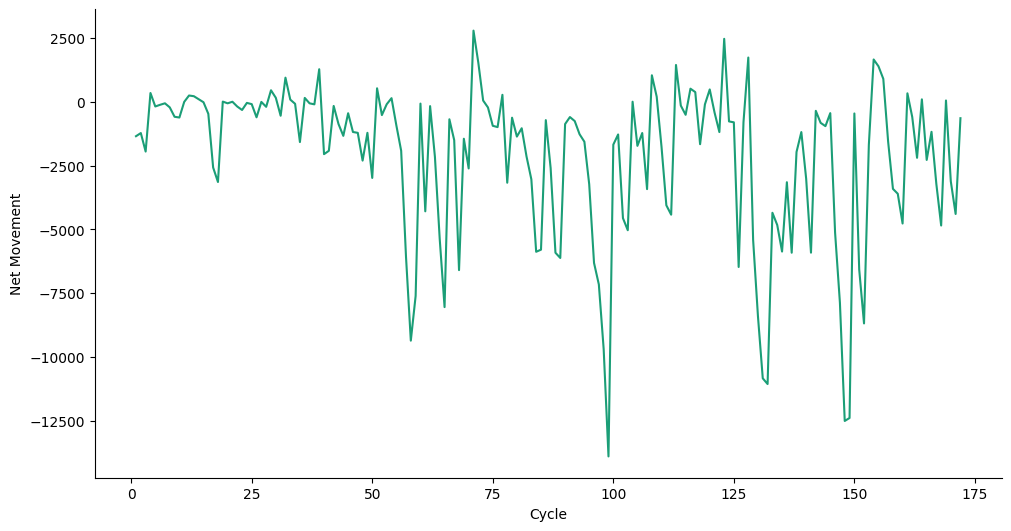

In [ ]:
# @title Cycle vs Net Movement

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Cycle']
  ys = series['Net Movement']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cycle_data.sort_values('Cycle', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Cycle')
_ = plt.ylabel('Net Movement')

### Nested Cycle Formation

In [ ]:
def compute_composite_cycles(net_movements):
    """
    Computes composite cycle values (cumulative net movement) from detect_cycles output.

    Args:
        net_movements (list): Output from detect_cycles (R + K per cycle)

    Returns:
        composite_cycles (list): Cumulative net movement (composite cycle)
    """
    return np.cumsum(net_movements).tolist()


In [ ]:
# Now compute composite cycle
composite_cycles = compute_composite_cycles(net_movements)

# Print results
for i, (alpha, net, comp) in enumerate(zip(alphas, net_movements, composite_cycles), 1):
    print(f"Cycle {i}: α = {alpha}, Net = {net}, Composite = {comp}")

Cycle 1: α = 2.5005, Net = -1342.38, Composite = -1342.38
Cycle 2: α = 2.2796, Net = -1218.84, Composite = -2561.2200000000003
Cycle 3: α = 3.5764, Net = -1943.99, Composite = -4505.21
Cycle 4: α = 0.5218, Net = 352.78, Composite = -4152.43
Cycle 5: α = 0.1407, Net = -176.07, Composite = -4328.5
Cycle 6: α = 0.1206, Net = -110.03, Composite = -4438.53
Cycle 7: α = 0.1048, Net = -52.0, Composite = -4490.53
Cycle 8: α = 0.1193, Net = -210.42, Composite = -4700.95
Cycle 9: α = 0.1532, Net = -579.98, Composite = -5280.93
Cycle 10: α = 0.3067, Net = -609.51, Composite = -5890.4400000000005
Cycle 11: α = 0.9639, Net = 4.96, Composite = -5885.4800000000005
Cycle 12: α = 0.558, Net = 254.16, Composite = -5631.320000000001
Cycle 13: α = 0.605, Net = 227.13, Composite = -5404.1900000000005
Cycle 14: α = 0.8068, Net = 111.07, Composite = -5293.120000000001
Cycle 15: α = 0.1017, Net = -9.89, Composite = -5303.010000000001
Cycle 16: α = 0.1809, Net = -465.05, Composite = -5768.060000000001
Cycle 17

In [ ]:
cycle_data['Composite Cycle'] = composite_cycles
cycle_data

,Cycle,Alpha,Net Movement,Composite Cycle
0,1,2.5005,-1342.38,-1342.38
1,2,2.2796,-1218.84,-2561.22
2,3,3.5764,-1943.99,-4505.21
3,4,0.5218,352.78,-4152.43
4,5,0.1407,-176.07,-4328.50
...,...,...,...,...
167,168,1.0363,-4846.06,-354090.88
168,169,0.9381,59.37,-354031.51
169,170,0.4246,-3114.00,-357145.51
170,171,5.4506,-4392.83,-361538.34


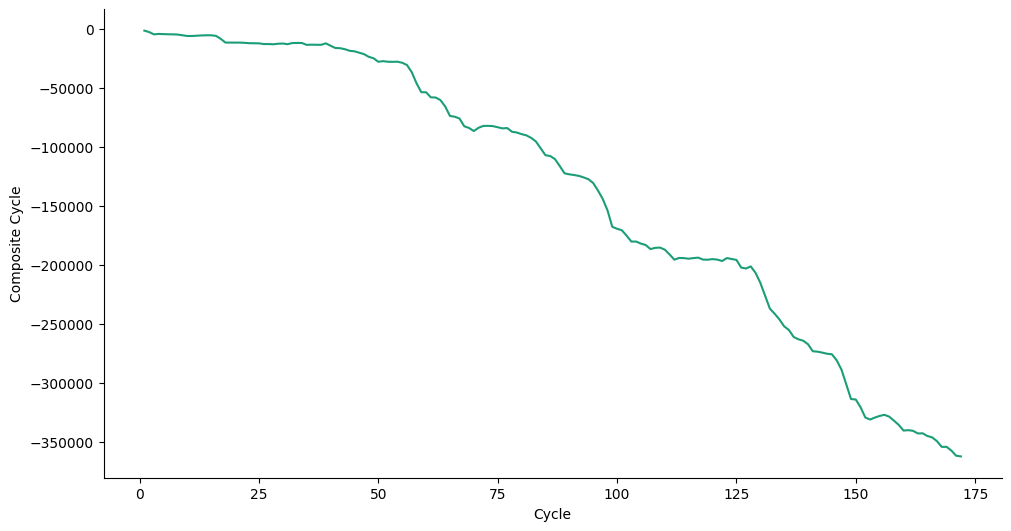

In [ ]:
# @title Cycle vs Composite Cycle

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Cycle']
  ys = series['Composite Cycle']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cycle_data.sort_values('Cycle', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Cycle')
_ = plt.ylabel('Composite Cycle')

## Nodal Points and Market Reversals


If nodal displacements shrink while composite cycle magnitude increases, a trend reversal may be approaching.

Then:

- Price is moving less between swing points

- But the cycle-based trend is still rising

This suggests divergence — momentum is weakening while structure is still pushing forward → reversal risk increases.


| Concept                       | Meaning                                  |
| ----------------------------- | ---------------------------------------- |
| Large composite cycle         | Trend is still structurally progressing  |
| Shrinking nodal displacements | Individual swings are getting weaker     |
| Combined message              | Trend is **exhausting**; reversal likely |


This is similar to momentum divergence in technical analysis, but it's derived from structural cycle behavior.


| Term                    | Meaning                             |
| ----------------------- | ----------------------------------- |
| Nodal point             | Local high/low swing                |
| Nodal displacement      | Price move between nodes            |
| Shrinking displacements | Sign of weakening trend             |
| Rising composite cycle  | Trend is still intact structurally  |
| Combined = reversal     | Trend may reverse due to exhaustion |


In [ ]:
def detect_nodal_displacements(prices, window=1):
    """
    Detects nodal points (local highs/lows), computes displacements, and triggers reversal alerts.

    Args:
        prices (np.ndarray): Series of price values (e.g., closes)
        window (int): Number of bars to check on each side for local extrema

    Returns:
        nodes (list): Indices of detected nodal points (swing highs/lows)
        displacements (list): List of nodal displacements (ΔP)
        alerts (list): Indices where reversal conditions are met
    """
    nodes = []
    displacements = []
    alerts = []

    # Step 1: Detect nodal points (extrema)
    for i in range(window, len(prices) - window):
        if prices[i] > prices[i - window] and prices[i] > prices[i + window]:
            nodes.append(i)  # local high
        elif prices[i] < prices[i - window] and prices[i] < prices[i + window]:
            nodes.append(i)  # local low

    # Step 2: Compute nodal displacements
    for i in range(1, len(nodes)):
        disp = prices[nodes[i]] - prices[nodes[i - 1]]
        displacements.append(disp)

    # Step 3: Alert if displacements are shrinking but composite is growing
    for i in range(2, len(displacements)):
        prev_disp = abs(displacements[i - 1])
        curr_disp = abs(displacements[i])
        composite_now = abs(displacements[i - 1] + displacements[i])
        composite_before = abs(displacements[i - 1])

        if curr_disp < prev_disp and composite_now > composite_before:
            alerts.append(nodes[i])

    return nodes, displacements, alerts


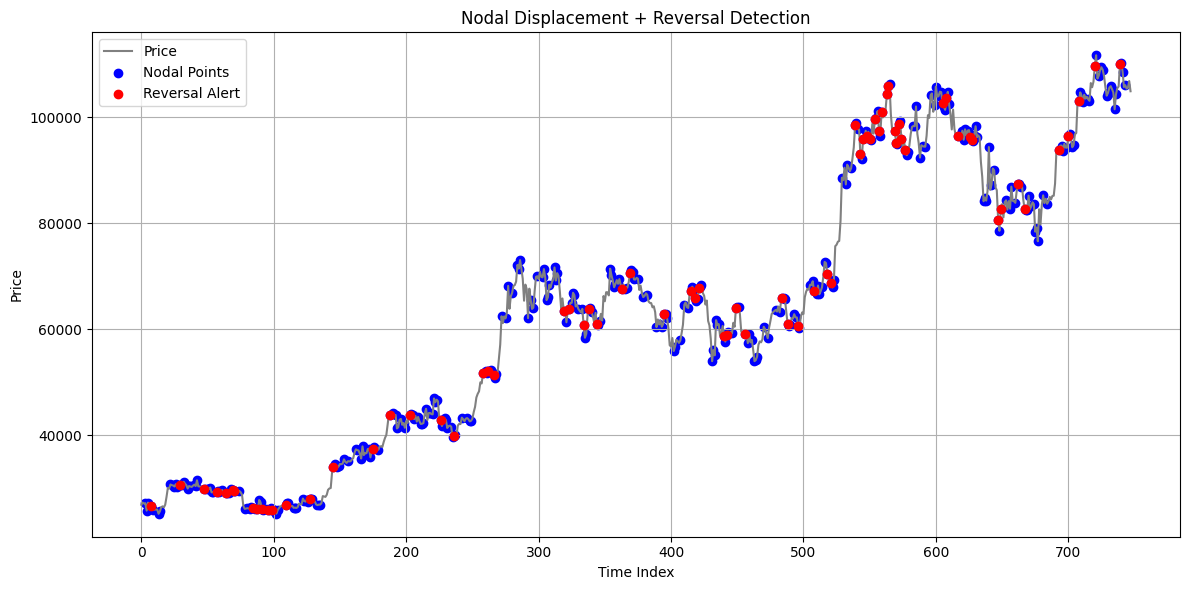

In [ ]:
# Run nodal detection
nodes, displacements, alerts = detect_nodal_displacements(prices, window=3)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(prices, label="Price", color="gray")
plt.scatter(nodes, prices[nodes], color="blue", label="Nodal Points")
plt.scatter(alerts, prices[alerts], color="red", label="Reversal Alert", zorder=5)
plt.title("Nodal Displacement + Reversal Detection")
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Print insights
for i, (n, d) in enumerate(zip(nodes[1:], displacements)):
    print(f"Node {i+1}: ΔP = {d:.2f}")


Node 1: ΔP = -1398.30
Node 2: ΔP = 1509.23
Node 3: ΔP = -709.47
Node 4: ΔP = -676.22
Node 5: ΔP = -725.15
Node 6: ΔP = 471.60
Node 7: ΔP = 5064.04
Node 8: ΔP = -189.07
Node 9: ΔP = -195.93
Node 10: ΔP = 432.77
Node 11: ΔP = -608.84
Node 12: ΔP = 377.87
Node 13: ΔP = 148.20
Node 14: ΔP = 535.00
Node 15: ΔP = -379.06
Node 16: ΔP = -885.75
Node 17: ΔP = 465.39
Node 18: ΔP = -80.57
Node 19: ΔP = 346.00
Node 20: ΔP = -261.01
Node 21: ΔP = 1089.17
Node 22: ΔP = -1589.85
Node 23: ΔP = -54.33
Node 24: ΔP = 90.00
Node 25: ΔP = 179.92
Node 26: ΔP = -904.40
Node 27: ΔP = 39.54
Node 28: ΔP = 95.17
Node 29: ΔP = 34.78
Node 30: ΔP = -54.89
Node 31: ΔP = 309.89
Node 32: ΔP = -480.01
Node 33: ΔP = -54.02
Node 34: ΔP = 25.80
Node 35: ΔP = 683.20
Node 36: ΔP = -199.96
Node 37: ΔP = -120.84
Node 38: ΔP = -27.03
Node 39: ΔP = 4.96
Node 40: ΔP = -3371.91
Node 41: ΔP = 126.23
Node 42: ΔP = -131.43
Node 43: ΔP = 394.69
Node 44: ΔP = -274.67
Node 45: ΔP = -161.22
Node 46: ΔP = 85.02
Node 47: ΔP = 29.30
Node 4

In [ ]:
for idx in alerts:
    print(f"🔺 Reversal Alert at index {idx} (Price = {prices[idx]})")

🔺 Reversal Alert at index 7 (Price = 26525.73)
🔺 Reversal Alert at index 29 (Price = 30476.8)
🔺 Reversal Alert at index 47 (Price = 29864.32)
🔺 Reversal Alert at index 57 (Price = 29310.22)
🔺 Reversal Alert at index 64 (Price = 29119.99)
🔺 Reversal Alert at index 69 (Price = 29575.01)
🔺 Reversal Alert at index 70 (Price = 29454.17)
🔺 Reversal Alert at index 84 (Price = 26175.01)
🔺 Reversal Alert at index 87 (Price = 26098.81)
🔺 Reversal Alert at index 91 (Price = 25949.97)
🔺 Reversal Alert at index 96 (Price = 25780.4)
🔺 Reversal Alert at index 99 (Price = 25912.99)
🔺 Reversal Alert at index 109 (Price = 26756.08)
🔺 Reversal Alert at index 127 (Price = 27935.03)
🔺 Reversal Alert at index 145 (Price = 33932.19)
🔺 Reversal Alert at index 175 (Price = 37290.14)
🔺 Reversal Alert at index 188 (Price = 43779.58)
🔺 Reversal Alert at index 203 (Price = 43854.69)
🔺 Reversal Alert at index 226 (Price = 42815.6)
🔺 Reversal Alert at index 236 (Price = 39885.18)
🔺 Reversal Alert at index 258 (Price

## Recursive Market Prediction



In [ ]:
def predict_recursive_market_price(prices, rallies, alpha=0.86, window=2):
    """
    Predicts future price using nested cycles and Theorem 5.1.

    Args:
        start_price (float): Price at the start of the first cycle (P(t_n))
        rallies (list of float): List of rally magnitudes (R_i)
        alpha (float): Correction ratio, typically 0.86

    Returns:
        float: Predicted price at the end of the k-th composite cycle
    """
    start_price = prices[rallies[0] - window + 1]
    rally_sizes = []  # infer from detected indices

    for i in range(len(rallies)):
        try:
            rally_start = prices[rallies[i] - window + 1]
            rally_end = prices[rallies[i]]
            rally_sizes.append(rally_end - rally_start)
        except IndexError:
            continue

    net_gain_factor = 1 - alpha  # typically 0.14
    total_rallies = sum(rallies)
    predicted_price = start_price + net_gain_factor * total_rallies
    return round(predicted_price, 4)


In [ ]:
# Calculate the weighted mean of alphas
weighted_alpha_mean = np.average(alphas, weights=net_movements)

print("Weighted Mean Alpha:", weighted_alpha_mean)

Weighted Mean Alpha: 6.658290068248888


In [ ]:
window_pred = 2
predicted = predict_recursive_market_price(prices, rallies, alpha=weighted_alpha_mean, window=window_pred)
print(f"📈 Predicted Price at End of Composite Cycle {window_pred}:", predicted)

📈 Predicted Price at End of Composite Cycle 2: -447226.4984


### 🔬 Advanced Option: Predict α per cycle

You could even go further and:

* **Predict α** using a regression model on:

  * volatility
  * cycle duration
  * volume
  * session/time of day

This would let you **forecast future α**, not just use a trailing average.



In [ ]:
# @title Step 1: Feature Extraction Function

def extract_cycle_features(rallies, corrections, closes, highs, lows, volumes, slopes, window):
    """
    Extracts features for predicting the alpha (correction factor) of market cycles.

    Args:
        rallies (list): List of indices where rallies end.
        corrections (list): List of indices where corrections end.
        closes (np.ndarray): Array of closing prices.
        highs (np.ndarray): Array of high prices.
        lows (np.ndarray): Array of low prices.
        volumes (np.ndarray): Array of trading volumes.
        slopes (list): List of computed slopes for price segments.
        window (int): The window size used for detecting cycles.

    Returns:
        tuple: A tuple containing two numpy arrays:
               - features_scaled (np.ndarray): An array of normalized features
                                        (volume sum, duration, slope, price range, volatility)
                                        for a detected cycle.
               - alphas (np.ndarray): An array of the calculated alpha values for each
                                      corresponding cycle.
               - scaler (MinMaxScaler): The fitted scaler object to inverse transform predictions if needed.
    """
    features = []
    alphas = []

    for r_idx in rallies:
        try:
            # Find the next correction after the rally
            c_idx = next(c for c in corrections if c > r_idx)
            rally_start = r_idx - window + 1
            rally_end = r_idx
            correction_end = c_idx

            # Calculate Rally (R) and Correction (K) magnitudes
            R = closes[rally_end] - closes[rally_start]
            K = closes[correction_end] - closes[rally_end]
            # Calculate alpha (Correction Factor)
            alpha = abs(K) / R if R != 0 else 0
            # alpha = min(abs(K) / R, 1) if R != 0 else 0

            # Extract features for the cycle
            duration = correction_end - rally_start
            # Get the slope corresponding to the start of the rally detection window
            slope = slopes[r_idx - window] if (r_idx - window) < len(slopes) else 0
            # Sum of volume during the cycle
            vol_sum = np.sum(volumes[rally_start:correction_end + 1])
            # Price range (High - Low) during the cycle
            range_ = np.max(highs[rally_start:correction_end + 1]) - np.min(lows[rally_start:correction_end + 1])
            # Calculate returns and volatility during the cycle
            returns = np.diff(closes[rally_start:correction_end + 1])
            volatility = np.std(returns)

            # # Nodal displacement: ΔP between last two nodal points before correction_end
            # if len(nodal_points) >= window:
            #   prior_nodals = [n for n in nodal_points if n <= correction_end]
            #   if len(prior_nodals) >= 2:
            #       delta_P = closes[prior_nodals[-1]] - closes[prior_nodals[-2]]
            #   else:
            #       delta_P = 0.0
            # else:
            #   delta_P = 0.0

            # features.append([vol_sum, duration, slope, range_, volatility, delta_P])

            # Append the extracted features and the calculated alpha
            features.append([vol_sum, duration, slope, range_, volatility])
            alphas.append(alpha)
        except:
            # Skip if there's an error (e.g., no correction found after a rally)
            continue

    if not features:
      return np.array([]), np.array([]), None

    features_np = np.array(features)
    alphas_np = np.array(alphas).reshape(-1, 1) # Reshape for scaler

    # Normalize the features
    feature_scaler = MinMaxScaler()
    features_scaled = feature_scaler.fit_transform(features_np)

    # Normalize the alpha values
    alpha_scaler = MinMaxScaler()
    alphas_scaled = alpha_scaler.fit_transform(alphas_np)

    out = {
        'features': features_np,
        'alphas': alphas_np,
        'features_scaled': features_scaled,
        'alphas_scaled': alphas_scaled,
        'feature_scaler': feature_scaler,
        'alpha_scaler': alpha_scaler
    }

    return out


In [ ]:
# @title Step 2: Train Alpha Regressor

def train_alpha_model(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

def train_alpha_model_rf(X, y):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    return model

In [ ]:
# @title Step 3: Predict Alpha for New Features

def predict_alpha(model, feature_scaler, alpha_scaler, features_dict: dict):
    """
    Predicts alpha for new features using a trained model and scalers.

    Args:
        model: The trained regression model.
        feature_scaler: The scaler used for normalizing features.
        alpha_scaler: The scaler used for normalizing alpha.
        features_dict (dict): A dictionary containing the new cycle features
                              (vol_sum, duration, slope, range_, volatility).

    Returns:
        float: The predicted alpha in the original scale.
    """
    # Ensure the order of features matches the scaler's training order
    ordered_features = np.array([[
        features_dict['vol_sum'],
        features_dict['duration'],
        features_dict['slope'],
        features_dict['range_'],
        features_dict['volatility']
    ]])

    # Prepare and scale new features
    new_features_scaled = feature_scaler.transform(ordered_features)

    # Predict scaled alpha
    predicted_alpha_scaled = model.predict(new_features_scaled)

    # Inverse transform the predicted scaled alpha to get the original alpha value
    predicted_alpha_original_scale = alpha_scaler.inverse_transform(predicted_alpha_scaled.reshape(-1, 1))

    # The inverse_transform returns an array, so access the first element
    predicted_alpha = predicted_alpha_original_scale[0][0]

    return predicted_alpha


In [ ]:
len(displacements)
# TODO: Add Normalization, also predict the next displacement

376

In [ ]:
out = extract_cycle_features(rallies, corrections, closes, highs, lows, volumes, slopes, window=2)
out

{'features': array([[1.36639944e+03, 2.00000000e+00, 5.59200000e+01, 2.05926000e+03,
         7.27110000e+02],
        [2.50012395e+03, 1.10000000e+01, 7.59030000e+02, 1.13252650e+05,
         6.43897858e+02],
        [2.28234251e+03, 1.00000000e+01, 1.73860000e+02, 1.12780330e+05,
         6.66197049e+02],
        ...,
        [7.08619900e+01, 4.00000000e+00, 4.31043000e+03, 5.30794000e+03,
         2.71663374e+03],
        [6.58631500e+01, 3.00000000e+00, 8.21000000e+01, 4.99172000e+03,
         1.22610054e+03],
        [2.14669000e+01, 2.00000000e+00, 1.28585000e+03, 4.33283000e+03,
         1.60388000e+03]]),
 'alphas': array([[2.50053648e+01],
        [5.16449943e+00],
        [2.15469343e+01],
        [1.31948871e+00],
        [1.56873634e-01],
        [5.21835778e-01],
        [1.40684428e+00],
        [2.56614715e-01],
        [1.20566355e+00],
        [1.04774278e+00],
        [3.06690630e+00],
        [9.63874727e-01],
        [1.40465116e+01],
        [5.57951858e-01],
     

In [ ]:
# Get scaled data and scalers
X, y, X_scaled, y_scaled, feature_scaler, alpha_scaler = out['features'], out['alphas'], out['features_scaled'], out['alphas_scaled'], out['feature_scaler'], out['alpha_scaler']

X.shape, y.shape

((217, 5), (217, 1))

In [ ]:
# Train your model on plain and scaled data
model_plain = train_alpha_model(X, y)
model_scaled = train_alpha_model(X_scaled, y_scaled)

# train_alpha_model | train_alpha_model_rf

In [ ]:
model_plain

LinearRegression()

In [ ]:
model_scaled

LinearRegression()

In [ ]:

# Assuming you have already run the `extract_cycle_features` function to get the features X
# And you have already fit the `LinearRegression` model on X and y (alpha_targets)
# You can get the last known values from the X array.

if len(X) > 0:
  last_cycle_features_dict = {
      'vol_sum': X[-1][0],
      'duration': X[-1][1],
      'slope': X[-1][2],
      'range_': X[-1][3],
      'volatility': X[-1][4]
  }
  # Check if the model was successfully trained (if X was not empty)
  if 'model_scaled' in locals() and hasattr(model_scaled, 'predict'):
    # Pass the features dictionary and the scalers to the predict_alpha function
    pred_alpha = predict_alpha(model_scaled, feature_scaler, alpha_scaler, last_cycle_features_dict)
    print("📈 Predicted Alpha for the last known cycle:", pred_alpha)
  else:
    print("Model was not trained because no cycles were detected or feature extraction failed.")
else:
  print("No cycles detected to extract features for prediction.")

📈 Predicted Alpha for the last known cycle: 5.226181231961721


In [ ]:
predicted = predict_recursive_market_price(start_price, rally_sizes, alpha=pred_alpha)
print("📈 Predicted Price at Composite Cycle End:", predicted)


NameError: name 'start_price' is not defined

### Market Cycle Analyzer


## 🔁 What Does “Rolling Windows” Mean?

In live or forward-looking systems, **market behavior changes over time**. If you train your model on all past data, you risk becoming **outdated**.

### ✅ Rolling Window = Only use recent cycles

Instead of using all past cycles, only keep:

```python
last_k = 100  # last 100 cycles
X_recent = X[-last_k:]
y_recent = y[-last_k:]
model.fit(X_recent, y_recent)
```

### 🔁 Why it helps:

* **Adapts to new market conditions**
* Reduces overfitting to outdated behavior
* Essential for **live trading models**



In [ ]:
stop

# Bin-Based Algorithm for Pivots

Pivots => Support/Resistance


**BinPivots**


```pine
indicator("BIN Based Support and Resistance [SS]", overlay=true)
lookback = input.int(500, "Lookback Length")
displaylabel = input.string("On SR lines", "Where would you like the statistics to display?", ["On SR lines", "Table", "OFF"])
offset = input.int(100, "Offset the lines ahead")
```


[Link](https://www.tradingview.com/script/AtzwB4pU-BIN-Based-Support-and-Resistance-SS/#:~:text=Bin%20Based%20Support%20and%20Resistance%20Levels%20dynamically%20adjust%20to%20ranges,at%20random%20peaks%20and%20valleys.&text=You%20can%20see%20these%202%20SR%20lines%20are%20close%20together.)


In [ ]:
ohlcv.shape

In [ ]:

def bin_based_support_resistance(df: pd.DataFrame, lookback: int = 500):
    # Ensure enough data
    if len(df) < lookback:
        raise ValueError("Not enough data for the given lookback period.")

    # Slice recent lookback window
    df_lb = df.tail(lookback).copy()

    max_close = df_lb['close'].max()
    min_close = df_lb['close'].min()
    bin_size = (max_close - min_close) / 10

    # Bin thresholds
    lbin = [min_close + i * bin_size for i in range(1, 6)]
    ubin = [max_close - i * bin_size for i in reversed(range(1, 6))]

    # Bin membership logic
    def assign_bin(value):
        thresholds = lbin + ubin
        for i in range(10):
            lower = min_close + i * bin_size
            upper = lower + bin_size if i < 9 else float('inf')
            if lower <= value < upper:
                return i + 1
        return None

    df_lb['bin'] = df_lb['close'].apply(assign_bin)

    # Collect values per bin
    bin_closes = {i: [] for i in range(1, 11)}
    for i in range(lookback):
        b = df_lb['bin'].iloc[i]
        if b is not None:
            bin_closes[b].append(df_lb['close'].iloc[i])

    # Compute average SR levels
    sr_levels = {f'sr{i}': np.mean(bin_closes[i]) if bin_closes[i] else np.nan for i in range(1, 11)}

    # Rejection statistic calculation
    def calculate_statistics(level, df_slice):
        if np.isnan(level):
            return np.nan, np.nan

        bullish_rejection = (df_slice['high'].shift(2) >= level) & (df_slice['close'] < level)
        bearish_rejection = (df_slice['low'].shift(2) <= level) & (df_slice['close'] > level)

        reject_bull = bullish_rejection.sum()
        reject_bear = bearish_rejection.sum()
        total = reject_bull + reject_bear

        if total == 0:
            return np.nan, np.nan

        support_success = (reject_bear / total) * 100
        resistance_success = (reject_bull / total) * 100
        return support_success, resistance_success

    stats = {}
    for i in range(1, 11):
        sr = sr_levels[f'sr{i}']
        support_success, resistance_success = calculate_statistics(sr, df_lb)
        stats[f'sr{i}_ss'] = support_success
        stats[f'sr{i}_rs'] = resistance_success

    return sr_levels, stats


In [ ]:
sr_levels, sr_stats = bin_based_support_resistance(ohlcv, lookback=500)

In [ ]:
sr_levels

In [ ]:
sr_stats

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import matplotlib.patheffects as pe

# Define exact Pine-style gradient colors
pine_gradient_hex = [
    "#ff00c8", "#e100ff", "#0d00ff", "#007bff", "#00ffd5", "#00ff15",
    "#00ff15", "#ffc400", "#ff7700", "#ff1500", "#ff008c", "#e3000b"
]

pine_gradient_rgb = [tuple(int(h[i:i+2], 16)/255 for i in (1, 3, 5)) for h in pine_gradient_hex]

pine_cmap = LinearSegmentedColormap.from_list("pine_gradient", pine_gradient_rgb)

def bin_based_sr_plot(df, lookback=500, offset=100, display="label", bins=10, custom_levels=None, export_path=None):
    close = df['close']
    high = df['high']
    low = df['low']

    max_close = close.rolling(lookback).max()
    min_close = close.rolling(lookback).min()

    sr_levels = []

    if custom_levels:
        sr_levels = sorted(custom_levels)
    else:
        diff = (max_close - min_close) / bins
        for i in range(bins):
            sr_levels.append(min_close + diff * (i + 0.5))

    # Compute support/resistance success
    def calc_stats(level):
        bull_reject = ((high.shift(2) >= level) & (close < level)).rolling(lookback).sum()
        bear_reject = ((low.shift(2) <= level) & (close > level)).rolling(lookback).sum()
        total = bull_reject + bear_reject
        support_success = (bear_reject / total * 100).fillna(0)
        resistance_success = (bull_reject / total * 100).fillna(0)
        return support_success, resistance_success

    support_success_list = []
    resistance_success_list = []
    for level in sr_levels:
        ss, rs = calc_stats(level)
        support_success_list.append(ss)
        resistance_success_list.append(rs)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    df['close'].plot(ax=ax, label='Close', color='gray', alpha=0.6)
    x = np.arange(len(df))
    latest_idx = x[-1]
    labels = []

    norm = plt.Normalize(0, len(sr_levels)-1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=pine_cmap)

    for i, level in enumerate(sr_levels):
        color = scalar_map.to_rgba(i)
        y = level.iloc[-1] if isinstance(level, pd.Series) else level
        ax.axhline(y=y, color=color, lw=2, alpha=0.8)

        # Tooltip-like label
        if display in ["label", "both"]:
            txt = f"SR {i+1}\nSS: {support_success_list[i].iloc[-1]:.1f}%\nRS: {resistance_success_list[i].iloc[-1]:.1f}%"
            label = ax.text(
                latest_idx + offset * 0.9, y, txt,
                fontsize=9, color='black', ha='left', va='center',
                bbox=dict(boxstyle="round,pad=0.3", fc=color, ec="black", alpha=0.8),
                path_effects=[pe.withStroke(linewidth=2, foreground="white")]
            )
            labels.append(label)

    # Optional table
    if display in ["table", "both"]:
        cell_text = []
        for i in range(len(sr_levels)):
            row = [
                f"SR {i+1}",
                f"{support_success_list[i].iloc[-1]:.1f}%",
                f"{resistance_success_list[i].iloc[-1]:.1f}%"
            ]
            cell_text.append(row)
        table = plt.table(
            cellText=cell_text,
            colLabels=["Level", "Support Success", "Resistance Success"],
            loc="bottom", cellLoc='center', colColours=["#303030"]*3
        )
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.5)
        plt.subplots_adjust(left=0.1, bottom=0.2)

    ax.set_title("BIN-Based Support & Resistance Levels")
    ax.legend()
    ax.grid(True)

    if export_path:
        plt.savefig(export_path, bbox_inches="tight")
    plt.show()


In [ ]:
#
bin_based_sr_plot(
    df=ohlcv,
    lookback=500,
    offset=100,
    display="both",  # options: "label", "table", "both"
    bins=12,         # or use `custom_levels=[...prices...]`
    export_path="sr_levels.png"
)


In [ ]:
import plotly.graph_objects as go


def bin_based_sr_plot_hover(
    df,
    lookback=500,
    offset=100,
    bins=10,
    custom_levels=None,
    display="both"
):
    df = df.copy()
    df = df[-lookback:].reset_index(drop=True)

    high, low, close = df["high"], df["low"], df["close"]

    max_p = close.max()
    min_p = close.min()

    if custom_levels:
        sr_levels = sorted(custom_levels)
        bins = len(sr_levels)
    else:
        step = (max_p - min_p) / bins
        sr_levels = [min_p + step * i for i in range(1, bins + 1)]

    def calculate_stats(level):
        bull_reject = (high.shift(2) >= level) & (close < level)
        bear_reject = (low.shift(2) <= level) & (close > level)
        bull_count = bull_reject.sum()
        bear_count = bear_reject.sum()
        total = bull_count + bear_count
        if total == 0:
            return 0, 0
        return round(bear_count / total * 100, 2), round(bull_count / total * 100, 2)

    support_success = []
    resistance_success = []

    for lvl in sr_levels:
        s, r = calculate_stats(lvl)
        support_success.append(s)
        resistance_success.append(r)

    # Gradient colors from Pine
    gradient_colors = [
        "#ff00c8", "#e100ff", "#0d00ff", "#007bff", "#00ffd5", "#00ff15",
        "#00ff15", "#ffc400", "#ff7700", "#ff1500", "#ff008c", "#e3000b"
    ][:bins]

    # Plot
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        y=close,
        x=df.index,
        mode='lines',
        name='Close',
        line=dict(color='white', width=1)
    ))

    for i, level in enumerate(sr_levels):
        fig.add_trace(go.Scatter(
            x=[0, lookback + offset],
            y=[level, level],
            mode="lines",
            name=f"SR {i+1}",
            line=dict(color=gradient_colors[i], width=2),
            hoverinfo="text",
            hovertext=(
                f"SR Level: {level:.2f}<br>"
                f"Support Success: {support_success[i]}%<br>"
                f"Resistance Success: {resistance_success[i]}%"
            ),
            showlegend=False
        ))

    if display in ["table", "both"]:
        table_data = {
            "SR Level": [f"{lvl:.2f}" for lvl in sr_levels],
            "Support Success (%)": support_success,
            "Resistance Success (%)": resistance_success
        }
        table_df = pd.DataFrame(table_data)
        print(table_df)

    fig.update_layout(
        title="Bin-Based Support and Resistance with Hover Tooltips",
        xaxis_title="Index",
        yaxis_title="Price",
        plot_bgcolor="black",
        paper_bgcolor="black",
        font=dict(color="white")
    )

    return fig


In [ ]:
#
fig = bin_based_sr_plot_hover(ohlcv)
fig.show()

In [ ]:

def compute_bins(df, lookback=500, num_bins=10):
    recent_data = df.tail(lookback)
    min_price = recent_data['close'].min()
    max_price = recent_data['close'].max()
    bin_edges = np.linspace(min_price, max_price, num_bins + 1)
    return bin_edges


In [ ]:
def group_closes_by_bin(df, bin_edges):
    bin_means = []
    for i in range(len(bin_edges) - 1):
        in_bin = df['close'][(df['close'] >= bin_edges[i]) & (df['close'] < bin_edges[i+1])]
        if not in_bin.empty:
            bin_means.append(in_bin.mean())
        else:
            bin_means.append(None)
    return bin_means


In [ ]:
def calculate_statistics(df, level, lookback):
    highs = df['high'].shift(2)
    lows = df['low'].shift(2)
    closes = df['close']

    bull_rejects = ((highs >= level) & (closes < level)).sum()
    bear_rejects = ((lows <= level) & (closes > level)).sum()

    total = bull_rejects + bear_rejects
    if total == 0:
        return (0.0, 0.0)

    support_success = bear_rejects / total * 100
    resistance_success = bull_rejects / total * 100
    return support_success, resistance_success


In [ ]:
import plotly.graph_objects as go
from plotly.colors import qualitative

def plot_sr_lines(df, bin_levels, support_stats, resistance_stats, colors, offset=100):
    fig = go.Figure()

    # OHLC chart
    fig.add_trace(go.Candlestick(
        x=df.index, open=df['open'], high=df['high'],
        low=df['low'], close=df['close'], name="Price"))

    # Add SR lines
    for i, level in enumerate(bin_levels):
        if level is not None:
            fig.add_trace(go.Scatter(
                x=[df.index[-offset], df.index[-1]],
                y=[level, level],
                mode='lines',
                line=dict(color=colors[i % len(colors)], width=2),
                name=f"SR {i+1}",
                hovertemplate=f"<b>SR {i+1}</b><br>Level: {level:.2f}<br>Support Success: {support_stats[i]:.2f}%<br>Resistance Success: {resistance_stats[i]:.2f}%",
                showlegend=False
            ))

    fig.update_layout(title="Gradient SR Lines with Stats", hovermode="x unified")
    return fig


In [ ]:
lookback = 500
bin_edges = compute_bins(ohlcv, lookback)
bin_levels = group_closes_by_bin(ohlcv.tail(lookback), bin_edges)

support_stats, resistance_stats = zip(*[
    calculate_statistics(ohlcv.tail(lookback), level, lookback) if level else (0, 0)
    for level in bin_levels
])


In [ ]:
# Gradient colors similar to Pine Script
colors = [
    '#ff00c8', '#e100ff', '#0d00ff', '#007bff', '#00ffd5',
    '#00ff15', '#00ff15', '#ffc400', '#ff7700', '#ff1500', '#ff008c', '#e3000b'
]

fig = plot_sr_lines(ohlcv, bin_levels, support_stats, resistance_stats, colors)
fig.show()

In [ ]:
stop

# Birch Algorithm for Pivots(Support/Resistance)


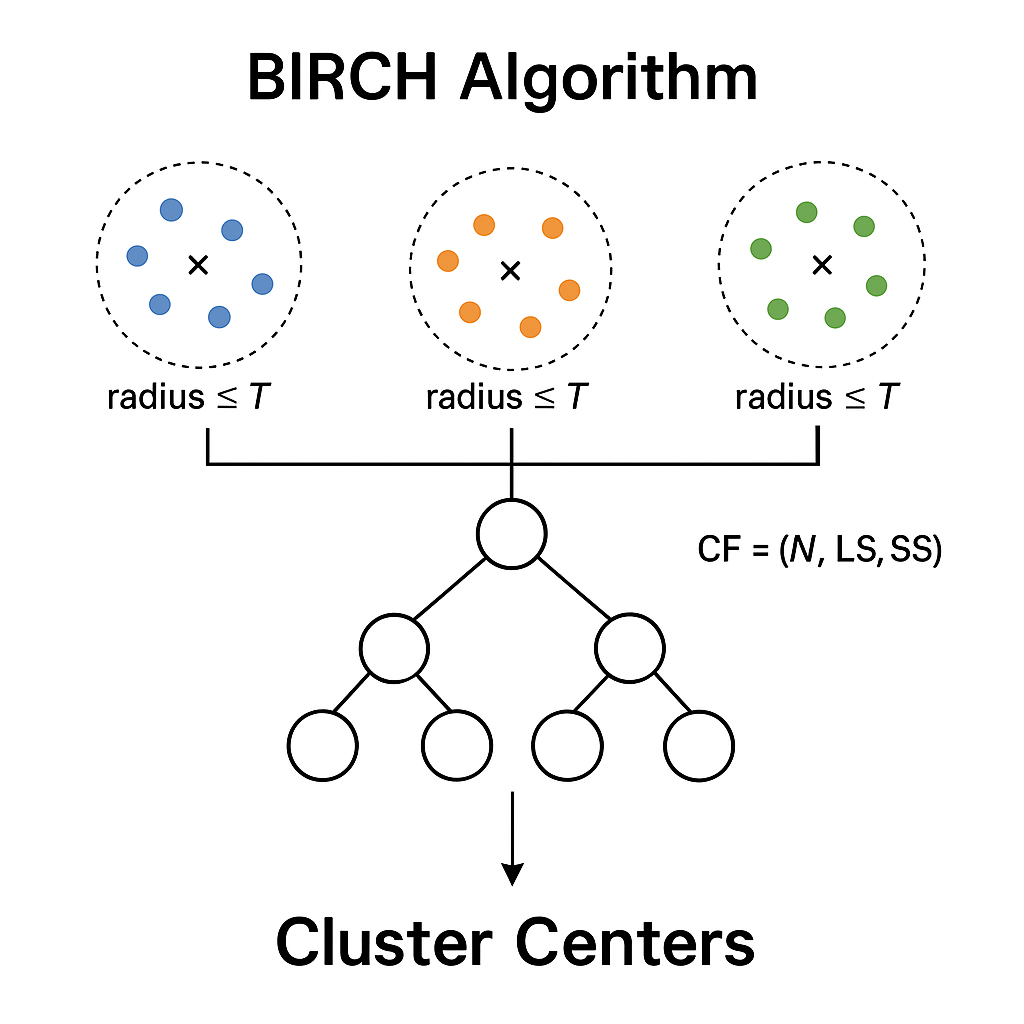


**The Chat**

https://chatgpt.com/c/68380a27-b8e4-8012-91ae-1b0c4348914f


## Normalize price for Birch threshold scaling (Custom Min-Max)

In [ ]:
# === STEP 2: Normalize price for Birch threshold scaling ===
normalized = (prices - prices.min()) / (prices.max() - prices.min())
X = normalized.reshape(-1, 1)

# === STEP 3: Run BIRCH clustering ===
model = Birch(threshold=0.09, branching_factor=50, n_clusters=None)
model.fit(X)
labels = model.predict(X)
centers = model.subcluster_centers_.flatten()

# === STEP 4: Organize results in a DataFrame ===
df = pd.DataFrame({
    "Date": dates,
    "Price": prices,
    "Normalized": normalized,
    "Cluster": labels
})
df

In [ ]:
centers

In [ ]:
# === STEP 5: Plot the clusters and cluster centers ===
plt.figure(figsize=(10, 5))
for label in np.unique(labels):
    mask = labels == label
    plt.scatter(dates[mask], prices[mask], label=f"Cluster {label}")
plt.plot(dates, prices, linestyle="--", alpha=0.5, color="gray", label="Price")

# Plot cluster centers as horizontal lines
for cen in centers:
    price_cen = cen * (prices.max() - prices.min()) + prices.min()
    plt.axhline(price_cen, linestyle=":", linewidth=1, color="black")

# plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"BIRCH Clustering on {INSTRUMENT} Prices")
plt.legend()
# plt.tight_layout()
plt.show()

# === STEP 6: Check cluster of last ATH point ===
last_label = labels[-1]
print(f"The ATH (last price point) falls into Cluster {last_label}.")


## BIRCH with raw price threshold

In [ ]:
# === STEP 2: Run BIRCH with raw price threshold ===
# Use an absolute price difference for threshold, e.g., $2,000
model = Birch(threshold=2000, branching_factor=50, n_clusters=None)
model.fit(prices.reshape(-1, 1))
labels = model.predict(prices.reshape(-1, 1))
centers = model.subcluster_centers_.flatten()

# === STEP 3: Organize results in a DataFrame ===
df = pd.DataFrame({
    "Date": dates,
    "Price": prices.flatten(),
    "Cluster": labels
})

# === STEP 4: Plot results ===
plt.figure(figsize=(10, 5))
for label in np.unique(labels):
    mask = labels == label
    plt.scatter(dates[mask], prices[mask], label=f"Cluster {label}")
plt.plot(dates, prices, linestyle="--", alpha=0.5, color="gray", label="Price")

# Plot raw-price cluster centers
for cen in centers:
    plt.axhline(cen, linestyle=":", linewidth=1, color="black")

# plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"BIRCH Clustering on Raw {INSTRUMENT} Prices")
plt.legend()
plt.tight_layout()
plt.show()


## Try price normalization using sklearn's MinMaxScaler

In [ ]:
# === STEP 2: Normalize price using MinMaxScaler ===
scaler = MinMaxScaler()
X = scaler.fit_transform(prices.reshape(-1, 1))

# === STEP 3: Run BIRCH clustering ===
model = Birch(threshold=0.05, branching_factor=50, n_clusters=None)
model.fit(X)
labels = model.predict(X)
centers = model.subcluster_centers_.flatten()

# === STEP 4: Denormalize centers for plotting ===
center_prices = scaler.inverse_transform(centers.reshape(-1, 1)).flatten()

# === STEP 5: Prepare DataFrame ===
df = pd.DataFrame({
    "Date": dates,
    "Price": prices,
    "Cluster": labels
})

# === STEP 6: Create animated plot ===
fig, ax = plt.subplots(figsize=(10, 5))
line, = ax.plot([], [], linestyle="--", alpha=0.5, color="gray", label="Price")
scatter = ax.scatter([], [], label="Cluster Points")

def init():
    ax.set_xlim(dates.min(), dates.max())
    ax.set_ylim(prices.min() * 0.95, prices.max() * 1.05)
    return line, scatter

def update(frame):
    ax.clear()
    ax.set_xlim(dates.min(), dates.max())
    ax.set_ylim(prices.min() * 0.95, prices.max() * 1.05)
    ax.set_title(f"BIRCH Clustering on {INSTRUMENT} Prices (Animated)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")

    # Plot price path up to current frame
    ax.plot(dates[:frame + 1], prices[:frame + 1], linestyle="--", alpha=0.5, color="gray", label="Price")

    # Plot clustered points
    for label in np.unique(labels[:frame + 1]):
        mask = labels[:frame + 1] == label
        ax.scatter(dates[:frame + 1][mask], prices[:frame + 1][mask], label=f"Cluster {label}")

    # Draw support/resistance zones
    for cen in center_prices:
        ax.axhline(cen, linestyle=":", linewidth=1, color="black", alpha=0.5)

    ax.legend(loc="upper left")
    return ax,

ani = FuncAnimation(fig, update, frames=len(prices), init_func=init, blit=False, repeat=False)

# Save the animation (optional)
ani.save("birch_btc_clusters_animation.mp4", writer="ffmpeg", fps=2)


## Use OHLCV Data

Use Mid Prices => (high + low) / 2

Try:

- HLC3 => (high + low + close) / 3

In [ ]:
# === Normalize mid prices ===
mid_prices = ((ohlcv["high"] + ohlcv["low"]) / 2).values.reshape(-1, 1)
scaler = MinMaxScaler()
X = scaler.fit_transform(mid_prices)

# === Apply BIRCH clustering ===
model = Birch(threshold=0.05, branching_factor=50, n_clusters=None)
model.fit(X)
labels = model.predict(X)

In [ ]:
# model.n_clusters
model.subcluster_labels_

In [ ]:
model.subcluster_centers_

In [ ]:
# # Access the micro-clusters
# micro_clusters = model.subcluster_centers_

# # Get the count of points in each micro-cluster
# for i, micro_cluster in enumerate(micro_clusters):
#     count = micro_cluster.n_samples
#     print(f"Micro-cluster {i+1}: {count} points")

In [ ]:
# 4) Retrieve subcluster centers and label mapping
centers_scaled = model.subcluster_centers_
centers = scaler.inverse_transform(centers_scaled).flatten()
label_map = model.subcluster_labels_

label_map

In [ ]:
# 5) Map each predicted label to corresponding cluster center
# label_map[i] tells you the label for subcluster_centers_[i]
# So: for each predicted label in labels, find the corresponding center
mapped_centers = np.array([centers[label_map == lbl][0] for lbl in labels])
mapped_centers

In [ ]:
# === Store cluster labels and calculate support/resistance ===
ohlcv["Cluster"] = labels
cluster_supports = ohlcv.groupby("Cluster")["low"].min().values
cluster_resistances = ohlcv.groupby("Cluster")["high"].max().values

In [ ]:
cluster_supports

In [ ]:
cluster_resistances

In [ ]:
# === Animate OHLC bars and zone overlays ===
fig, ax = plt.subplots(figsize=(10, 5))

def init():
    ax.set_xlim(ohlcv["timestamp"].min(), ohlcv["timestamp"].max())
    ax.set_ylim(ohlcv["low"].min() * 0.95, ohlcv["high"].max() * 1.05)
    return []

def update(frame):
    ax.clear()
    ax.set_xlim(ohlcv["timestamp"].min(), ohlcv["timestamp"].max())
    ax.set_ylim(ohlcv["low"].min() * 0.95, ohlcv["high"].max() * 1.05)
    ax.set_title("BIRCH Clustering: Support and Resistance Zones")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel(f"{INSTRUMENT} Price ({TIMEFRAME})")

    # Plot OHLC bars
    for i in range(frame + 1):
        color = "green" if ohlcv["close"][i] >= ohlcv["open"][i] else "red"
        ax.plot([ohlcv["timestamp"][i], ohlcv["timestamp"][i]], [ohlcv["low"][i], ohlcv["high"][i]], color="black")
        ax.plot([ohlcv["timestamp"][i], ohlcv["timestamp"][i]], [ohlcv["open"][i], ohlcv["close"][i]], color=color, linewidth=5)

    # Plot support and resistance
    for support in cluster_supports:
        ax.axhline(support, linestyle="--", color="blue", linewidth=1, alpha=0.5, label="Support")
    for resistance in cluster_resistances:
        ax.axhline(resistance, linestyle="--", color="orange", linewidth=1, alpha=0.5, label="Resistance")

    # Remove duplicate legend entries
    handles, labels_unique = ax.get_legend_handles_labels()
    by_label = dict(zip(labels_unique, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="upper left")

    return ax,

ani = FuncAnimation(fig, update, frames=len(ohlcv), init_func=init, blit=False, repeat=False)

# === Save the animation ===
ani.save(f"birch_{INSTRUMENT.replace('/', '_')}_ohlcv_support_resistance.mp4", writer="ffmpeg", fps=2)


In [ ]:
stop

# Smart Money Concepts Algorithms

https://www.tradingview.com/script/CnB3fSph-Smart-Money-Concepts-SMC-LuxAlgo/

https://www.luxalgo.com/library/indicator/smart-money-concepts-smc/

https://github.com/joshyattridge/smart-money-concepts

https://github.com/tsunafire/PineScript-SMC-Strategy

https://github.com/tristanlee85/ict-indicators

https://gist.github.com/niquedegraaff/8c2f45dc73519458afeae14b0096d719




## Assigns trading session based on UTC-converted time

In [ ]:
import pytz

def assign_session(df: pd.DataFrame, datetime_col: str = None, tz_local: str = 'UTC') -> pd.DataFrame:
    """
    Assigns trading session based on UTC-converted time.

    Sessions (UTC):
        - Asia:     00:00 - 06:59
        - London:   07:00 - 12:59
        - New York: 13:00 - 20:59
        - Other:    21:00 - 23:59

    Parameters:
    - df: DataFrame with datetime index or datetime column.
    - datetime_col: Name of datetime column if not using index.
    - tz_local: Timezone of your datetime data (e.g., 'America/New_York').

    Returns:
    - DataFrame with new 'session' column.
    """
    if datetime_col:
        dt_series = pd.to_datetime(df[datetime_col])
    else:
        if not pd.api.types.is_datetime64_any_dtype(df.index):
            raise ValueError("Index must be datetime or specify `datetime_col`.")
        dt_series = df.index.to_series()

    # Localize if naive, then convert to UTC
    if dt_series.dt.tz is None:
        dt_series = dt_series.dt.tz_localize(tz_local)
    dt_utc = dt_series.dt.tz_convert('UTC')

    # Assign sessions based on UTC hour
    hours = dt_utc.dt.hour
    conditions = [
        (hours >= 0) & (hours < 7),
        (hours >= 7) & (hours < 13),
        (hours >= 13) & (hours < 21),
    ]
    choices = ['Asia', 'London', 'New York']
    df['session'] = np.select(conditions, choices, default='Other')

    return df


In [ ]:
# # If datetime is in the index and in New York time:
# df = assign_session(df, tz_local='America/New_York')

# # If datetime is in a column:
# df = assign_session(df, datetime_col='timestamp', tz_local='Asia/Tokyo')

# assign_session_df = assign_session(ohlcv, datetime_col='timestamp')
# assign_session_df

## Fair Value Gaps(FVGs)

In [ ]:
def fvg(
    ohlc: pd.DataFrame,
    join_consecutive: bool = False,
    mitigation_method: str = "wick",
    threshold_pct: float = 0.0,
    session_column: str = None,
) -> pd.DataFrame:
    """
    FVG - Fair Value Gap (FVG) detection(LuxAlgo-style).

        A fair value gap is when the previous high is lower than the next low if the current candle is bullish.
        Or when the previous low is higher than the next high if the current candle is bearish.

        parameters:
        join_consecutive: bool - if there are multiple FVG in a row then they will be merged into one using the highest top and the lowest bottom

        returns:
        FVG = 1 if bullish fair value gap, -1 if bearish fair value gap
        Top = the top of the fair value gap
        Bottom = the bottom of the fair value gap
        MitigatedIndex = the index of the candle that mitigated the fair value gap

    Parameters:
    - join_consecutive: bool – Merge adjacent FVGs of the same type.
    - mitigation_method: str – "wick", "close", or "instant" mitigation detection.
    - threshold_pct: float – Minimum gap size as % of avg candle range.
    - session_column: str – Optional column name indicating session labels.

    Returns:
    DataFrame with: FVG, Top, Bottom, MitigatedIndex
    """
    fvg = np.where(
        (
            (ohlc["high"].shift(1) < ohlc["low"].shift(-1)) & (ohlc["close"] > ohlc["open"])
        ) | (
            (ohlc["low"].shift(1) > ohlc["high"].shift(-1)) & (ohlc["close"] < ohlc["open"])
        ),
        np.where(ohlc["close"] > ohlc["open"], 1, -1),
        np.nan,
    )

    top = np.where(~np.isnan(fvg), np.where(fvg == 1, ohlc["low"].shift(-1), ohlc["low"].shift(1)), np.nan)
    bottom = np.where(~np.isnan(fvg), np.where(fvg == 1, ohlc["high"].shift(1), ohlc["high"].shift(-1)), np.nan)

    # Threshold filter
    avg_range = (ohlc["high"] - ohlc["low"]).mean()
    threshold_abs = threshold_pct / 100 * avg_range
    gap_size = np.abs(top - bottom)
    fvg = np.where((gap_size >= threshold_abs) & ~np.isnan(fvg), fvg, np.nan)
    top = np.where(~np.isnan(fvg), top, np.nan)
    bottom = np.where(~np.isnan(fvg), bottom, np.nan)

    if join_consecutive:
        i = 0
        while i < len(fvg) - 1:
            if not np.isnan(fvg[i]) and fvg[i] == fvg[i + 1]:
                j = i
                while j + 1 < len(fvg) and fvg[j + 1] == fvg[i]:
                    top[j + 1] = max(top[j], top[j + 1])
                    bottom[j + 1] = min(bottom[j], bottom[j + 1])
                    fvg[j] = top[j] = bottom[j] = np.nan
                    j += 1
                i = j
            else:
                i += 1

    # Mitigation logic
    mitigated_index = np.full(len(ohlc), np.nan)
    for i in np.where(~np.isnan(fvg))[0]:
        if mitigation_method == "instant" and i + 1 < len(ohlc):
            if fvg[i] == 1 and ohlc["low"].iloc[i + 1] <= top[i]:
                mitigated_index[i] = i + 1
                continue
            elif fvg[i] == -1 and ohlc["high"].iloc[i + 1] >= bottom[i]:
                mitigated_index[i] = i + 1
                continue

        for j in range(i + 2, len(ohlc)):
            if fvg[i] == 1:
                if mitigation_method == "wick" and ohlc["low"].iloc[j] <= top[i]:
                    mitigated_index[i] = j
                    break
                elif mitigation_method == "close" and ohlc["close"].iloc[j] <= top[i]:
                    mitigated_index[i] = j
                    break
            else:
                if mitigation_method == "wick" and ohlc["high"].iloc[j] >= bottom[i]:
                    mitigated_index[i] = j
                    break
                elif mitigation_method == "close" and ohlc["close"].iloc[j] >= bottom[i]:
                    mitigated_index[i] = j
                    break

    df = pd.DataFrame({
        "FVG": fvg,
        "Top": top,
        "Bottom": bottom,
        "MitigatedIndex": mitigated_index,
    })

    # Session-based filter: only first unmitigated FVG per session
    if session_column:
        df["Session"] = ohlc[session_column]
        first_fvg_per_session = df[df["FVG"].notna()].groupby("Session").head(1).index
        mask = df.index.isin(first_fvg_per_session)
        df.loc[~mask, ["FVG", "Top", "Bottom", "MitigatedIndex"]] = np.nan
        df.drop(columns=["Session"], inplace=True)

    return df


In [ ]:
# df has a 'session' column with labels like 'Asia', 'London', etc.
fvg_df = fvg(
    assign_session_df,
    join_consecutive=True,
    mitigation_method="close",
    threshold_pct=10,
    session_column="session"
)

fvg_df

In [ ]:
fvg_df.value_counts()

## Swing Highs and Lows

In [ ]:
def swing_highs_lows(ohlc: pd.DataFrame, swing_length: int = 50) -> pd.DataFrame:
    """
    Swing Highs and Lows

        A swing high is when the current high is the highest high out of the swing_length amount of candles before and after.
        A swing low is when the current low is the lowest low out of the swing_length amount of candles before and after.

        parameters:
        swing_length: int - the amount of candles to look back and forward to determine the swing high or low

        returns:
        HighLow = 1 if swing high, -1 if swing low
        Level = the level of the swing high or low

    """

    half_window = swing_length
    full_window = 2 * half_window

    highs = ohlc['high']
    lows = ohlc['low']

    swing_highs_lows = np.where(
        highs == highs.shift(-half_window).rolling(full_window).max(),
        1,
        np.where(
            lows == lows.shift(-half_window).rolling(full_window).min(),
            -1,
            np.nan
        )
    )

    while True:
        positions = np.where(~np.isnan(swing_highs_lows))[0]
        if len(positions) < 2:
            break

        current = swing_highs_lows[positions[:-1]]
        next = swing_highs_lows[positions[1:]]

        highs_now = highs.iloc[positions[:-1]].values
        lows_now = lows.iloc[positions[:-1]].values
        highs_next = highs.iloc[positions[1:]].values
        lows_next = lows.iloc[positions[1:]].values

        index_to_remove = np.zeros(len(positions), dtype=bool)

        consecutive_highs = (current == 1) & (next == 1)
        index_to_remove[:-1] |= consecutive_highs & (highs_now < highs_next)
        index_to_remove[1:] |= consecutive_highs & (highs_now >= highs_next)

        consecutive_lows = (current == -1) & (next == -1)
        index_to_remove[:-1] |= consecutive_lows & (lows_now > lows_next)
        index_to_remove[1:] |= consecutive_lows & (lows_now <= lows_next)

        if not index_to_remove.any():
            break

        swing_highs_lows[positions[index_to_remove]] = np.nan

    positions = np.where(~np.isnan(swing_highs_lows))[0]
    if len(positions) > 0:
        swing_highs_lows[0] = -swing_highs_lows[positions[0]]
        swing_highs_lows[-1] = -swing_highs_lows[positions[-1]]

    level = np.where(
        ~np.isnan(swing_highs_lows),
        np.where(swing_highs_lows == 1, highs, lows),
        np.nan
    )

    return pd.DataFrame({
        'HighLow': swing_highs_lows,
        'Level': level
    })


In [ ]:
swing_highs_lows_df = swing_highs_lows(ohlcv, swing_length=50)
swing_highs_lows_df

In [ ]:
swing_highs_lows_df.value_counts()

### Swing Points

In [ ]:
def find_swing_points(df, window=50):
    df['Swing_High'] = df['high'][(df['high'].shift(-window) < df['high']) & (df['high'].shift(window) < df['high'])]
    df['Swing_Low'] = df['low'][(df['low'].shift(-window) > df['low']) & (df['low'].shift(window) > df['low'])]
    return df

swing_df = find_swing_points(ohlcv)

swing_df

  ## BOS/CHoCH      
  
  BOS - Break of Structure
  
  CHoCH - Change of Character
  
  These are both indications of market structure changing

In [ ]:

def bos_choch(ohlc: pd.DataFrame, swing_highs_lows: pd.DataFrame, close_break: bool = False) -> pd.DataFrame:
    """
    Detect Break of Structure (BOS) and Change of Character (CHoCH) in market structure.

    Parameters:
    - ohlc: pd.DataFrame with columns ['high', 'low', 'close'].
    - swing_highs_lows: pd.DataFrame with columns ['HighLow', 'Level'] from swing detection.
    - close_break: bool - whether to validate breaks using the close (True) or wick (False).

    Returns:
    - pd.DataFrame with columns:
        - 'BOS': 1 (bullish), -1 (bearish), np.nan
        - 'CHOCH': 1 (bullish), -1 (bearish), np.nan
        - 'Level': the level that was broken
        - 'BrokenIndex': index in `ohlc` where the break was confirmed
    """

    swing_highs_lows = swing_highs_lows.copy()

    level_order = []
    highs_lows_order = []
    last_positions = []

    bos = np.zeros(len(ohlc), dtype=np.int32)
    choch = np.zeros(len(ohlc), dtype=np.int32)
    level = np.zeros(len(ohlc), dtype=np.float32)

    for i in range(len(swing_highs_lows["HighLow"])):
        hl = swing_highs_lows["HighLow"][i]
        lvl = swing_highs_lows["Level"][i]

        if not np.isnan(hl):
            level_order.append(lvl)
            highs_lows_order.append(hl)
            last_positions.append(i)

            if len(level_order) >= 4 and len(last_positions) >= 4:
                idx = last_positions[-2]

                # Bullish BOS: [-1, 1, -1, 1] and rising structure
                if (
                    highs_lows_order[-4:] == [-1, 1, -1, 1] and
                    level_order[-4] < level_order[-2] < level_order[-3] < level_order[-1]
                ):
                    bos[idx] = 1
                    level[idx] = level_order[-3]

                # Bearish BOS: [1, -1, 1, -1] and falling structure
                if (
                    highs_lows_order[-4:] == [1, -1, 1, -1] and
                    level_order[-4] > level_order[-2] > level_order[-3] > level_order[-1]
                ):
                    bos[idx] = -1
                    level[idx] = level_order[-3]

                # Bullish CHoCH: structure flips up
                if (
                    highs_lows_order[-4:] == [-1, 1, -1, 1] and
                    level_order[-1] > level_order[-3] > level_order[-4] > level_order[-2]
                ):
                    choch[idx] = 1
                    level[idx] = level_order[-3]

                # Bearish CHoCH: structure flips down
                if (
                    highs_lows_order[-4:] == [1, -1, 1, -1] and
                    level_order[-1] < level_order[-3] < level_order[-4] < level_order[-2]
                ):
                    choch[idx] = -1
                    level[idx] = level_order[-3]

    # Validate that breaks occurred in future candles
    broken = np.zeros(len(ohlc), dtype=np.int32)

    for i in np.where((bos != 0) | (choch != 0))[0]:
        target_level = level[i]
        start_idx = i + 2

        if bos[i] == 1 or choch[i] == 1:
            condition = ohlc["close" if close_break else "high"][start_idx:] > target_level
        else:
            condition = ohlc["close" if close_break else "low"][start_idx:] < target_level

        if np.any(condition):
            j = np.argmax(condition) + start_idx
            broken[i] = j

            # Invalidate older signals that break later than this
            for k in np.where((bos != 0) | (choch != 0))[0]:
                if k < i and broken[k] >= j:
                    bos[k] = 0
                    choch[k] = 0
                    level[k] = 0

    # Invalidate signals never confirmed
    unconfirmed = (bos != 0) | (choch != 0)
    bos[unconfirmed & (broken == 0)] = 0
    choch[unconfirmed & (broken == 0)] = 0
    level[unconfirmed & (broken == 0)] = 0

    # Final formatting
    bos = pd.Series(np.where(bos != 0, bos, np.nan), name="BOS")
    choch = pd.Series(np.where(choch != 0, choch, np.nan), name="CHOCH")
    level = pd.Series(np.where(level != 0, level, np.nan), name="Level")
    broken = pd.Series(np.where(broken != 0, broken, np.nan), name="BrokenIndex")

    return pd.concat([bos, choch, level, broken], axis=1)


In [ ]:
bos_choch_df = bos_choch(ohlcv, swing_highs_lows_df, close_break=False)
bos_choch_df

In [ ]:
bos_choch_df.value_counts()

## OB - Order Blocks

Detects order blocks when there is a high amount of market orders exist on a price range.


**Also called Supply/Demand zones**

In [ ]:

def ob(
    ohlcv: pd.DataFrame,
    swing_highs_lows: pd.DataFrame,
    close_mitigation: bool = False,
    min_percentage_threshold: float = 0.0,  # Optional filter for minimum OB strength in %
) -> pd.DataFrame:
    """
    OB - Order Blocks detection

    Detect bullish and bearish order blocks based on swing highs/lows, volume, and price action.

    This detects order blocks when there is a high amount of market orders exist on a price range.

    Strength of order block(percentage) = min(highVolume, lowVolume) / max(highVolume, lowVolume))


    Parameters:
    -----------
    ohlcv : pd.DataFrame
        DataFrame containing 'open', 'high', 'low', 'close', 'volume' columns.
    swing_highs_lows : pd.DataFrame
        DataFrame with column 'HighLow' containing 1 (swing high), -1 (swing low), or 0.
    close_mitigation : bool, default False
        If True, mitigation is checked against candle close/open, otherwise high/low.
    min_percentage_threshold : float, default 0.0
        Minimum strength percentage to keep an OB; others set to NaN.

    Returns:
    --------
    pd.DataFrame with columns:
        'OB' : 1 (bullish), -1 (bearish), NaN (none)
        'Top' : high price of the OB
        'Bottom' : low price of the OB
        'OBVolume' : volume sum over OB candles
        'MitigatedIndex' : index of candle that mitigated the OB (NaN if not mitigated)
        'Percentage' : strength % of the OB volume distribution
    """

    ohlcv_len = len(ohlcv)
    _open = ohlcv["open"].values
    _high = ohlcv["high"].values
    _low = ohlcv["low"].values
    _close = ohlcv["close"].values
    _volume = ohlcv["volume"].values
    swing_hl = swing_highs_lows["HighLow"].values

    crossed = np.full(ohlcv_len, False, dtype=bool)
    ob = np.zeros(ohlcv_len, dtype=np.int32)
    top_arr = np.zeros(ohlcv_len, dtype=np.float32)
    bottom_arr = np.zeros(ohlcv_len, dtype=np.float32)
    obVolume = np.zeros(ohlcv_len, dtype=np.float32)
    pastVolume = np.zeros(ohlcv_len, dtype=np.float32)   # previously lowVolume
    recentVolume = np.zeros(ohlcv_len, dtype=np.float32) # previously highVolume
    percentage = np.zeros(ohlcv_len, dtype=np.float32)
    mitigated_index = np.full(ohlcv_len, -1, dtype=np.int32)  # -1 means not mitigated
    breaker = np.full(ohlcv_len, False, dtype=bool)

    swing_high_indices = np.flatnonzero(swing_hl == 1)
    swing_low_indices = np.flatnonzero(swing_hl == -1)

    active_bullish = []
    for i in range(ohlcv_len):
        close_index = i

        # Update existing bullish OBs
        for idx in active_bullish.copy():
            if breaker[idx]:
                if _high[close_index] > top_arr[idx]:
                    # Reset the OB after breaker price exceeds top
                    ob[idx] = 0
                    top_arr[idx] = 0.0
                    bottom_arr[idx] = 0.0
                    obVolume[idx] = 0.0
                    pastVolume[idx] = 0.0
                    recentVolume[idx] = 0.0
                    mitigated_index[idx] = -1
                    percentage[idx] = 0.0
                    breaker[idx] = False
                    active_bullish.remove(idx)
            else:
                if (not close_mitigation and _low[close_index] < bottom_arr[idx]) or \
                   (close_mitigation and min(_open[close_index], _close[close_index]) < bottom_arr[idx]):
                    breaker[idx] = True
                    mitigated_index[idx] = close_index - 1

        # Find last swing high index before close_index
        pos = np.searchsorted(swing_high_indices, close_index)
        last_top_index = swing_high_indices[pos - 1] if pos > 0 else None

        if last_top_index is not None:
            if _close[close_index] > _high[last_top_index] and not crossed[last_top_index]:
                crossed[last_top_index] = True
                default_index = close_index - 1
                obBtm = _high[default_index]
                obTop = _low[default_index]
                obIndex = default_index

                # Find lower low between last_top_index and close_index
                if close_index - last_top_index > 1:
                    start = last_top_index + 1
                    end = close_index
                    if end > start:
                        segment = _low[start:end]
                        min_val = segment.min()
                        candidates = np.nonzero(segment == min_val)[0]
                        if candidates.size:
                            candidate_index = start + candidates[-1]
                            obBtm = _low[candidate_index]
                            obTop = _high[candidate_index]
                            obIndex = candidate_index

                ob[obIndex] = 1
                top_arr[obIndex] = obTop
                bottom_arr[obIndex] = obBtm

                # Sum volumes safely, check bounds
                if close_index >= 2:
                    vol_sum = _volume[close_index] + _volume[close_index - 1] + _volume[close_index - 2]
                    pv = _volume[close_index - 2]
                    rv = _volume[close_index] + _volume[close_index - 1]
                elif close_index == 1:
                    vol_sum = _volume[close_index] + _volume[close_index - 1]
                    pv = _volume[close_index - 1]
                    rv = _volume[close_index]
                else:
                    vol_sum = _volume[close_index]
                    pv = 0
                    rv = _volume[close_index]

                obVolume[obIndex] = vol_sum
                pastVolume[obIndex] = pv
                recentVolume[obIndex] = rv

                max_vol = max(rv, pv)
                if max_vol != 0:
                    percentage[obIndex] = (min(rv, pv) / max_vol) * 100.0
                else:
                    percentage[obIndex] = 100.0

                active_bullish.append(obIndex)

    active_bearish = []
    for i in range(ohlcv_len):
        close_index = i

        # Update existing bearish OBs
        for idx in active_bearish.copy():
            if breaker[idx]:
                if _low[close_index] < bottom_arr[idx]:
                    ob[idx] = 0
                    top_arr[idx] = 0.0
                    bottom_arr[idx] = 0.0
                    obVolume[idx] = 0.0
                    pastVolume[idx] = 0.0
                    recentVolume[idx] = 0.0
                    mitigated_index[idx] = -1
                    percentage[idx] = 0.0
                    breaker[idx] = False
                    active_bearish.remove(idx)
            else:
                if (not close_mitigation and _high[close_index] > top_arr[idx]) or \
                   (close_mitigation and max(_open[close_index], _close[close_index]) > top_arr[idx]):
                    breaker[idx] = True
                    mitigated_index[idx] = close_index

        pos = np.searchsorted(swing_low_indices, close_index)
        last_btm_index = swing_low_indices[pos - 1] if pos > 0 else None

        if last_btm_index is not None:
            if _close[close_index] < _low[last_btm_index] and not crossed[last_btm_index]:
                crossed[last_btm_index] = True
                default_index = close_index - 1
                obTop = _high[default_index]
                obBtm = _low[default_index]
                obIndex = default_index

                # Find higher high between last_btm_index and close_index
                if close_index - last_btm_index > 1:
                    start = last_btm_index + 1
                    end = close_index
                    if end > start:
                        segment = _high[start:end]
                        max_val = segment.max()
                        candidates = np.nonzero(segment == max_val)[0]
                        if candidates.size:
                            candidate_index = start + candidates[-1]
                            obTop = _high[candidate_index]
                            obBtm = _low[candidate_index]
                            obIndex = candidate_index

                ob[obIndex] = -1
                top_arr[obIndex] = obTop
                bottom_arr[obIndex] = obBtm

                if close_index >= 2:
                    vol_sum = _volume[close_index] + _volume[close_index - 1] + _volume[close_index - 2]
                    pv = _volume[close_index] + _volume[close_index - 1]
                    rv = _volume[close_index - 2]
                elif close_index == 1:
                    vol_sum = _volume[close_index] + _volume[close_index - 1]
                    pv = _volume[close_index] + _volume[close_index - 1]
                    rv = 0
                else:
                    vol_sum = _volume[close_index]
                    pv = _volume[close_index]
                    rv = 0

                obVolume[obIndex] = vol_sum
                pastVolume[obIndex] = pv
                recentVolume[obIndex] = rv

                max_vol = max(rv, pv)
                if max_vol != 0:
                    percentage[obIndex] = (min(rv, pv) / max_vol) * 100.0
                else:
                    percentage[obIndex] = 100.0

                active_bearish.append(obIndex)

    # Mask weak OBs below threshold by setting to NaN
    mask_strong = percentage >= min_percentage_threshold
    ob_filtered = np.where(mask_strong, ob, 0)

    # Replace arrays with filtered OB where needed
    ob = ob_filtered

    # Convert -1 mitigated_index to NaN for convenience
    mitigated_index_float = mitigated_index.astype(np.float32)
    mitigated_index_float[mitigated_index_float < 0] = np.nan

    return pd.DataFrame({
        "OB": ob.astype(np.float32), # .astype(pd.Float32Dtype()),
        "Top": top_arr.astype(np.float32),
        "Bottom": bottom_arr.astype(np.float32),
        "OBVolume": obVolume.astype(np.float32),
        "MitigatedIndex": mitigated_index_float,
        "Percentage": percentage.astype(np.float32),
    })


In [ ]:
ob_df = ob(ohlcv, swing_highs_lows_df, close_mitigation=False, min_percentage_threshold=0)
ob_df

### Threshold OBs

In [ ]:
def detect_order_blocks(df, threshold=0.05):
    df['Bullish_OB'] = None
    df['Bearish_OB'] = None

    for i in range(2, len(df)):
        if df['Swing_High'].iloc[i] and (df['close'].iloc[i] - df['open'].iloc[i]) / df['open'].iloc[i] < -threshold:
            df.at[df.index[i], 'Bearish_OB'] = df['high'].iloc[i]
        elif df['Swing_Low'].iloc[i] and (df['close'].iloc[i] - df['open'].iloc[i]) / df['open'].iloc[i] > threshold:
            df.at[df.index[i], 'Bullish_OB'] = df['low'].iloc[i]

    return df

ob_df = detect_order_blocks(swing_df)

ob_df

In [ ]:
import matplotlib.dates as mdates

def plot_order_blocks(df):
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(df.index, df['close'], label='Close Price', color='black', alpha=0.5)
    ax.scatter(df.index[df['Bullish_OB'].notna()], df['Bullish_OB'].dropna(), color='green', label='Bullish OB', zorder=5)
    ax.scatter(df.index[df['Bearish_OB'].notna()], df['Bearish_OB'].dropna(), color='red', label='Bearish OB', zorder=5)

    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.title('Order Block Detection')
    plt.legend()
    plt.show()

plot_order_blocks(ob_df)


In [ ]:

def plot_order_blocks_plotly(df):
    fig = go.Figure()

    # Add candlestick trace
    fig.add_trace(go.Candlestick(
        x=df.index,
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        name='Price'
    ))

    # Add bullish OB markers (green upward triangles)
    bullish = df[df['Bullish_OB'].notna()]
    fig.add_trace(go.Scatter(
        x=bullish.index,
        y=bullish['Bullish_OB'],
        mode='markers',
        marker=dict(symbol='triangle-up', size=12, color='green'),
        name='Bullish OB',
        hovertemplate='Bullish OB<br>Date: %{x}<br>Price: %{y:.2f}<extra></extra>'
    ))

    # Add bearish OB markers (red downward triangles)
    bearish = df[df['Bearish_OB'].notna()]
    fig.add_trace(go.Scatter(
        x=bearish.index,
        y=bearish['Bearish_OB'],
        mode='markers',
        marker=dict(symbol='triangle-down', size=12, color='red'),
        name='Bearish OB',
        hovertemplate='Bearish OB<br>Date: %{x}<br>Price: %{y:.2f}<extra></extra>'
    ))

    # Layout settings
    fig.update_layout(
        title='Order Blocks with Candlestick Chart',
        yaxis_title='Price',
        xaxis_title='Date',
        xaxis_rangeslider_visible=False,
        template='plotly_dark',
        hovermode='x unified'
    )

    fig.show()


plot_order_blocks_plotly(ob_df)

In [ ]:
import plotly.graph_objects as go

def plot_order_blocks_with_boxes(df):
    fig = go.Figure()

    # Add candlestick trace
    fig.add_trace(go.Candlestick(
        x=df.index,
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        name='Price'
    ))

    # Get the last date on chart to extend boxes to
    last_date = df.index[-1]

    shapes = []

    # Function to add rectangle shape for each OB
    def add_ob_box(row, color):
        # x0 = OB candle index (date)
        x0 = row.name
        # x1 = last date on chart (extend box till end)
        x1 = last_date
        # y0 = low of OB candle
        y0 = row['low']
        # y1 = high of OB candle
        y1 = row['high']

        shapes.append(dict(
            type='rect',
            xref='x',
            yref='y',
            x0=x0,
            y0=y0,
            x1=x1,
            y1=y1,
            line=dict(color=color, width=1),
            fillcolor=color,
            opacity=0.3,
            layer='below'  # draw behind candlesticks
        ))

    # Add bullish OB boxes (green)
    bullish = df[df['Bullish_OB'].notna()]
    for _, row in bullish.iterrows():
        add_ob_box(row, 'green')

    # Add bearish OB boxes (red)
    bearish = df[df['Bearish_OB'].notna()]
    for _, row in bearish.iterrows():
        add_ob_box(row, 'red')

    # Update figure layout with shapes
    fig.update_layout(
        shapes=shapes,
        title='Order Blocks as Boxes with Candlestick Chart',
        yaxis_title='Price',
        xaxis_title='Date',
        xaxis_rangeslider_visible=False,
        # template='plotly_dark',
        hovermode='x unified'
    )

    fig.show()

plot_order_blocks_with_boxes(ob_df)

## Liquidity

Liquidity is when there are multiple highs within a small range of each other, or multiple lows within a small range of each other.

In [ ]:

def liquidity(
    ohlc: pd.DataFrame,
    swing_highs_lows: pd.DataFrame,
    range_percent: float = 0.01
) -> pd.DataFrame:
    """
    Liquidity

    Liquidity is when there are multiple highs within a small range of each other,
    or multiple lows within a small range of each other.

    parameters:
    swing_highs_lows: DataFrame - provide the dataframe from the swing_highs_lows function
    range_percent: float - the percentage of the range to determine liquidity

    returns:
    DataFrame with columns:
        Liquidity = 1 if bullish liquidity, -1 if bearish liquidity, NaN otherwise
        Level = the level of the liquidity (average price)
        End = the index of the last liquidity level candidate (int position)
        Swept = the index of the candle that swept the liquidity (int position) or NaN if not swept
    """

    # Work on a copy so the original is not modified.
    shl = swing_highs_lows.copy()
    n = len(ohlc)

    # Calculate the pip range based on the overall high-low range.
    pip_range = (ohlc["high"].max() - ohlc["low"].min()) * range_percent

    # Preconvert required columns to numpy arrays.
    ohlc_high = ohlc["high"].values
    ohlc_low = ohlc["low"].values
    # Make a copy to allow in-place marking of used candidates.
    shl_HL = shl["HighLow"].values.copy()
    shl_Level = shl["Level"].values.copy()

    # Initialise output arrays with NaN (to match later replacement of zeros).
    liquidity = np.full(n, np.nan, dtype=np.float32)
    liquidity_level = np.full(n, np.nan, dtype=np.float32)
    liquidity_end = np.full(n, np.nan, dtype=np.float32)
    liquidity_swept = np.full(n, np.nan, dtype=np.float32)

    # Process bullish liquidity (HighLow == 1)
    bull_indices = np.nonzero(shl_HL == 1)[0]
    for i in bull_indices:
        # Skip if this candidate has already been used.
        if shl_HL[i] != 1:
            continue
        high_level = shl_Level[i]
        range_low = high_level - pip_range
        range_high = high_level + pip_range
        group_levels = [high_level]
        group_end = i

        # Determine the swept index:
        # Find the first candle after i where the high reaches or exceeds range_high.
        c_start = i + 1
        if c_start < n:
            cond = ohlc_high[c_start:] >= range_high
            if np.any(cond):
                swept = c_start + int(np.argmax(cond))
            else:
                swept = np.nan
        else:
            swept = np.nan

        # Iterate only over candidate indices greater than i.
        for j in bull_indices:
            if j <= i:
                continue
            # Emulate the inner loop break: if we've reached or passed the swept index, stop.
            if not np.isnan(swept) and j >= swept:
                break
            # If candidate j is within the liquidity range, add it and mark it as used.
            if shl_HL[j] == 1 and (range_low <= shl_Level[j] <= range_high):
                group_levels.append(shl_Level[j])
                group_end = j
                shl_HL[j] = 0  # mark candidate as used
        # Only record liquidity if more than one candidate is grouped.
        if len(group_levels) > 1:
            avg_level = sum(group_levels) / len(group_levels)
            liquidity[i] = 1
            liquidity_level[i] = avg_level
            liquidity_end[i] = group_end
            liquidity_swept[i] = swept

    # Process bearish liquidity (HighLow == -1)
    bear_indices = np.nonzero(shl_HL == -1)[0]
    for i in bear_indices:
        if shl_HL[i] != -1:
            continue
        low_level = shl_Level[i]
        range_low = low_level - pip_range
        range_high = low_level + pip_range
        group_levels = [low_level]
        group_end = i

        # Find the first candle after i where the low reaches or goes below range_low.
        c_start = i + 1
        if c_start < n:
            cond = ohlc_low[c_start:] <= range_low
            if np.any(cond):
                swept = c_start + int(np.argmax(cond))
            else:
                swept = np.nan
        else:
            swept = np.nan

        for j in bear_indices:
            if j <= i:
                continue
            if not np.isnan(swept) and j >= swept:
                break
            if shl_HL[j] == -1 and (range_low <= shl_Level[j] <= range_high):
                group_levels.append(shl_Level[j])
                group_end = j
                shl_HL[j] = 0
        if len(group_levels) > 1:
            avg_level = sum(group_levels) / len(group_levels)
            liquidity[i] = -1
            liquidity_level[i] = avg_level
            liquidity_end[i] = group_end
            liquidity_swept[i] = swept

    # Convert arrays to Series with the proper names.
    liq_series = pd.Series(liquidity, name="Liquidity")
    level_series = pd.Series(liquidity_level, name="Level")
    end_series = pd.Series(liquidity_end, name="End")
    swept_series = pd.Series(liquidity_swept, name="Swept")

    return pd.concat([liq_series, level_series, end_series, swept_series], axis=1)


In [ ]:
liquidity_df = liquidity(ohlcv, swing_highs_lows_df, range_percent=0.01)
liquidity_df

## Previous High Low


Returns the previous high and low of the given time frame.


In [ ]:

def previous_high_low(
    ohlc: pd.DataFrame,
    time_frame: str = "1D",
    use_immediate_previous: bool = False
) -> pd.DataFrame:
    """
    Previous High Low
    This method returns the previous high and low of the given time frame.

    parameters:
    time_frame: str - the time frame to get the previous high and low 15m, 1H, 4H, 1D, 1W, 1M
    use_immediate_previous: bool - if True, use the immediately preceding resampled bar for high/low;
        if False (default), use the second last previous bar (skip last)

    returns:
    DataFrame with columns:
        PreviousHigh = the previous high
        PreviousLow = the previous low
        BrokenHigh = 1 if high is broken, else 0
        BrokenLow = 1 if low is broken, else 0
    """

    ohlc.index = pd.to_datetime(ohlc.index)

    previous_high = np.zeros(len(ohlc), dtype=np.float32)
    previous_low = np.zeros(len(ohlc), dtype=np.float32)
    broken_high = np.zeros(len(ohlc), dtype=np.int32)
    broken_low = np.zeros(len(ohlc), dtype=np.int32)

    resampled_ohlc = ohlc.resample(time_frame).agg(
        {
            "open": "first",
            "high": "max",
            "low": "min",
            "close": "last",
            "volume": "sum",
        }
    ).dropna()

    currently_broken_high = False
    currently_broken_low = False
    last_broken_time = None

    for i in range(len(ohlc)):
        resampled_previous_index = np.where(resampled_ohlc.index < ohlc.index[i])[0]

        # Determine required minimum number of previous bars
        min_bars_needed = 1 if use_immediate_previous else 2
        if len(resampled_previous_index) < min_bars_needed:
            previous_high[i] = np.nan
            previous_low[i] = np.nan
            continue

        # Select the previous bar index based on the flag
        if use_immediate_previous:
            resampled_previous_index = resampled_previous_index[-1]
        else:
            resampled_previous_index = resampled_previous_index[-2]

        if last_broken_time != resampled_previous_index:
            currently_broken_high = False
            currently_broken_low = False
            last_broken_time = resampled_previous_index

        previous_high[i] = resampled_ohlc["high"].iloc[resampled_previous_index]
        previous_low[i] = resampled_ohlc["low"].iloc[resampled_previous_index]
        currently_broken_high = ohlc["high"].iloc[i] > previous_high[i] or currently_broken_high
        currently_broken_low = ohlc["low"].iloc[i] < previous_low[i] or currently_broken_low
        broken_high[i] = 1 if currently_broken_high else 0
        broken_low[i] = 1 if currently_broken_low else 0

    previous_high = pd.Series(previous_high, name="PreviousHigh")
    previous_low = pd.Series(previous_low, name="PreviousLow")
    broken_high = pd.Series(broken_high, name="BrokenHigh")
    broken_low = pd.Series(broken_low, name="BrokenLow")

    return pd.concat([previous_high, previous_low, broken_high, broken_low], axis=1)


In [ ]:
previous_high_low_df = previous_high_low(ohlcv, time_frame="1D", use_immediate_previous=False)
previous_high_low_df

## Sessions

In [ ]:
from datetime import datetime
from typing import Literal

def sessions(
    ohlc: pd.DataFrame,
    session: str,
    start_time: str = "",
    end_time: str = "",
    time_zone: str = "UTC",
) -> pd.DataFrame:
    """
    Sessions
    Returns which candles are within the session specified.

    parameters:
    session: str - the session you want to check (Sydney, Tokyo, London, New York, Asian kill zone, London open kill zone, New York kill zone, London close kill zone, Custom)
    start_time: str - start time "HH:MM" for custom session
    end_time: str - end time "HH:MM" for custom session
    time_zone: str - timezone of candles, e.g., "UTC", "UTC+0", "GMT+0"

    returns:
    DataFrame with columns:
        Active = 1 if candle is within session, else 0
        High = highest high of session up to current candle (NaN if inactive)
        Low = lowest low of session up to current candle (NaN if inactive)
    """

    default_sessions = {
        "Sydney": {"start": "21:00", "end": "06:00"},
        "Tokyo": {"start": "00:00", "end": "09:00"},
        "London": {"start": "07:00", "end": "16:00"},
        "New York": {"start": "13:00", "end": "22:00"},
        "Asian kill zone": {"start": "00:00", "end": "04:00"},
        "London open kill zone": {"start": "06:00", "end": "09:00"},
        "New York kill zone": {"start": "11:00", "end": "14:00"},
        "London close kill zone": {"start": "14:00", "end": "16:00"},
        "Custom": {"start": start_time, "end": end_time},
    }

    if session not in default_sessions:
        raise ValueError(f"Session '{session}' not recognized. Must be one of: {list(default_sessions.keys())}")

    if session == "Custom" and (start_time == "" or end_time == ""):
        raise ValueError("Custom session requires a start and end time")

    ohlc = ohlc.copy()
    ohlc.index = pd.to_datetime(ohlc.index)

    # Normalize timezone if not UTC
    if time_zone != "UTC":
        tz_name = time_zone.replace("GMT", "Etc/GMT").replace("UTC", "Etc/GMT")
        ohlc.index = ohlc.index.tz_localize(tz_name).tz_convert("UTC")

    start_time_obj = datetime.strptime(default_sessions[session]["start"], "%H:%M")
    end_time_obj = datetime.strptime(default_sessions[session]["end"], "%H:%M")

    active = np.zeros(len(ohlc), dtype=np.int32)
    high = np.full(len(ohlc), np.nan, dtype=np.float32)
    low = np.full(len(ohlc), np.nan, dtype=np.float32)

    for i in range(len(ohlc)):
        current_time_obj = datetime.strptime(ohlc.index[i].strftime("%H:%M"), "%H:%M")
        in_session = (
            (start_time_obj < end_time_obj and start_time_obj <= current_time_obj <= end_time_obj)
            or
            (start_time_obj >= end_time_obj and (start_time_obj <= current_time_obj or current_time_obj <= end_time_obj))
        )

        if in_session:
            active[i] = 1
            if i == 0 or np.isnan(high[i - 1]):
                high[i] = ohlc["high"].iloc[i]
                low[i] = ohlc["low"].iloc[i]
            else:
                high[i] = max(ohlc["high"].iloc[i], high[i - 1])
                low[i] = min(ohlc["low"].iloc[i], low[i - 1])
        else:
            active[i] = 0
            high[i] = np.nan
            low[i] = np.nan

    active_series = pd.Series(active, name="Active")
    high_series = pd.Series(high, name="High")
    low_series = pd.Series(low, name="Low")

    return pd.concat([active_series, high_series, low_series], axis=1)


In [ ]:
sessions_ny_df = sessions(ohlcv, session="New York")
sessions_ny_df

In [ ]:
sessions_london_df = sessions(ohlcv, session="London")
sessions_london_df

In [ ]:
sessions_asia_kz_df = sessions(ohlcv, session="Asian kill zone")
sessions_asia_kz_df

## Retracements

In [ ]:

def retracements(ohlc: pd.DataFrame, swing_highs_lows: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate retracement percentages from swing highs/lows.

    Parameters:
    - ohlc: DataFrame with 'low' and 'high' columns
    - swing_highs_lows: DataFrame with columns:
        - 'HighLow': 1 for swing high, -1 for swing low, 0 otherwise
        - 'Level': price level of the swing

    Returns:
    DataFrame with columns:
    - Direction: 1 for bullish retracement, -1 for bearish retracement, 0 for none
    - CurrentRetracement%: retracement % from last swing high/low
    - DeepestRetracement%: deepest retracement % observed since last swing
    """

    swing_highs_lows = swing_highs_lows.reset_index(drop=True)
    ohlc = ohlc.reset_index(drop=True)

    direction = np.zeros(len(ohlc), dtype=np.int32)
    current_retracement = np.zeros(len(ohlc), dtype=np.float64)
    deepest_retracement = np.zeros(len(ohlc), dtype=np.float64)

    top = np.nan
    bottom = np.nan

    for i in range(len(ohlc)):
        hl = swing_highs_lows["HighLow"].iloc[i]
        level = swing_highs_lows["Level"].iloc[i]

        if hl == 1:
            direction[i] = 1
            top = level
        elif hl == -1:
            direction[i] = -1
            bottom = level
        else:
            direction[i] = direction[i - 1] if i > 0 else 0

        # Compute retracement only if we have valid top and bottom and a previous direction
        if i > 0 and not np.isnan(top) and not np.isnan(bottom):
            if direction[i - 1] == 1 and (top != bottom):
                # Bullish retracement: price pulling back from top towards bottom
                retracement = 100 * (1 - (ohlc["low"].iloc[i] - bottom) / (top - bottom))
                current_retracement[i] = round(retracement, 1)
                deepest_retracement[i] = max(deepest_retracement[i - 1], current_retracement[i])
            elif direction[i - 1] == -1 and (top != bottom):
                # Bearish retracement: price pulling back from bottom towards top
                retracement = 100 * (1 - (top - ohlc["high"].iloc[i]) / (top - bottom))
                current_retracement[i] = round(retracement, 1)
                deepest_retracement[i] = max(deepest_retracement[i - 1], current_retracement[i])
            else:
                # No retracement if no valid previous direction or top==bottom
                current_retracement[i] = 0
                deepest_retracement[i] = 0
        else:
            current_retracement[i] = 0
            deepest_retracement[i] = 0

    # Optional: zero out first few entries where calculation might be unstable (can customize)
    # Here, zeroing out until 3 changes in direction seen
    changes_found = 0
    for i in range(1, len(direction)):
        if direction[i] != direction[i-1]:
            changes_found += 1
        if changes_found < 3:
            direction[i] = 0
            current_retracement[i] = 0
            deepest_retracement[i] = 0
        else:
            break

    return pd.DataFrame({
        "Direction": direction,
        "CurrentRetracement%": current_retracement,
        "DeepestRetracement%": deepest_retracement,
    })


In [ ]:
retracements_df = retracements(ohlcv, swing_highs_lows_df)
retracements_df

## Visuals

In [ ]:
from datetime import datetime
import imageio
from io import BytesIO
from PIL import Image

In [ ]:
def add_FVG(fig, df, fvg_data):
    for i in range(len(fvg_data["FVG"])):
        if not np.isnan(fvg_data["FVG"][i]):
            x1 = int(
                fvg_data["MitigatedIndex"][i]
                if fvg_data["MitigatedIndex"][i] != 0 or fvg_data["MitigatedIndex"][i] != np.nan
                else len(df) - 1
            )
            fig.add_shape(
                # filled Rectangle
                type="rect",
                x0=df.index[i],
                y0=fvg_data["Top"][i],
                x1=df.index[x1],
                y1=fvg_data["Bottom"][i],
                line=dict(
                    width=0,
                ),
                fillcolor="yellow",
                opacity=0.2,
            )
            mid_x = round((i + x1) / 2)
            mid_y = (fvg_data["Top"][i] + fvg_data["Bottom"][i]) / 2
            fig.add_trace(
                go.Scatter(
                    x=[df.index[mid_x]],
                    y=[mid_y],
                    mode="text",
                    text="FVG",
                    textposition="middle center",
                    textfont=dict(color='rgba(255, 255, 255, 0.4)', size=8),
                )
            )
    return fig


def add_swing_highs_lows(fig, df, swing_highs_lows_data):
    indexs = []
    level = []
    for i in range(len(swing_highs_lows_data)):
        if not np.isnan(swing_highs_lows_data["HighLow"][i]):
            indexs.append(i)
            level.append(swing_highs_lows_data["Level"][i])

    # plot these lines on a graph
    for i in range(len(indexs) - 1):
        fig.add_trace(
            go.Scatter(
                x=[df.index[indexs[i]], df.index[indexs[i + 1]]],
                y=[level[i], level[i + 1]],
                mode="lines",
                line=dict(
                    color=(
                        "rgba(0, 128, 0, 0.2)"
                        if swing_highs_lows_data["HighLow"][indexs[i]] == -1
                        else "rgba(255, 0, 0, 0.2)"
                    ),
                ),
            )
        )

    return fig


def add_bos_choch(fig, df, bos_choch_data):
    for i in range(len(bos_choch_data["BOS"])):
        if not np.isnan(bos_choch_data["BOS"][i]):
            # add a label to this line
            mid_x = round((i + int(bos_choch_data["BrokenIndex"][i])) / 2)
            mid_y = bos_choch_data["Level"][i]
            fig.add_trace(
                go.Scatter(
                    x=[df.index[i], df.index[int(bos_choch_data["BrokenIndex"][i])]],
                    y=[bos_choch_data["Level"][i], bos_choch_data["Level"][i]],
                    mode="lines",
                    line=dict(
                        color="rgba(255, 165, 0, 0.2)",
                    ),
                )
            )
            fig.add_trace(
                go.Scatter(
                    x=[df.index[mid_x]],
                    y=[mid_y],
                    mode="text",
                    text="BOS",
                    textposition="top center" if bos_choch_data["BOS"][i] == 1 else "bottom center",
                    textfont=dict(color="rgba(255, 165, 0, 0.4)", size=8),
                )
            )
        if not np.isnan(bos_choch_data["CHOCH"][i]):
            # add a label to this line
            mid_x = round((i + int(bos_choch_data["BrokenIndex"][i])) / 2)
            mid_y = bos_choch_data["Level"][i]
            fig.add_trace(
                go.Scatter(
                    x=[df.index[i], df.index[int(bos_choch_data["BrokenIndex"][i])]],
                    y=[bos_choch_data["Level"][i], bos_choch_data["Level"][i]],
                    mode="lines",
                    line=dict(
                        color="rgba(0, 0, 255, 0.2)",
                    ),
                )
            )
            fig.add_trace(
                go.Scatter(
                    x=[df.index[mid_x]],
                    y=[mid_y],
                    mode="text",
                    text="CHOCH",
                    textposition="top center" if bos_choch_data["CHOCH"][i] == 1 else "bottom center",
                    textfont=dict(color="rgba(0, 0, 255, 0.4)", size=8),
                )
            )

    return fig


def add_OB(fig, df, ob_data):
    def format_volume(volume):
        if volume >= 1e12:
            return f"{volume / 1e12:.3f}T"
        elif volume >= 1e9:
            return f"{volume / 1e9:.3f}B"
        elif volume >= 1e6:
            return f"{volume / 1e6:.3f}M"
        elif volume >= 1e3:
            return f"{volume / 1e3:.3f}k"
        else:
            return f"{volume:.2f}"

    for i in range(len(ob_data["OB"])):
        if ob_data["OB"][i] == 1:
            x1 = int(
                ob_data["MitigatedIndex"][i]
                if ob_data["MitigatedIndex"][i] != 0
                else len(df) - 1
            )
            fig.add_shape(
                type="rect",
                x0=df.index[i],
                y0=ob_data["Bottom"][i],
                x1=df.index[x1],
                y1=ob_data["Top"][i],
                line=dict(color="Purple"),
                fillcolor="Purple",
                opacity=0.2,
                name="Bullish OB",
                legendgroup="bullish ob",
                showlegend=True,
            )

            if ob_data["MitigatedIndex"][i] > 0:
                x_center = df.index[int(i + (ob_data["MitigatedIndex"][i] - i) / 2)]
            else:
                x_center = df.index[int(i + (len(df) - i) / 2)]

            y_center = (ob_data["Bottom"][i] + ob_data["Top"][i]) / 2
            volume_text = format_volume(ob_data["OBVolume"][i])
            # Add annotation text
            annotation_text = f'OB: {volume_text} ({ob_data["Percentage"][i]}%)'

            fig.add_annotation(
                x=x_center,
                y=y_center,
                xref="x",
                yref="y",
                align="center",
                text=annotation_text,
                font=dict(color="rgba(255, 255, 255, 0.4)", size=8),
                showarrow=False,
            )

    for i in range(len(ob_data["OB"])):
        if ob_data["OB"][i] == -1:
            x1 = int(
                ob_data["MitigatedIndex"][i]
                if ob_data["MitigatedIndex"][i] != 0
                else len(df) - 1
            )
            fig.add_shape(
                type="rect",
                x0=df.index[i],
                y0=ob_data["Bottom"][i],
                x1=df.index[x1],
                y1=ob_data["Top"][i],
                line=dict(color="Purple"),
                fillcolor="Purple",
                opacity=0.2,
                name="Bearish OB",
                legendgroup="bearish ob",
                showlegend=True,
            )

            if ob_data["MitigatedIndex"][i] > 0:
                x_center = df.index[int(i + (ob_data["MitigatedIndex"][i] - i) / 2)]
            else:
                x_center = df.index[int(i + (len(df) - i) / 2)]

            y_center = (ob_data["Bottom"][i] + ob_data["Top"][i]) / 2
            volume_text = format_volume(ob_data["OBVolume"][i])
            # Add annotation text
            annotation_text = f'OB: {volume_text} ({ob_data["Percentage"][i]}%)'

            fig.add_annotation(
                x=x_center,
                y=y_center,
                xref="x",
                yref="y",
                align="center",
                text=annotation_text,
                font=dict(color="rgba(255, 255, 255, 0.4)", size=8),
                showarrow=False,
            )
    return fig


def add_liquidity(fig, df, liquidity_data):
    # draw a line horizontally for each liquidity level
    for i in range(len(liquidity_data["Liquidity"])):
        if not np.isnan(liquidity_data["Liquidity"][i]):
            fig.add_trace(
                go.Scatter(
                    x=[df.index[i], df.index[int(liquidity_data["End"][i])]],
                    y=[liquidity_data["Level"][i], liquidity_data["Level"][i]],
                    mode="lines",
                    line=dict(
                        color="rgba(255, 165, 0, 0.2)",
                    ),
                )
            )
            mid_x = round((i + int(liquidity_data["End"][i])) / 2)
            fig.add_trace(
                go.Scatter(
                    x=[df.index[mid_x]],
                    y=[liquidity_data["Level"][i]],
                    mode="text",
                    text="Liquidity",
                    textposition="top center" if liquidity_data["Liquidity"][i] == 1 else "bottom center",
                    textfont=dict(color="rgba(255, 165, 0, 0.4)", size=8),
                )
            )
        if liquidity_data["Swept"][i] != 0 and not np.isnan(liquidity_data["Swept"][i]):
            # draw a red line between the end and the swept point
            fig.add_trace(
                go.Scatter(
                    x=[
                        df.index[int(liquidity_data["End"][i])],
                        df.index[int(liquidity_data["Swept"][i])],
                    ],
                    y=[
                        liquidity_data["Level"][i],
                        (
                            df["high"].iloc[int(liquidity_data["Swept"][i])]
                            if liquidity_data["Liquidity"][i] == 1
                            else df["low"].iloc[int(liquidity_data["Swept"][i])]
                        ),
                    ],
                    mode="lines",
                    line=dict(
                        color="rgba(255, 0, 0, 0.2)",
                    ),
                )
            )
            mid_x = round((i + int(liquidity_data["Swept"][i])) / 2)
            mid_y = (
                liquidity_data["Level"][i]
                + (
                    df["high"].iloc[int(liquidity_data["Swept"][i])]
                    if liquidity_data["Liquidity"][i] == 1
                    else df["low"].iloc[int(liquidity_data["Swept"][i])]
                )
            ) / 2
            fig.add_trace(
                go.Scatter(
                    x=[df.index[mid_x]],
                    y=[mid_y],
                    mode="text",
                    text="Liquidity Swept",
                    textposition="top center" if liquidity_data["Liquidity"][i] == 1 else "bottom center",
                    textfont=dict(color="rgba(255, 0, 0, 0.4)", size=8),
                )
            )
    return fig


def add_previous_high_low(fig, df, previous_high_low_data):
    high = previous_high_low_data["PreviousHigh"]
    low = previous_high_low_data["PreviousLow"]

    # create a list of all the different high levels and their indexes
    high_levels = []
    high_indexes = []
    for i in range(len(high)):
        if not np.isnan(high[i]) and high[i] != (high_levels[-1] if len(high_levels) > 0 else None):
            high_levels.append(high[i])
            high_indexes.append(i)

    low_levels = []
    low_indexes = []
    for i in range(len(low)):
        if not np.isnan(low[i]) and low[i] != (low_levels[-1] if len(low_levels) > 0 else None):
            low_levels.append(low[i])
            low_indexes.append(i)

    # plot these lines on a graph
    for i in range(len(high_indexes)-1):
        fig.add_trace(
            go.Scatter(
                x=[df.index[high_indexes[i]], df.index[high_indexes[i+1]]],
                y=[high_levels[i], high_levels[i]],
                mode="lines",
                line=dict(
                    color="rgba(255, 255, 255, 0.2)",
                ),
            )
        )
        fig.add_trace(
            go.Scatter(
                x=[df.index[high_indexes[i+1]]],
                y=[high_levels[i]],
                mode="text",
                text="PH",
                textposition="top center",
                textfont=dict(color="rgba(255, 255, 255, 0.4)", size=8),
            )
        )

    for i in range(len(low_indexes)-1):
        fig.add_trace(
            go.Scatter(
                x=[df.index[low_indexes[i]], df.index[low_indexes[i+1]]],
                y=[low_levels[i], low_levels[i]],
                mode="lines",
                line=dict(
                    color="rgba(255, 255, 255, 0.2)",
                ),
            )
        )
        fig.add_trace(
            go.Scatter(
                x=[df.index[low_indexes[i+1]]],
                y=[low_levels[i]],
                mode="text",
                text="PL",
                textposition="bottom center",
                textfont=dict(color="rgba(255, 255, 255, 0.4)", size=8),
            )
        )

    return fig


def add_sessions(fig, df, sessions):
    for i in range(len(sessions["Active"])-1):
        if sessions["Active"][i] == 1:
            fig.add_shape(
                type="rect",
                x0=df.index[i],
                y0=sessions["Low"][i],
                x1=df.index[i + 1],
                y1=sessions["High"][i],
                line=dict(
                    width=0,
                ),
                fillcolor="#16866E",
                opacity=0.2,
            )
    return fig


def add_retracements(fig, df, retracements):
    for i in range(len(retracements)):
        if (
            (
                (
                    retracements["Direction"].iloc[i + 1]
                    if i < len(retracements) - 1
                    else 0
                )
                != retracements["Direction"].iloc[i]
                or i == len(retracements) - 1
            )
            and retracements["Direction"].iloc[i] != 0
            and (
                retracements["Direction"].iloc[i + 1]
                if i < len(retracements) - 1
                else retracements["Direction"].iloc[i]
            )
            != 0
        ):
            fig.add_annotation(
                x=df.index[i],
                y=(
                    df["high"].iloc[i]
                    if retracements["Direction"].iloc[i] == -1
                    else df["low"].iloc[i]
                ),
                xref="x",
                yref="y",
                text=f"C:{retracements['CurrentRetracement%'].iloc[i]}%<br>D:{retracements['DeepestRetracement%'].iloc[i]}%",
                font=dict(color="rgba(255, 255, 255, 0.4)", size=8),
                showarrow=False,
            )
    return fig


In [ ]:
# get the data
# def import_data(symbol, start_str, timeframe):
#     client = Client()
#     start_str = str(start_str)
#     end_str = f"{datetime.now()}"
#     df = pd.DataFrame(
#         client.get_historical_klines(
#             symbol=symbol, interval=timeframe, start_str=start_str, end_str=end_str
#         )
#     ).astype(float)
#     df = df.iloc[:, :6]
#     df.columns = ["timestamp", "open", "high", "low", "close", "volume"]
#     df = df.set_index("timestamp")
#     df.index = pd.to_datetime(df.index, unit="ms").strftime("%Y-%m-%d %H:%M:%S")
#     return df


# df = import_data("BTCUSDT", "2024-04-01", "15m")
smc_df = ohlcv.iloc[-500:]
smc_df

In [ ]:
# def fig_to_buffer(fig):
#     fig_bytes = fig.to_image(format="png")
#     fig_buffer = BytesIO(fig_bytes)
#     fig_image = Image.open(fig_buffer)
#     return np.array(fig_image)


# gif = []

# window = 100
# for pos in range(window, len(df)):
#     window_df = smc_df.iloc[pos - window : pos]

#     fig = go.Figure(
#         data=[
#             go.Candlestick(
#                 x=window_df.index,
#                 open=window_df["open"],
#                 high=window_df["high"],
#                 low=window_df["low"],
#                 close=window_df["close"],
#                 increasing_line_color="#77dd76",
#                 decreasing_line_color="#ff6962",
#             )
#         ]
#     )

#     fvg_data = fvg(window_df, join_consecutive=True)
#     swing_highs_lows_data = swing_highs_lows(window_df, swing_length=5)
#     bos_choch_data = bos_choch(window_df, swing_highs_lows_data)
#     ob_data = ob(window_df, swing_highs_lows_data)
#     liquidity_data = liquidity(window_df, swing_highs_lows_data)
#     previous_high_low_data = previous_high_low(window_df, time_frame="3d") # 4h
#     sessions = sessions(window_df, session="London")
#     retracements = retracements(window_df, swing_highs_lows_data)

#     fig = add_FVG(fig, window_df, fvg_data)
#     fig = add_swing_highs_lows(fig, window_df, swing_highs_lows_data)
#     fig = add_bos_choch(fig, window_df, bos_choch_data)
#     fig = add_OB(fig, window_df, ob_data)
#     fig = add_liquidity(fig, window_df, liquidity_data)
#     fig = add_previous_high_low(fig, window_df, previous_high_low_data)
#     fig = add_sessions(fig, window_df, sessions)
#     fig = add_retracements(fig, window_df, retracements)

#     fig.update_layout(xaxis_rangeslider_visible=False)
#     fig.update_layout(showlegend=False)
#     fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
#     fig.update_xaxes(visible=False, showticklabels=False)
#     fig.update_yaxes(visible=False, showticklabels=False)
#     fig.update_layout(plot_bgcolor="rgba(0,0,0,0)")
#     fig.update_layout(paper_bgcolor="rgba(12, 14, 18, 1)")
#     fig.update_layout(font=dict(color="white"))

#     # reduce the size of the image
#     fig.update_layout(width=500, height=300)

#     gif.append(fig_to_buffer(fig))


In [ ]:
# save the gif
# imageio.mimsave("smc_test.gif", gif, duration=1)

# All Candlestick Patterns

# Pine Scripts

## All Candlestick Patterns

In [ ]:
# //@version=6
# indicator("*All Candlestick Patterns*", shorttitle = "All Patterns", overlay=true)

# C_DownTrend = true
# C_UpTrend = true
# var trendRule1 = "SMA50"
# var trendRule2 = "SMA50, SMA200"
# var trendRule = input.string(trendRule1, "Detect Trend Based On", options=[trendRule1, trendRule2, "No detection"])

# if trendRule == trendRule1
# 	priceAvg = ta.sma(close, 50)
# 	C_DownTrend := close < priceAvg
# 	C_UpTrend := close > priceAvg

# if trendRule == trendRule2
# 	sma200 = ta.sma(close, 200)
# 	sma50 = ta.sma(close, 50)
# 	C_DownTrend := close < sma50 and sma50 < sma200
# 	C_UpTrend := close > sma50 and sma50 > sma200
# C_Len = 14 // ta.ema depth for bodyAvg
# C_ShadowPercent = 5.0 // size of shadows
# C_ShadowEqualsPercent = 100.0
# C_DojiBodyPercent = 5.0
# C_Factor = 2.0 // shows the number of times the shadow dominates the candlestick body

# C_BodyHi = math.max(close, open)
# C_BodyLo = math.min(close, open)
# C_Body = C_BodyHi - C_BodyLo
# C_BodyAvg = ta.ema(C_Body, C_Len)
# C_SmallBody = C_Body < C_BodyAvg
# C_LongBody = C_Body > C_BodyAvg
# C_UpShadow = high - C_BodyHi
# C_DnShadow = C_BodyLo - low
# C_HasUpShadow = C_UpShadow > C_ShadowPercent / 100 * C_Body
# C_HasDnShadow = C_DnShadow > C_ShadowPercent / 100 * C_Body
# C_WhiteBody = open < close
# C_BlackBody = open > close
# C_Range = high-low
# C_IsInsideBar = C_BodyHi[1] > C_BodyHi and C_BodyLo[1] < C_BodyLo
# C_BodyMiddle = C_Body / 2 + C_BodyLo
# C_ShadowEquals = C_UpShadow == C_DnShadow or (math.abs(C_UpShadow - C_DnShadow) / C_DnShadow * 100) < C_ShadowEqualsPercent and (math.abs(C_DnShadow - C_UpShadow) / C_UpShadow * 100) < C_ShadowEqualsPercent
# C_IsDojiBody = C_Range > 0 and C_Body <= C_Range * C_DojiBodyPercent / 100
# C_Doji = C_IsDojiBody and C_ShadowEquals

# patternLabelPosLow = low - (ta.atr(30) * 0.6)
# patternLabelPosHigh = high + (ta.atr(30) * 0.6)
# label_color_bullish = input(color.blue, "Label Color Bullish")
# label_color_bearish = input(color.red, "Label Color Bearish")
# label_color_neutral = input(color.gray, "Label Color Neutral")
# CandleType = input.string(title = "Pattern Type", defval="Both", options=["Bullish", "Bearish", "Both"])

# AbandonedBabyInput = input(title = "Abandoned Baby" ,defval=true)

# DarkCloudCoverInput = input(title = "Dark Cloud Cover" ,defval=false)

# DojiInput = input(title = "Doji" ,defval=true)

# DojiStarInput = input(title = "Doji Star" ,defval=false)

# DownsideTasukiGapInput = input(title = "Downside Tasuki Gap" ,defval=false)

# DragonflyDojiInput = input(title = "Dragonfly Doji" ,defval=true)

# EngulfingInput = input(title = "Engulfing" ,defval=true)

# EveningDojiStarInput = input(title = "Evening Doji Star" ,defval=false)

# EveningStarInput = input(title = "Evening Star" ,defval=false)

# FallingThreeMethodsInput = input(title = "Falling Three Methods" ,defval=false)

# FallingWindowInput = input(title = "Falling Window" ,defval=false)

# GravestoneDojiInput = input(title = "Gravestone Doji" ,defval=false)

# HammerInput = input(title = "Hammer" ,defval=true)

# HangingManInput = input(title = "Hanging Man" ,defval=false)

# HaramiCrossInput = input(title = "Harami Cross" ,defval=false)

# HaramiInput = input(title = "Harami" ,defval=false)

# InvertedHammerInput = input(title = "Inverted Hammer" ,defval=false)

# KickingInput = input(title = "Kicking" ,defval=false)

# LongLowerShadowInput = input(title = "Long Lower Shadow" ,defval=false)

# LongUpperShadowInput = input(title = "Long Upper Shadow" ,defval=false)

# MarubozuBlackInput = input(title = "Marubozu Black" ,defval=false)

# MarubozuWhiteInput = input(title = "Marubozu White" ,defval=false)

# MorningDojiStarInput = input(title = "Morning Doji Star" ,defval=false)

# MorningStarInput = input(title = "Morning Star" ,defval=false)

# OnNeckInput = input(title = "On Neck" ,defval=false)

# PiercingInput = input(title = "Piercing" ,defval=false)

# RisingThreeMethodsInput = input(title = "Rising Three Methods" ,defval=false)

# RisingWindowInput = input(title = "Rising Window" ,defval=false)

# ShootingStarInput = input(title = "Shooting Star" ,defval=false)

# SpinningTopBlackInput = input(title = "Spinning Top Black" ,defval=false)

# SpinningTopWhiteInput = input(title = "Spinning Top White" ,defval=false)

# ThreeBlackCrowsInput = input(title = "Three Black Crows" ,defval=false)

# ThreeWhiteSoldiersInput = input(title = "Three White Soldiers" ,defval=false)

# TriStarInput = input(title = "Tri-Star" ,defval=false)

# TweezerBottomInput = input(title = "Tweezer Bottom" ,defval=false)

# TweezerTopInput = input(title = "Tweezer Top" ,defval=false)

# UpsideTasukiGapInput = input(title = "Upside Tasuki Gap" ,defval=false)

# C_OnNeckBearishNumberOfCandles = 2
# C_OnNeckBearish = false
# if C_DownTrend and C_BlackBody[1] and C_LongBody[1] and C_WhiteBody and open < close[1] and C_SmallBody and C_Range!=0 and math.abs(close-low[1])<=C_BodyAvg*0.05
# 	C_OnNeckBearish := true
# alertcondition(C_OnNeckBearish, title = "On Neck – Bearish", message = "New On Neck – Bearish pattern detected")
# if C_OnNeckBearish  and  OnNeckInput and (("Bearish" == CandleType) or CandleType == "Both")

#     var ttBearishOnNeck = "On Neck\nOn Neck is a two-line continuation pattern found in a downtrend. The first candle is long and red, the second candle is short and has a green body. The closing price of the second candle is close or equal to the first candle's low price. The pattern hints at a continuation of a downtrend, and penetrating the low of the green candlestick is sometimes considered a confirmation. "
#     label.new(bar_index, patternLabelPosHigh, text="ON", style=label.style_label_down, color = label_color_bearish, textcolor=color.white, tooltip = ttBearishOnNeck)
# C_RisingWindowBullishNumberOfCandles = 2
# C_RisingWindowBullish = false
# if C_UpTrend[1] and (C_Range!=0 and C_Range[1]!=0) and low > high[1]
# 	C_RisingWindowBullish := true
# alertcondition(C_RisingWindowBullish, title = "Rising Window – Bullish", message = "New Rising Window – Bullish pattern detected")
# if C_RisingWindowBullish  and  RisingWindowInput and (("Bullish" == CandleType) or CandleType == "Both")

#     var ttBullishRisingWindow = "Rising Window\nRising Window is a two-candle bullish continuation pattern that forms during an uptrend. Both candles in the pattern can be of any type with the exception of the Four-Price Doji. The most important characteristic of the pattern is a price gap between the first candle's high and the second candle's low. That gap (window) between two bars signifies support against the selling pressure."
#     label.new(bar_index, patternLabelPosLow, text="RW", style=label.style_label_up, color = label_color_bullish, textcolor=color.white, tooltip = ttBullishRisingWindow)
# C_FallingWindowBearishNumberOfCandles = 2
# C_FallingWindowBearish = false
# if C_DownTrend[1] and (C_Range!=0 and C_Range[1]!=0) and high < low[1]
# 	C_FallingWindowBearish := true
# alertcondition(C_FallingWindowBearish, title = "Falling Window – Bearish", message = "New Falling Window – Bearish pattern detected")
# if C_FallingWindowBearish  and  FallingWindowInput and (("Bearish" == CandleType) or CandleType == "Both")

#     var ttBearishFallingWindow = "Falling Window\nFalling Window is a two-candle bearish continuation pattern that forms during a downtrend. Both candles in the pattern can be of any type, with the exception of the Four-Price Doji. The most important characteristic of the pattern is a price gap between the first candle's low and the second candle's high. The existence of this gap (window) means that the bearish trend is expected to continue."
#     label.new(bar_index, patternLabelPosHigh, text="FW", style=label.style_label_down, color = label_color_bearish, textcolor=color.white, tooltip = ttBearishFallingWindow)
# C_FallingThreeMethodsBearishNumberOfCandles = 5
# C_FallingThreeMethodsBearish = false
# if C_DownTrend[4] and (C_LongBody[4] and C_BlackBody[4]) and (C_SmallBody[3] and C_WhiteBody[3] and open[3]>low[4] and close[3]<high[4]) and (C_SmallBody[2] and C_WhiteBody[2] and open[2]>low[4] and close[2]<high[4]) and (C_SmallBody[1] and C_WhiteBody[1] and open[1]>low[4] and close[1]<high[4]) and (C_LongBody and C_BlackBody and close<close[4])
# 	C_FallingThreeMethodsBearish := true
# alertcondition(C_FallingThreeMethodsBearish, title = "Falling Three Methods – Bearish", message = "New Falling Three Methods – Bearish pattern detected")
# if C_FallingThreeMethodsBearish  and  FallingThreeMethodsInput and (("Bearish" == CandleType) or CandleType == "Both")

#     var ttBearishFallingThreeMethods = "Falling Three Methods\nFalling Three Methods is a five-candle bearish pattern that signifies a continuation of an existing downtrend. The first candle is long and red, followed by three short green candles with bodies inside the range of the first candle. The last candle is also red and long and it closes below the close of the first candle. This decisive fifth strongly bearish candle hints that bulls could not reverse the prior downtrend and that bears have regained control of the market."
#     label.new(bar_index, patternLabelPosHigh, text="FTM", style=label.style_label_down, color = label_color_bearish, textcolor=color.white, tooltip = ttBearishFallingThreeMethods)
# C_RisingThreeMethodsBullishNumberOfCandles = 5
# C_RisingThreeMethodsBullish = false
# if C_UpTrend[4] and (C_LongBody[4] and C_WhiteBody[4]) and (C_SmallBody[3] and C_BlackBody[3] and open[3]<high[4] and close[3]>low[4]) and (C_SmallBody[2] and C_BlackBody[2] and open[2]<high[4] and close[2]>low[4]) and (C_SmallBody[1] and C_BlackBody[1] and open[1]<high[4] and close[1]>low[4]) and (C_LongBody and C_WhiteBody and close>close[4])
# 	C_RisingThreeMethodsBullish := true
# alertcondition(C_RisingThreeMethodsBullish, title = "Rising Three Methods – Bullish", message = "New Rising Three Methods – Bullish pattern detected")
# if C_RisingThreeMethodsBullish  and  RisingThreeMethodsInput and (("Bullish" == CandleType) or CandleType == "Both")

#     var ttBullishRisingThreeMethods = "Rising Three Methods\nRising Three Methods is a five-candle bullish pattern that signifies a continuation of an existing uptrend. The first candle is long and green, followed by three short red candles with bodies inside the range of the first candle. The last candle is also green and long and it closes above the close of the first candle. This decisive fifth strongly bullish candle hints that bears could not reverse the prior uptrend and that bulls have regained control of the market."
#     label.new(bar_index, patternLabelPosLow, text="RTM", style=label.style_label_up, color = label_color_bullish, textcolor=color.white, tooltip = ttBullishRisingThreeMethods)
# C_TweezerTopBearishNumberOfCandles = 2
# C_TweezerTopBearish = false
# if C_UpTrend[1] and (not C_IsDojiBody or (C_HasUpShadow and C_HasDnShadow)) and math.abs(high-high[1]) <= C_BodyAvg*0.05 and C_WhiteBody[1] and C_BlackBody and C_LongBody[1]
# 	C_TweezerTopBearish := true
# alertcondition(C_TweezerTopBearish, title = "Tweezer Top – Bearish", message = "New Tweezer Top – Bearish pattern detected")
# if C_TweezerTopBearish  and  TweezerTopInput and (("Bearish" == CandleType) or CandleType == "Both")

#     var ttBearishTweezerTop = "Tweezer Top\nTweezer Top is a two-candle pattern that signifies a potential bearish reversal. The pattern is found during an uptrend. The first candle is long and green, the second candle is red, and its high is nearly identical to the high of the previous candle. The virtually identical highs, together with the inverted directions, hint that bears might be taking over the market."
#     label.new(bar_index, patternLabelPosHigh, text="TT", style=label.style_label_down, color = label_color_bearish, textcolor=color.white, tooltip = ttBearishTweezerTop)
# C_TweezerBottomBullishNumberOfCandles = 2
# C_TweezerBottomBullish = false
# if C_DownTrend[1] and (not C_IsDojiBody or (C_HasUpShadow and C_HasDnShadow)) and math.abs(low-low[1]) <= C_BodyAvg*0.05 and C_BlackBody[1] and C_WhiteBody and C_LongBody[1]
# 	C_TweezerBottomBullish := true
# alertcondition(C_TweezerBottomBullish, title = "Tweezer Bottom – Bullish", message = "New Tweezer Bottom – Bullish pattern detected")
# if C_TweezerBottomBullish  and  TweezerBottomInput and (("Bullish" == CandleType) or CandleType == "Both")

#     var ttBullishTweezerBottom = "Tweezer Bottom\nTweezer Bottom is a two-candle pattern that signifies a potential bullish reversal. The pattern is found during a downtrend. The first candle is long and red, the second candle is green, its lows nearly identical to the low of the previous candle. The virtually identical lows together with the inverted directions hint that bulls might be taking over the market."
#     label.new(bar_index, patternLabelPosLow, text="TB", style=label.style_label_up, color = label_color_bullish, textcolor=color.white, tooltip = ttBullishTweezerBottom)
# C_DarkCloudCoverBearishNumberOfCandles = 2
# C_DarkCloudCoverBearish = false
# if (C_UpTrend[1] and C_WhiteBody[1] and C_LongBody[1]) and (C_BlackBody and open >= high[1] and  close < C_BodyMiddle[1] and close > open[1])
# 	C_DarkCloudCoverBearish := true
# alertcondition(C_DarkCloudCoverBearish, title = "Dark Cloud Cover – Bearish", message = "New Dark Cloud Cover – Bearish pattern detected")
# if C_DarkCloudCoverBearish  and  DarkCloudCoverInput and (("Bearish" == CandleType) or CandleType == "Both")

#     var ttBearishDarkCloudCover = "Dark Cloud Cover\nDark Cloud Cover is a two-candle bearish reversal candlestick pattern found in an uptrend. The first candle is green and has a larger than average body. The second candle is red and opens above the high of the prior candle, creating a gap, and then closes below the midpoint of the first candle. The pattern shows a possible shift in the momentum from the upside to the downside, indicating that a reversal might happen soon."
#     label.new(bar_index, patternLabelPosHigh, text="DCC", style=label.style_label_down, color = label_color_bearish, textcolor=color.white, tooltip = ttBearishDarkCloudCover)
# C_DownsideTasukiGapBearishNumberOfCandles = 3
# C_DownsideTasukiGapBearish = false
# if C_LongBody[2] and C_SmallBody[1] and C_DownTrend and C_BlackBody[2] and C_BodyHi[1] < C_BodyLo[2] and C_BlackBody[1] and C_WhiteBody and C_BodyHi <= C_BodyLo[2] and C_BodyHi >= C_BodyHi[1]
# 	C_DownsideTasukiGapBearish := true
# alertcondition(C_DownsideTasukiGapBearish, title = "Downside Tasuki Gap – Bearish", message = "New Downside Tasuki Gap – Bearish pattern detected")
# if C_DownsideTasukiGapBearish  and  DownsideTasukiGapInput and (("Bearish" == CandleType) or CandleType == "Both")

#     var ttBearishDownsideTasukiGap = "Downside Tasuki Gap\nDownside Tasuki Gap is a three-candle pattern found in a downtrend that usually hints at the continuation of the downtrend. The first candle is long and red, followed by a smaller red candle with its opening price that gaps below the body of the previous candle. The third candle is green and it closes inside the gap created by the first two candles, unable to close it fully. The bull’s inability to close that gap hints that the downtrend might continue."
#     label.new(bar_index, patternLabelPosHigh, text="DTG", style=label.style_label_down, color = label_color_bearish, textcolor=color.white, tooltip = ttBearishDownsideTasukiGap)
# C_UpsideTasukiGapBullishNumberOfCandles = 3
# C_UpsideTasukiGapBullish = false
# if C_LongBody[2] and C_SmallBody[1] and C_UpTrend and C_WhiteBody[2] and C_BodyLo[1] > C_BodyHi[2] and C_WhiteBody[1] and C_BlackBody and C_BodyLo >= C_BodyHi[2] and C_BodyLo <= C_BodyLo[1]
# 	C_UpsideTasukiGapBullish := true
# alertcondition(C_UpsideTasukiGapBullish, title = "Upside Tasuki Gap – Bullish", message = "New Upside Tasuki Gap – Bullish pattern detected")
# if C_UpsideTasukiGapBullish  and  UpsideTasukiGapInput and (("Bullish" == CandleType) or CandleType == "Both")

#     var ttBullishUpsideTasukiGap = "Upside Tasuki Gap\nUpside Tasuki Gap is a three-candle pattern found in an uptrend that usually hints at the continuation of the uptrend. The first candle is long and green, followed by a smaller green candle with its opening price that gaps above the body of the previous candle. The third candle is red and it closes inside the gap created by the first two candles, unable to close it fully. The bear’s inability to close the gap hints that the uptrend might continue."
#     label.new(bar_index, patternLabelPosLow, text="UTG", style=label.style_label_up, color = label_color_bullish, textcolor=color.white, tooltip = ttBullishUpsideTasukiGap)
# C_EveningDojiStarBearishNumberOfCandles = 3
# C_EveningDojiStarBearish = false
# if C_LongBody[2] and C_IsDojiBody[1] and C_LongBody and C_UpTrend and C_WhiteBody[2] and C_BodyLo[1] > C_BodyHi[2] and C_BlackBody and C_BodyLo <= C_BodyMiddle[2] and C_BodyLo > C_BodyLo[2] and C_BodyLo[1] > C_BodyHi
# 	C_EveningDojiStarBearish := true
# alertcondition(C_EveningDojiStarBearish, title = "Evening Doji Star – Bearish", message = "New Evening Doji Star – Bearish pattern detected")
# if C_EveningDojiStarBearish  and  EveningDojiStarInput and (("Bearish" == CandleType) or CandleType == "Both")

#     var ttBearishEveningDojiStar = "Evening Doji Star\nThis candlestick pattern is a variation of the Evening Star pattern. It is bearish and continues an uptrend with a long-bodied, green candle day. It is then followed by a gap and a Doji candle and concludes with a downward close. The close would be below the first day’s midpoint. It is more bearish than the regular evening star pattern because of the existence of the Doji."
#     label.new(bar_index, patternLabelPosHigh, text="EDS", style=label.style_label_down, color = label_color_bearish, textcolor=color.white, tooltip = ttBearishEveningDojiStar)
# C_DojiStarBearishNumberOfCandles = 2
# C_DojiStarBearish = false
# if C_UpTrend and C_WhiteBody[1] and C_LongBody[1] and C_IsDojiBody and C_BodyLo > C_BodyHi[1]
# 	C_DojiStarBearish := true
# alertcondition(C_DojiStarBearish, title = "Doji Star – Bearish", message = "New Doji Star – Bearish pattern detected")
# if C_DojiStarBearish  and  DojiStarInput and (("Bearish" == CandleType) or CandleType == "Both")

#     var ttBearishDojiStar = "Doji Star\nThis is a bearish reversal candlestick pattern that is found in an uptrend and consists of two candles. First comes a long green candle, followed by a Doji candle (except 4-Price Doji) that opens above the body of the first one, creating a gap. It is considered a reversal signal with confirmation during the next trading day."
#     label.new(bar_index, patternLabelPosHigh, text="DS", style=label.style_label_down, color = label_color_bearish, textcolor=color.white, tooltip = ttBearishDojiStar)
# C_DojiStarBullishNumberOfCandles = 2
# C_DojiStarBullish = false
# if C_DownTrend and C_BlackBody[1] and C_LongBody[1] and C_IsDojiBody and C_BodyHi < C_BodyLo[1]
# 	C_DojiStarBullish := true
# alertcondition(C_DojiStarBullish, title = "Doji Star – Bullish", message = "New Doji Star – Bullish pattern detected")
# if C_DojiStarBullish  and  DojiStarInput and (("Bullish" == CandleType) or CandleType == "Both")

#     var ttBullishDojiStar = "Doji Star\nThis is a bullish reversal candlestick pattern that is found in a downtrend and consists of two candles. First comes a long red candle, followed by a Doji candle (except 4-Price Doji) that opens below the body of the first one, creating a gap. It is considered a reversal signal with confirmation during the next trading day."
#     label.new(bar_index, patternLabelPosLow, text="DS", style=label.style_label_up, color = label_color_bullish, textcolor=color.white, tooltip = ttBullishDojiStar)
# C_MorningDojiStarBullishNumberOfCandles = 3
# C_MorningDojiStarBullish = false
# if C_LongBody[2] and C_IsDojiBody[1] and C_LongBody and C_DownTrend and C_BlackBody[2] and C_BodyHi[1] < C_BodyLo[2] and C_WhiteBody and C_BodyHi >= C_BodyMiddle[2] and C_BodyHi < C_BodyHi[2] and C_BodyHi[1] < C_BodyLo
# 	C_MorningDojiStarBullish := true
# alertcondition(C_MorningDojiStarBullish, title = "Morning Doji Star – Bullish", message = "New Morning Doji Star – Bullish pattern detected")
# if C_MorningDojiStarBullish  and  MorningDojiStarInput and (("Bullish" == CandleType) or CandleType == "Both")

#     var ttBullishMorningDojiStar = "Morning Doji Star\nThis candlestick pattern is a variation of the Morning Star pattern. A three-day bullish reversal pattern, which consists of three candlesticks will look something like this: The first being a long-bodied red candle that extends the current downtrend. Next comes a Doji that gaps down on the open. After that comes a long-bodied green candle, which gaps up on the open and closes above the midpoint of the body of the first day. It is more bullish than the regular morning star pattern because of the existence of the Doji."
#     label.new(bar_index, patternLabelPosLow, text="MDS", style=label.style_label_up, color = label_color_bullish, textcolor=color.white, tooltip = ttBullishMorningDojiStar)
# C_PiercingBullishNumberOfCandles = 2
# C_PiercingBullish = false
# if (C_DownTrend[1] and C_BlackBody[1] and C_LongBody[1]) and (C_WhiteBody and open <= low[1] and close > C_BodyMiddle[1] and close < open[1])
# 	C_PiercingBullish := true
# alertcondition(C_PiercingBullish, title = "Piercing – Bullish", message = "New Piercing – Bullish pattern detected")
# if C_PiercingBullish  and  PiercingInput and (("Bullish" == CandleType) or CandleType == "Both")

#     var ttBullishPiercing = "Piercing\nPiercing is a two-candle bullish reversal candlestick pattern found in a downtrend. The first candle is red and has a larger than average body. The second candle is green and opens below the low of the prior candle, creating a gap, and then closes above the midpoint of the first candle. The pattern shows a possible shift in the momentum from the downside to the upside, indicating that a reversal might happen soon."
#     label.new(bar_index, patternLabelPosLow, text="P", style=label.style_label_up, color = label_color_bullish, textcolor=color.white, tooltip = ttBullishPiercing)
# C_HammerBullishNumberOfCandles = 1
# C_HammerBullish = false
# if C_SmallBody and C_Body > 0 and C_BodyLo > hl2 and C_DnShadow >= C_Factor * C_Body and not C_HasUpShadow
#     if C_DownTrend
#         C_HammerBullish := true
# alertcondition(C_HammerBullish, title = "Hammer – Bullish", message = "New Hammer – Bullish pattern detected")
# if C_HammerBullish  and  HammerInput and (("Bullish" == CandleType) or CandleType == "Both")

#     var ttBullishHammer = "Hammer\nHammer candlesticks form when a security moves lower after the open, but continues to rally into close above the intraday low. The candlestick that you are left with will look like a square attached to a long stick-like figure. This candlestick is called a Hammer if it happens to form during a decline."
#     label.new(bar_index, patternLabelPosLow, text="H", style=label.style_label_up, color = label_color_bullish, textcolor=color.white, tooltip = ttBullishHammer)
# C_HangingManBearishNumberOfCandles = 1
# C_HangingManBearish = false
# if C_SmallBody and C_Body > 0 and C_BodyLo > hl2 and C_DnShadow >= C_Factor * C_Body and not C_HasUpShadow
# 	if C_UpTrend
# 	    C_HangingManBearish := true
# alertcondition(C_HangingManBearish, title = "Hanging Man – Bearish", message = "New Hanging Man – Bearish pattern detected")
# if C_HangingManBearish  and  HangingManInput and (("Bearish" == CandleType) or CandleType == "Both")

#     var ttBearishHangingMan = "Hanging Man\nWhen a specified security notably moves lower after the open, but continues to rally to close above the intraday low, a Hanging Man candlestick will form. The candlestick will resemble a square, attached to a long stick-like figure. It is referred to as a Hanging Man if the candlestick forms during an advance."
#     label.new(bar_index, patternLabelPosHigh, text="HM", style=label.style_label_down, color = label_color_bearish, textcolor=color.white, tooltip = ttBearishHangingMan)
# C_ShootingStarBearishNumberOfCandles = 1
# C_ShootingStarBearish = false
# if C_SmallBody and C_Body > 0 and C_BodyHi < hl2 and C_UpShadow >= C_Factor * C_Body and not C_HasDnShadow
# 	if C_UpTrend
# 	    C_ShootingStarBearish := true
# alertcondition(C_ShootingStarBearish, title = "Shooting Star – Bearish", message = "New Shooting Star – Bearish pattern detected")
# if C_ShootingStarBearish  and  ShootingStarInput and (("Bearish" == CandleType) or CandleType == "Both")

#     var ttBearishShootingStar = "Shooting Star\nThis single day pattern can appear during an uptrend and opens high, while it closes near its open. It trades much higher as well. It is bearish in nature, but looks like an Inverted Hammer."
#     label.new(bar_index, patternLabelPosHigh, text="SS", style=label.style_label_down, color = label_color_bearish, textcolor=color.white, tooltip = ttBearishShootingStar)
# C_InvertedHammerBullishNumberOfCandles = 1
# C_InvertedHammerBullish = false
# if C_SmallBody and C_Body > 0 and C_BodyHi < hl2 and C_UpShadow >= C_Factor * C_Body and not C_HasDnShadow
#     if C_DownTrend
#         C_InvertedHammerBullish := true
# alertcondition(C_InvertedHammerBullish, title = "Inverted Hammer – Bullish", message = "New Inverted Hammer – Bullish pattern detected")
# if C_InvertedHammerBullish  and  InvertedHammerInput and (("Bullish" == CandleType) or CandleType == "Both")

#     var ttBullishInvertedHammer = "Inverted Hammer\nIf in a downtrend, then the open is lower. When it eventually trades higher, but closes near its open, it will look like an inverted version of the Hammer Candlestick. This is a one-day bullish reversal pattern."
#     label.new(bar_index, patternLabelPosLow, text="IH", style=label.style_label_up, color = label_color_bullish, textcolor=color.white, tooltip = ttBullishInvertedHammer)
# C_MorningStarBullishNumberOfCandles = 3
# C_MorningStarBullish = false
# if C_LongBody[2] and C_SmallBody[1] and C_LongBody
#     if C_DownTrend and C_BlackBody[2] and C_BodyHi[1] < C_BodyLo[2] and C_WhiteBody and C_BodyHi >= C_BodyMiddle[2] and C_BodyHi < C_BodyHi[2] and C_BodyHi[1] < C_BodyLo
#         C_MorningStarBullish := true
# alertcondition(C_MorningStarBullish, title = "Morning Star – Bullish", message = "New Morning Star – Bullish pattern detected")
# if C_MorningStarBullish  and  MorningStarInput and (("Bullish" == CandleType) or CandleType == "Both")

#     var ttBullishMorningStar = "Morning Star\nA three-day bullish reversal pattern, which consists of three candlesticks will look something like this: The first being a long-bodied red candle that extends the current downtrend. Next comes a short, middle candle that gaps down on the open. After comes a long-bodied green candle, which gaps up on the open and closes above the midpoint of the body of the first day."
#     label.new(bar_index, patternLabelPosLow, text="MS", style=label.style_label_up, color = label_color_bullish, textcolor=color.white, tooltip = ttBullishMorningStar)
# C_EveningStarBearishNumberOfCandles = 3
# C_EveningStarBearish = false
# if C_LongBody[2] and C_SmallBody[1] and C_LongBody
#     if C_UpTrend and C_WhiteBody[2] and C_BodyLo[1] > C_BodyHi[2] and C_BlackBody and C_BodyLo <= C_BodyMiddle[2] and C_BodyLo > C_BodyLo[2] and C_BodyLo[1] > C_BodyHi
#         C_EveningStarBearish := true
# alertcondition(C_EveningStarBearish, title = "Evening Star – Bearish", message = "New Evening Star – Bearish pattern detected")
# if C_EveningStarBearish  and  EveningStarInput and (("Bearish" == CandleType) or CandleType == "Both")

#     var ttBearishEveningStar = "Evening Star\nThis candlestick pattern is bearish and continues an uptrend with a long-bodied, green candle day. It is then followed by a gapped and small-bodied candle day, and concludes with a downward close. The close would be below the first day’s midpoint."
#     label.new(bar_index, patternLabelPosHigh, text="ES", style=label.style_label_down, color = label_color_bearish, textcolor=color.white, tooltip = ttBearishEveningStar)
# C_MarubozuWhiteBullishNumberOfCandles = 1
# C_MarubozuShadowPercentWhite = 5.0
# C_MarubozuWhiteBullish = C_WhiteBody and C_LongBody and C_UpShadow <= C_MarubozuShadowPercentWhite/100*C_Body and C_DnShadow <= C_MarubozuShadowPercentWhite/100*C_Body and C_WhiteBody
# alertcondition(C_MarubozuWhiteBullish, title = "Marubozu White – Bullish", message = "New Marubozu White – Bullish pattern detected")
# if C_MarubozuWhiteBullish  and  MarubozuWhiteInput and (("Bullish" == CandleType) or CandleType == "Both")

#     var ttBullishMarubozuWhite = "Marubozu White\nA Marubozu White Candle is a candlestick that does not have a shadow that extends from its candle body at either the open or the close. Marubozu is Japanese for “close-cropped” or “close-cut.” Other sources may call it a Bald or Shaven Head Candle."
#     label.new(bar_index, patternLabelPosLow, text="MW", style=label.style_label_up, color = label_color_bullish, textcolor=color.white, tooltip = ttBullishMarubozuWhite)
# C_MarubozuBlackBearishNumberOfCandles = 1
# C_MarubozuShadowPercentBearish = 5.0
# C_MarubozuBlackBearish = C_BlackBody and C_LongBody and C_UpShadow <= C_MarubozuShadowPercentBearish/100*C_Body and C_DnShadow <= C_MarubozuShadowPercentBearish/100*C_Body and C_BlackBody
# alertcondition(C_MarubozuBlackBearish, title = "Marubozu Black – Bearish", message = "New Marubozu Black – Bearish pattern detected")
# if C_MarubozuBlackBearish  and  MarubozuBlackInput and (("Bearish" == CandleType) or CandleType == "Both")

#     var ttBearishMarubozuBlack = "Marubozu Black\nThis is a candlestick that has no shadow, which extends from the red-bodied candle at the open, the close, or even at both. In Japanese, the name means “close-cropped” or “close-cut.” The candlestick can also be referred to as Bald or Shaven Head."
#     label.new(bar_index, patternLabelPosHigh, text="MB", style=label.style_label_down, color = label_color_bearish, textcolor=color.white, tooltip = ttBearishMarubozuBlack)
# C_DojiNumberOfCandles = 1
# C_DragonflyDoji = C_IsDojiBody and C_UpShadow <= C_Body
# C_GravestoneDojiOne = C_IsDojiBody and C_DnShadow <= C_Body
# alertcondition(C_Doji and not C_DragonflyDoji and not C_GravestoneDojiOne, title = "Doji", message = "New Doji pattern detected")
# if C_Doji and not C_DragonflyDoji and not C_GravestoneDojiOne and DojiInput
#     var ttDoji = "Doji\nWhen the open and close of a security are essentially equal to each other, a doji candle forms. The length of both upper and lower shadows may vary, causing the candlestick you are left with to either resemble a cross, an inverted cross, or a plus sign. Doji candles show the playout of buyer-seller indecision in a tug-of-war of sorts. As price moves either above or below the opening level during the session, the close is either at or near the opening level."
#     label.new(bar_index, patternLabelPosLow, text="D", style=label.style_label_up, color = label_color_neutral, textcolor=color.white, tooltip = ttDoji)
# C_GravestoneDojiBearishNumberOfCandles = 1
# C_GravestoneDojiBearish = C_IsDojiBody and C_DnShadow <= C_Body
# alertcondition(C_GravestoneDojiBearish, title = "Gravestone Doji – Bearish", message = "New Gravestone Doji – Bearish pattern detected")
# if C_GravestoneDojiBearish  and  GravestoneDojiInput and (("Bearish" == CandleType) or CandleType == "Both")

#     var ttBearishGravestoneDoji = "Gravestone Doji\nWhen a doji is at or is close to the day’s low point, a doji line will develop."
#     label.new(bar_index, patternLabelPosHigh, text="GD", style=label.style_label_down, color = label_color_bearish, textcolor=color.white, tooltip = ttBearishGravestoneDoji)
# C_DragonflyDojiBullishNumberOfCandles = 1
# C_DragonflyDojiBullish = C_IsDojiBody and C_UpShadow <= C_Body
# alertcondition(C_DragonflyDojiBullish, title = "Dragonfly Doji – Bullish", message = "New Dragonfly Doji – Bullish pattern detected")
# if C_DragonflyDojiBullish  and  DragonflyDojiInput and (("Bullish" == CandleType) or CandleType == "Both")

#     var ttBullishDragonflyDoji = "Dragonfly Doji\nSimilar to other Doji days, this particular Doji also regularly appears at pivotal market moments. This is a specific Doji where both the open and close price are at the high of a given day."
#     label.new(bar_index, patternLabelPosLow, text="DD", style=label.style_label_up, color = label_color_bullish, textcolor=color.white, tooltip = ttBullishDragonflyDoji)
# C_HaramiCrossBullishNumberOfCandles = 2
# C_HaramiCrossBullish = C_LongBody[1] and C_BlackBody[1] and C_DownTrend[1] and C_IsDojiBody and high <= C_BodyHi[1] and low >= C_BodyLo[1]
# alertcondition(C_HaramiCrossBullish, title = "Harami Cross – Bullish", message = "New Harami Cross – Bullish pattern detected")
# if C_HaramiCrossBullish  and  HaramiCrossInput and (("Bullish" == CandleType) or CandleType == "Both")

#     var ttBullishHaramiCross = "Harami Cross\nThis candlestick pattern is a variation of the Harami Bullish pattern. It is found during a downtrend. The two-day candlestick pattern consists of a Doji candle that is entirely encompassed within the body of what was once a red-bodied candle."
#     label.new(bar_index, patternLabelPosLow, text="HC", style=label.style_label_up, color = label_color_bullish, textcolor=color.white, tooltip = ttBullishHaramiCross)
# C_HaramiCrossBearishNumberOfCandles = 2
# C_HaramiCrossBearish = C_LongBody[1] and C_WhiteBody[1] and C_UpTrend[1] and C_IsDojiBody and high <= C_BodyHi[1] and low >= C_BodyLo[1]
# alertcondition(C_HaramiCrossBearish, title = "Harami Cross – Bearish", message = "New Harami Cross – Bearish pattern detected")
# if C_HaramiCrossBearish  and  HaramiCrossInput and (("Bearish" == CandleType) or CandleType == "Both")

#     var ttBearishHaramiCross = "Harami Cross\nThis candlestick pattern is a variation of the Harami Bearish pattern. It is found during an uptrend. This is a two-day candlestick pattern with a Doji candle that is entirely encompassed within the body that was once a green-bodied candle. The Doji shows that some indecision has entered the minds of sellers, and the pattern hints that the trend might reverse."
#     label.new(bar_index, patternLabelPosHigh, text="HC", style=label.style_label_down, color = label_color_bearish, textcolor=color.white, tooltip = ttBearishHaramiCross)
# C_HaramiBullishNumberOfCandles = 2
# C_HaramiBullish = C_LongBody[1] and C_BlackBody[1] and C_DownTrend[1] and C_WhiteBody and C_SmallBody and high <= C_BodyHi[1] and low >= C_BodyLo[1]
# alertcondition(C_HaramiBullish, title = "Harami – Bullish", message = "New Harami – Bullish pattern detected")
# if C_HaramiBullish  and  HaramiInput and (("Bullish" == CandleType) or CandleType == "Both")

#     var ttBullishHarami = "Harami\nThis two-day candlestick pattern consists of a small-bodied green candle that is entirely encompassed within the body of what was once a red-bodied candle."
#     label.new(bar_index, patternLabelPosLow, text="BH", style=label.style_label_up, color = label_color_bullish, textcolor=color.white, tooltip = ttBullishHarami)
# C_HaramiBearishNumberOfCandles = 2
# C_HaramiBearish = C_LongBody[1] and C_WhiteBody[1] and C_UpTrend[1] and C_BlackBody and C_SmallBody and high <= C_BodyHi[1] and low >= C_BodyLo[1]
# alertcondition(C_HaramiBearish, title = "Harami – Bearish", message = "New Harami – Bearish pattern detected")
# if C_HaramiBearish  and  HaramiInput and (("Bearish" == CandleType) or CandleType == "Both")

#     var ttBearishHarami = "Harami\nThis is a two-day candlestick pattern with a small, red-bodied candle that is entirely encompassed within the body that was once a green-bodied candle."
#     label.new(bar_index, patternLabelPosHigh, text="BH", style=label.style_label_down, color = label_color_bearish, textcolor=color.white, tooltip = ttBearishHarami)
# C_LongLowerShadowBullishNumberOfCandles = 1
# C_LongLowerShadowPercent = 75.0
# C_LongLowerShadowBullish = C_DnShadow > C_Range/100*C_LongLowerShadowPercent
# alertcondition(C_LongLowerShadowBullish, title = "Long Lower Shadow – Bullish", message = "New Long Lower Shadow – Bullish pattern detected")
# if C_LongLowerShadowBullish  and  LongLowerShadowInput and (("Bullish" == CandleType) or CandleType == "Both")

#     var ttBullishLongLowerShadow = "Long Lower Shadow\nTo indicate seller domination of the first part of a session, candlesticks will present with long lower shadows and short upper shadows, consequently lowering prices."
#     label.new(bar_index, patternLabelPosLow, text="LLS", style=label.style_label_up, color = label_color_bullish, textcolor=color.white, tooltip = ttBullishLongLowerShadow)
# C_LongUpperShadowBearishNumberOfCandles = 1
# C_LongShadowPercent = 75.0
# C_LongUpperShadowBearish = C_UpShadow > C_Range/100*C_LongShadowPercent
# alertcondition(C_LongUpperShadowBearish, title = "Long Upper Shadow – Bearish", message = "New Long Upper Shadow – Bearish pattern detected")
# if C_LongUpperShadowBearish  and  LongUpperShadowInput and (("Bearish" == CandleType) or CandleType == "Both")

#     var ttBearishLongUpperShadow = "Long Upper Shadow\nTo indicate buyer domination of the first part of a session, candlesticks will present with long upper shadows, as well as short lower shadows, consequently raising bidding prices."
#     label.new(bar_index, patternLabelPosHigh, text="LUS", style=label.style_label_down, color = label_color_bearish, textcolor=color.white, tooltip = ttBearishLongUpperShadow)
# C_SpinningTopWhiteNumberOfCandles = 1
# C_SpinningTopWhitePercent = 34.0
# C_IsSpinningTopWhite = C_DnShadow >= C_Range / 100 * C_SpinningTopWhitePercent and C_UpShadow >= C_Range / 100 * C_SpinningTopWhitePercent and not C_IsDojiBody
# C_SpinningTopWhite = C_IsSpinningTopWhite and C_WhiteBody
# alertcondition(C_SpinningTopWhite, title = "Spinning Top White", message = "New Spinning Top White pattern detected")
# if C_SpinningTopWhite and SpinningTopWhiteInput
#     var ttSpinningTopWhite = "Spinning Top White\nWhite spinning tops are candlestick lines that are small, green-bodied, and possess shadows (upper and lower) that end up exceeding the length of candle bodies. They often signal indecision between buyer and seller."
#     label.new(bar_index, patternLabelPosLow, text="STW", style=label.style_label_up, color = label_color_neutral, textcolor=color.white, tooltip = ttSpinningTopWhite)
# C_SpinningTopBlackNumberOfCandles = 1
# C_SpinningTopBlackPercent = 34.0
# C_IsSpinningTop = C_DnShadow >= C_Range / 100 * C_SpinningTopBlackPercent and C_UpShadow >= C_Range / 100 * C_SpinningTopBlackPercent and not C_IsDojiBody
# C_SpinningTopBlack = C_IsSpinningTop and C_BlackBody
# alertcondition(C_SpinningTopBlack, title = "Spinning Top Black", message = "New Spinning Top Black pattern detected")
# if C_SpinningTopBlack and SpinningTopBlackInput
#     var ttSpinningTopBlack = "Spinning Top Black\nBlack spinning tops are candlestick lines that are small, red-bodied, and possess shadows (upper and lower) that end up exceeding the length of candle bodies. They often signal indecision."
#     label.new(bar_index, patternLabelPosLow, text="STB", style=label.style_label_up, color = label_color_neutral, textcolor=color.white, tooltip = ttSpinningTopBlack)
# C_ThreeWhiteSoldiersBullishNumberOfCandles = 3
# C_3WSld_ShadowPercent = 5.0
# C_3WSld_HaveNotUpShadow = C_Range * C_3WSld_ShadowPercent / 100 > C_UpShadow
# C_ThreeWhiteSoldiersBullish = false
# if C_LongBody and C_LongBody[1] and C_LongBody[2]
#     if C_WhiteBody and C_WhiteBody[1] and C_WhiteBody[2]
#         C_ThreeWhiteSoldiersBullish := close > close[1] and close[1] > close[2] and open < close[1] and open > open[1] and open[1] < close[2] and open[1] > open[2] and C_3WSld_HaveNotUpShadow and C_3WSld_HaveNotUpShadow[1] and C_3WSld_HaveNotUpShadow[2]
# alertcondition(C_ThreeWhiteSoldiersBullish, title = "Three White Soldiers – Bullish", message = "New Three White Soldiers – Bullish pattern detected")
# if C_ThreeWhiteSoldiersBullish  and  ThreeWhiteSoldiersInput and (("Bullish" == CandleType) or CandleType == "Both")

#     var ttBullishThreeWhiteSoldiers = "Three White Soldiers\nThis bullish reversal pattern is made up of three long-bodied, green candles in immediate succession. Each one opens within the body before it and the close is near to the daily high."
#     label.new(bar_index, patternLabelPosLow, text="3WS", style=label.style_label_up, color = label_color_bullish, textcolor=color.white, tooltip = ttBullishThreeWhiteSoldiers)
# C_ThreeBlackCrowsBearishNumberOfCandles = 3
# C_3BCrw_ShadowPercent = 5.0
# C_3BCrw_HaveNotDnShadow = C_Range * C_3BCrw_ShadowPercent / 100 > C_DnShadow
# C_ThreeBlackCrowsBearish = false
# if C_LongBody and C_LongBody[1] and C_LongBody[2]
#     if C_BlackBody and C_BlackBody[1] and C_BlackBody[2]
#         C_ThreeBlackCrowsBearish := close < close[1] and close[1] < close[2] and open > close[1] and open < open[1] and open[1] > close[2] and open[1] < open[2] and C_3BCrw_HaveNotDnShadow and C_3BCrw_HaveNotDnShadow[1] and C_3BCrw_HaveNotDnShadow[2]
# alertcondition(C_ThreeBlackCrowsBearish, title = "Three Black Crows – Bearish", message = "New Three Black Crows – Bearish pattern detected")
# if C_ThreeBlackCrowsBearish  and  ThreeBlackCrowsInput and (("Bearish" == CandleType) or CandleType == "Both")

#     var ttBearishThreeBlackCrows = "Three Black Crows\nThis is a bearish reversal pattern that consists of three long, red-bodied candles in immediate succession. For each of these candles, each day opens within the body of the day before and closes either at or near its low."
#     label.new(bar_index, patternLabelPosHigh, text="3BC", style=label.style_label_down, color = label_color_bearish, textcolor=color.white, tooltip = ttBearishThreeBlackCrows)
# C_EngulfingBullishNumberOfCandles = 2
# C_EngulfingBullish = C_DownTrend and C_WhiteBody and C_LongBody and C_BlackBody[1] and C_SmallBody[1] and close >= open[1] and open <= close[1] and ( close > open[1] or open < close[1] )
# alertcondition(C_EngulfingBullish, title = "Engulfing – Bullish", message = "New Engulfing – Bullish pattern detected")
# if C_EngulfingBullish  and  EngulfingInput and (("Bullish" == CandleType) or CandleType == "Both")

#     var ttBullishEngulfing = "Engulfing\nAt the end of a given downward trend, there will most likely be a reversal pattern. To distinguish the first day, this candlestick pattern uses a small body, followed by a day where the candle body fully overtakes the body from the day before, and closes in the trend’s opposite direction. Although similar to the outside reversal chart pattern, it is not essential for this pattern to completely overtake the range (high to low), rather only the open and the close."
#     label.new(bar_index, patternLabelPosLow, text="BE", style=label.style_label_up, color = label_color_bullish, textcolor=color.white, tooltip = ttBullishEngulfing)
# C_EngulfingBearishNumberOfCandles = 2
# C_EngulfingBearish = C_UpTrend and C_BlackBody and C_LongBody and C_WhiteBody[1] and C_SmallBody[1] and close <= open[1] and open >= close[1] and ( close < open[1] or open > close[1] )
# alertcondition(C_EngulfingBearish, title = "Engulfing – Bearish", message = "New Engulfing – Bearish pattern detected")
# if C_EngulfingBearish  and  EngulfingInput and (("Bearish" == CandleType) or CandleType == "Both")

#     var ttBearishEngulfing = "Engulfing\nAt the end of a given uptrend, a reversal pattern will most likely appear. During the first day, this candlestick pattern uses a small body. It is then followed by a day where the candle body fully overtakes the body from the day before it and closes in the trend’s opposite direction. Although similar to the outside reversal chart pattern, it is not essential for this pattern to fully overtake the range (high to low), rather only the open and the close."
#     label.new(bar_index, patternLabelPosHigh, text="BE", style=label.style_label_down, color = label_color_bearish, textcolor=color.white, tooltip = ttBearishEngulfing)
# C_AbandonedBabyBullishNumberOfCandles = 3
# C_AbandonedBabyBullish = C_DownTrend[2] and C_BlackBody[2] and C_IsDojiBody[1] and low[2] > high[1] and C_WhiteBody and high[1] < low
# alertcondition(C_AbandonedBabyBullish, title = "Abandoned Baby – Bullish", message = "New Abandoned Baby – Bullish pattern detected")
# if C_AbandonedBabyBullish  and  AbandonedBabyInput and (("Bullish" == CandleType) or CandleType == "Both")

#     var ttBullishAbandonedBaby = "Abandoned Baby\nThis candlestick pattern is quite rare as far as reversal patterns go. The first of the pattern is a large down candle. Next comes a doji candle that gaps below the candle before it. The doji candle is then followed by another candle that opens even higher and swiftly moves to the upside."
#     label.new(bar_index, patternLabelPosLow, text="AB", style=label.style_label_up, color = label_color_bullish, textcolor=color.white, tooltip = ttBullishAbandonedBaby)
# C_AbandonedBabyBearishNumberOfCandles = 3
# C_AbandonedBabyBearish = C_UpTrend[2] and C_WhiteBody[2] and C_IsDojiBody[1] and high[2] < low[1] and C_BlackBody and low[1] > high
# alertcondition(C_AbandonedBabyBearish, title = "Abandoned Baby – Bearish", message = "New Abandoned Baby – Bearish pattern detected")
# if C_AbandonedBabyBearish  and  AbandonedBabyInput and (("Bearish" == CandleType) or CandleType == "Both")

#     var ttBearishAbandonedBaby = "Abandoned Baby\nA bearish abandoned baby is a specific candlestick pattern that often signals a downward reversal trend in terms of security price. It is formed when a gap appears between the lowest price of a doji-like candle and the candlestick of the day before. The earlier candlestick is green, tall, and has small shadows. The doji candle is also tailed by a gap between its lowest price point and the highest price point of the candle that comes next, which is red, tall and also has small shadows. The doji candle shadows must completely gap either below or above the shadows of the first and third day in order to have the abandoned baby pattern effect."
#     label.new(bar_index, patternLabelPosHigh, text="AB", style=label.style_label_down, color = label_color_bearish, textcolor=color.white, tooltip = ttBearishAbandonedBaby)
# C_TriStarBullishNumberOfCandles = 3
# C_3DojisBullish = C_Doji[2] and C_Doji[1] and C_Doji
# C_BodyGapUpBullish = C_BodyHi[1] < C_BodyLo
# C_BodyGapDnBullish = C_BodyLo[1] > C_BodyHi
# C_TriStarBullish = C_3DojisBullish and C_DownTrend[2] and C_BodyGapDnBullish[1] and C_BodyGapUpBullish
# alertcondition(C_TriStarBullish, title = "Tri-Star – Bullish", message = "New Tri-Star – Bullish pattern detected")
# if C_TriStarBullish  and  TriStarInput and (("Bullish" == CandleType) or CandleType == "Both")

#     var ttBullishTriStar = "Tri-Star\nA bullish TriStar candlestick pattern can form when three doji candlesticks materialize in immediate succession at the tail-end of an extended downtrend. The first doji candle marks indecision between bull and bear. The second doji gaps in the direction of the leading trend. The third changes the attitude of the market once the candlestick opens in the direction opposite to the trend. Each doji candle has a shadow, all comparatively shallow, which signify an interim cutback in volatility."
#     label.new(bar_index, patternLabelPosLow, text="3S", style=label.style_label_up, color = label_color_bullish, textcolor=color.white, tooltip = ttBullishTriStar)
# C_TriStarBearishNumberOfCandles = 3
# C_3Dojis = C_Doji[2] and C_Doji[1] and C_Doji
# C_BodyGapUp = C_BodyHi[1] < C_BodyLo
# C_BodyGapDn = C_BodyLo[1] > C_BodyHi
# C_TriStarBearish = C_3Dojis and C_UpTrend[2] and C_BodyGapUp[1] and C_BodyGapDn
# alertcondition(C_TriStarBearish, title = "Tri-Star – Bearish", message = "New Tri-Star – Bearish pattern detected")
# if C_TriStarBearish  and  TriStarInput and (("Bearish" == CandleType) or CandleType == "Both")

#     var ttBearishTriStar = "Tri-Star\nThis particular pattern can form when three doji candlesticks appear in immediate succession at the end of an extended uptrend. The first doji candle marks indecision between bull and bear. The second doji gaps in the direction of the leading trend. The third changes the attitude of the market once the candlestick opens in the direction opposite to the trend. Each doji candle has a shadow, all comparatively shallow, which signify an interim cutback in volatility."
#     label.new(bar_index, patternLabelPosHigh, text="3S", style=label.style_label_down, color = label_color_bearish, textcolor=color.white, tooltip = ttBearishTriStar)
# C_KickingBullishNumberOfCandles = 2
# C_MarubozuShadowPercent = 5.0
# C_Marubozu = C_LongBody and C_UpShadow <= C_MarubozuShadowPercent/100*C_Body and C_DnShadow <= C_MarubozuShadowPercent/100*C_Body
# C_MarubozuWhiteBullishKicking = C_Marubozu and C_WhiteBody
# C_MarubozuBlackBullish = C_Marubozu and C_BlackBody
# C_KickingBullish = C_MarubozuBlackBullish[1] and C_MarubozuWhiteBullishKicking and high[1] < low
# alertcondition(C_KickingBullish, title = "Kicking – Bullish", message = "New Kicking – Bullish pattern detected")
# if C_KickingBullish  and  KickingInput and (("Bullish" == CandleType) or CandleType == "Both")

#     var ttBullishKicking = "Kicking\nThe first day candlestick is a bearish marubozu candlestick with next to no upper or lower shadow and where the price opens at the day’s high and closes at the day’s low. The second day is a bullish marubozu pattern, with next to no upper or lower shadow and where the price opens at the day’s low and closes at the day’s high. Additionally, the second day gaps up extensively and opens above the opening price of the day before. This gap or window, as the Japanese call it, lies between day one and day two’s bullish candlesticks."
#     label.new(bar_index, patternLabelPosLow, text="K", style=label.style_label_up, color = label_color_bullish, textcolor=color.white, tooltip = ttBullishKicking)
# C_KickingBearishNumberOfCandles = 2
# C_MarubozuBullishShadowPercent = 5.0
# C_MarubozuBearishKicking = C_LongBody and C_UpShadow <= C_MarubozuBullishShadowPercent/100*C_Body and C_DnShadow <= C_MarubozuBullishShadowPercent/100*C_Body
# C_MarubozuWhiteBearish = C_MarubozuBearishKicking and C_WhiteBody
# C_MarubozuBlackBearishKicking = C_MarubozuBearishKicking and C_BlackBody
# C_KickingBearish = C_MarubozuWhiteBearish[1] and C_MarubozuBlackBearishKicking and low[1] > high
# alertcondition(C_KickingBearish, title = "Kicking – Bearish", message = "New Kicking – Bearish pattern detected")
# if C_KickingBearish  and  KickingInput and (("Bearish" == CandleType) or CandleType == "Both")

#     var ttBearishKicking = "Kicking\nA bearish kicking pattern will occur, subsequently signaling a reversal for a new downtrend. The first day candlestick is a bullish marubozu. The second day gaps down extensively and opens below the opening price of the day before. There is a gap between day one and two’s bearish candlesticks."
#     label.new(bar_index, patternLabelPosHigh, text="K", style=label.style_label_down, color = label_color_bearish, textcolor=color.white, tooltip = ttBearishKicking)
#     var ttAllCandlestickPatterns = "All Candlestick Patterns\n"
#     label.new(bar_index, patternLabelPosLow, text="Collection", style=label.style_label_up, color = label_color_neutral, textcolor=color.white, tooltip = ttAllCandlestickPatterns)


## SMC

In [ ]:
# // This work is licensed under a Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0) https://creativecommons.org/licenses/by-nc-sa/4.0/
# // © LuxAlgo

# //@version=5
# indicator("Smart Money Concepts [LUX]", "Smart Money Concepts [LuxAlgo]"
#   , overlay = true
#   , max_labels_count = 500
#   , max_lines_count = 500
#   , max_boxes_count = 500
#   , max_bars_back = 5000)
# //-----------------------------------------------------------------------------{
# //Constants
# //-----------------------------------------------------------------------------{
# color TRANSP_CSS = #ffffff00

# //Tooltips
# string MODE_TOOLTIP          = 'Allows to display historical Structure or only the recent ones'
# string STYLE_TOOLTIP         = 'Indicator color theme'
# string COLOR_CANDLES_TOOLTIP = 'Display additional candles with a color reflecting the current trend detected by structure'
# string SHOW_INTERNAL         = 'Display internal market structure'
# string CONFLUENCE_FILTER     = 'Filter non significant internal structure breakouts'
# string SHOW_SWING            = 'Display swing market Structure'
# string SHOW_SWING_POINTS     = 'Display swing point as labels on the chart'
# string SHOW_SWHL_POINTS      = 'Highlight most recent strong and weak high/low points on the chart'
# string HIGHLIGHT_MIT_OB      = 'Highlight mitigated orderblocks with other color'
# string INTERNAL_OB           = 'Display internal order blocks on the chart\n\nNumber of internal order blocks to display on the chart'
# string SWING_OB              = 'Display swing order blocks on the chart\n\nNumber of internal swing blocks to display on the chart'
# string FILTER_OB             = 'Method used to filter out volatile order blocks \n\nIt is recommended to use the cumulative mean range method when a low amount of data is available'
# string SHOW_EQHL             = 'Display equal highs and equal lows on the chart'
# string EQHL_BARS             = 'Number of bars used to confirm equal highs and equal lows'
# string EQHL_THRESHOLD        = 'Sensitivity threshold in a range (0, 1) used for the detection of equal highs & lows\n\nLower values will return fewer but more pertinent results'
# string SHOW_FVG              = 'Display fair values gaps on the chart'
# string AUTO_FVG              = 'Filter out non significant fair value gaps'
# string FVG_TF                = 'Fair value gaps timeframe'
# string EXTEND_FVG            = 'Determine how many bars to extend the Fair Value Gap boxes on chart'
# string PED_ZONES             = 'Display premium, discount, and equilibrium zones on chart'

# //-----------------------------------------------------------------------------{
# //Settings
# //-----------------------------------------------------------------------------{
# //General
# //----------------------------------------{
# mode = input.string('Historical'
#   , options = ['Historical', 'Present']
#   , group = 'Smart Money Concepts'
#   , tooltip = MODE_TOOLTIP)

# style = input.string('Colored'
#   , options = ['Colored', 'Monochrome']
#   , group = 'Smart Money Concepts'
#   , tooltip = STYLE_TOOLTIP)

# show_trend = input(false, 'Color Candles'
#   , group = 'Smart Money Concepts'
#   , tooltip = COLOR_CANDLES_TOOLTIP)

# //----------------------------------------}
# //Internal Structure
# //----------------------------------------{
# show_internals = input(true, 'Show Internal Structure'
#   , group = 'Real Time Internal Structure'
#   , tooltip = SHOW_INTERNAL)

# show_ibull = input.string('All', 'Bullish Structure'
#   , options = ['All', 'BOS', 'CHoCH']
#   , inline = 'ibull'
#   , group = 'Real Time Internal Structure')

# swing_ibull_css = input(#089981, ''
#   , inline = 'ibull'
#   , group = 'Real Time Internal Structure')

# //Bear Structure
# show_ibear = input.string('All', 'Bearish Structure'
#   , options = ['All', 'BOS', 'CHoCH']
#   , inline = 'ibear'
#   , group = 'Real Time Internal Structure')

# swing_ibear_css = input(#f23645, ''
#   , inline = 'ibear'
#   , group = 'Real Time Internal Structure')

# ifilter_confluence = input(false, 'Confluence Filter'
#   , group = 'Real Time Internal Structure'
#   , tooltip = CONFLUENCE_FILTER)

# //----------------------------------------}
# //Swing Structure
# //----------------------------------------{
# show_Structure = input(true, 'Show Swing Structure'
#   , group = 'Real Time Swing Structure'
#   , tooltip = SHOW_SWING)

# //Bull Structure
# show_bull = input.string('All', 'Bullish Structure'
#   , options = ['All', 'BOS', 'CHoCH']
#   , inline = 'bull'
#   , group = 'Real Time Swing Structure')

# swing_bull_css = input(#089981, ''
#   , inline = 'bull'
#   , group = 'Real Time Swing Structure')

# //Bear Structure
# show_bear = input.string('All', 'Bearish Structure'
#   , options = ['All', 'BOS', 'CHoCH']
#   , inline = 'bear'
#   , group = 'Real Time Swing Structure')

# swing_bear_css = input(#f23645, ''
#   , inline = 'bear'
#   , group = 'Real Time Swing Structure')

# //Swings
# show_swings = input(false, 'Show Swings Points'
#   , inline = 'swings'
#   , group = 'Real Time Swing Structure'
#   , tooltip = SHOW_SWING_POINTS)

# length = input.int(50, ''
#   , minval = 10
#   , inline = 'swings'
#   , group = 'Real Time Swing Structure')

# show_hl_swings = input(true, 'Show Strong/Weak High/Low'
#   , group = 'Real Time Swing Structure'
#   , tooltip = SHOW_SWHL_POINTS)

# //----------------------------------------}
# //Order Blocks
# //----------------------------------------{
# show_iob = input(true, 'Internal Order Blocks'
#   , inline = 'iob'
#   , group = 'Order Blocks'
#   , tooltip = INTERNAL_OB)

# iob_showlast = input.int(5, ''
#   , minval = 1
#   , inline = 'iob'
#   , group = 'Order Blocks')

# show_ob = input(false, 'Swing Order Blocks'
#   , inline = 'ob'
#   , group = 'Order Blocks'
#   , tooltip = SWING_OB)

# ob_showlast = input.int(5, ''
#   , minval = 1
#   , inline = 'ob'
#   , group = 'Order Blocks')

# ob_filter = input.string('Atr', 'Order Block Filter'
#   , options = ['Atr', 'Cumulative Mean Range']
#   , group = 'Order Blocks'
#   , tooltip = FILTER_OB)

# ob_highlight_mit = input(true, 'Highlight Mitigated Order blocks'
#   , inline = 'ob'
#   , group  = 'Order Blocks'
#   , tooltip = HIGHLIGHT_MIT_OB)

# ibull_ob_css = input.color(color.new(#3179f5, 80), 'Internal Bullish OB'
#   , inline = 'inull_ob_css'
#   , group = 'Order Blocks')

# ibullm_ob_css = input.color(color.new(#636363, 80), ''
#   , inline = 'inull_ob_css'
#   , group = 'Order Blocks'
#   , tooltip = 'Unmitigated and Mitigated colors')

# ibear_ob_css = input.color(color.new(#f77c80, 80), 'Internal Bearish OB'
#   , inline = 'ibear_ob_css'
#   , group = 'Order Blocks')

# ibearm_ob_css = input.color(color.new(#636363, 80), ''
#   , inline = 'ibear_ob_css'
#   , group = 'Order Blocks'
#   , tooltip = 'Unmitigated and Mitigated colors')

# bull_ob_css = input.color(color.new(#1848cc, 80), 'Bullish OB'
#   , inline = 'bull_ob_css'
#   , group = 'Order Blocks')

# bullm_ob_css = input.color(color.new(#636363, 80), ''
#   , group = 'Order Blocks'
#   , inline = 'bull_ob_css'
#   , tooltip = 'Unmitigated and Mitigated colors')

# bear_ob_css = input.color(color.new(#b22833, 80), 'Bearish OB'
#   , group = 'Order Blocks'
#   , inline = 'bear_ob_css')

# bearm_ob_css = input.color(color.new(#636363, 80), ''
#   , group = 'Order Blocks'
#   , inline = 'bear_ob_css'
#   , tooltip = 'Unmitigated and Mitigated colors')

# //----------------------------------------}
# //EQH/EQL
# //----------------------------------------{
# show_eq = input(true, 'Equal High/Low'
#   , group = 'EQH/EQL'
#   , tooltip = SHOW_EQHL)

# eq_len = input.int(3, 'Bars Confirmation'
#   , minval = 1
#   , group = 'EQH/EQL'
#   , tooltip = EQHL_BARS)

# eq_threshold = input.float(0.1, 'Threshold'
#   , minval = 0
#   , maxval = 0.5
#   , step = 0.1
#   , group = 'EQH/EQL'
#   , tooltip = EQHL_THRESHOLD)

# //----------------------------------------}
# //Fair Value Gaps
# //----------------------------------------{
# show_fvg = input(false, 'Fair Value Gaps'
#   , group = 'Fair Value Gaps'
#   , tooltip = SHOW_FVG)

# fvg_auto = input(true, "Auto Threshold"
#   , group = 'Fair Value Gaps'
#   , tooltip = AUTO_FVG)

# fvg_tf = input.timeframe('', "Timeframe"
#   , group = 'Fair Value Gaps'
#   , tooltip = FVG_TF)

# bull_fvg_css = input.color(color.new(#00ff68, 70), 'Bullish FVG'
#   , group = 'Fair Value Gaps')

# bear_fvg_css = input.color(color.new(#ff0008, 70), 'Bearish FVG'
#   , group = 'Fair Value Gaps')

# fvg_extend = input.int(1, "Extend FVG"
#   , minval = 0
#   , group = 'Fair Value Gaps'
#   , tooltip = EXTEND_FVG)

# //----------------------------------------}
# //Previous day/week high/low
# //----------------------------------------{
# //Daily
# show_pdhl = input(false, 'Daily'
#   , inline = 'daily'
#   , group = 'Highs & Lows MTF')

# pdhl_style = input.string('⎯⎯⎯', ''
#   , options = ['⎯⎯⎯', '----', '····']
#   , inline = 'daily'
#   , group = 'Highs & Lows MTF')

# pdhl_css = input(#2157f3, ''
#   , inline = 'daily'
#   , group = 'Highs & Lows MTF')

# //Weekly
# show_pwhl = input(false, 'Weekly'
#   , inline = 'weekly'
#   , group = 'Highs & Lows MTF')

# pwhl_style = input.string('⎯⎯⎯', ''
#   , options = ['⎯⎯⎯', '----', '····']
#   , inline = 'weekly'
#   , group = 'Highs & Lows MTF')

# pwhl_css = input(#2157f3, ''
#   , inline = 'weekly'
#   , group = 'Highs & Lows MTF')

# //Monthly
# show_pmhl = input(false, 'Monthly'
#   , inline = 'monthly'
#   , group = 'Highs & Lows MTF')

# pmhl_style = input.string('⎯⎯⎯', ''
#   , options = ['⎯⎯⎯', '----', '····']
#   , inline = 'monthly'
#   , group = 'Highs & Lows MTF')

# pmhl_css = input(#2157f3, ''
#   , inline = 'monthly'
#   , group = 'Highs & Lows MTF')

# //----------------------------------------}
# //Premium/Discount zones
# //----------------------------------------{
# show_sd = input(false, 'Premium/Discount Zones'
#   , group = 'Premium & Discount Zones'
#   , tooltip = PED_ZONES)

# premium_css = input.color(#f23645, 'Premium Zone'
#   , group = 'Premium & Discount Zones')

# eq_css = input.color(#b2b5be, 'Equilibrium Zone'
#   , group = 'Premium & Discount Zones')

# discount_css = input.color(#089981, 'Discount Zone'
#   , group = 'Premium & Discount Zones')

# //-----------------------------------------------------------------------------}
# //Functions
# //-----------------------------------------------------------------------------{
# n = bar_index

# atr = ta.atr(200)
# cmean_range = ta.cum(high - low) / n

# //HL Output function
# hl() => [high, low]

# //Get ohlc values function
# get_ohlc()=> [close[1], open[1], high, low, high[2], low[2]]

# //Display Structure function
# display_Structure(x, y, txt, css, dashed, down, lbl_size)=>
#     structure_line = line.new(x, y, n, y
#       , color = css
#       , style = dashed ? line.style_dashed : line.style_solid)

#     structure_lbl = label.new(int(math.avg(x, n)), y, txt
#       , color = TRANSP_CSS
#       , textcolor = css
#       , style = down ? label.style_label_down : label.style_label_up
#       , size = lbl_size)

#     if mode == 'Present'
#         line.delete(structure_line[1])
#         label.delete(structure_lbl[1])

# //Swings detection/measurements
# swings(len)=>
#     var os = 0

#     upper = ta.highest(len)
#     lower = ta.lowest(len)

#     os := high[len] > upper ? 0 : low[len] < lower ? 1 : os[1]

#     top = os == 0 and os[1] != 0 ? high[len] : 0
#     btm = os == 1 and os[1] != 1 ? low[len] : 0

#     [top, btm]

# //Order block coordinates function
# ob_coord(use_max, loc, target_top, target_btm, target_left, target_right, target_type, target_mit)=>
#     min = 99999999.
#     max = 0.
#     idx = 1

#     ob_threshold = ob_filter == 'Atr' ? atr : cmean_range

#     //Search for highest/lowest high within the structure interval and get range
#     if use_max
#         for i = 1 to (n - loc)-1
#             if (high[i] - low[i]) < ob_threshold[i] * 2
#                 max := math.max(high[i], max)
#                 min := max == high[i] ? low[i] : min
#                 idx := max == high[i] ? i : idx
#     else
#         for i = 1 to (n - loc)-1
#             if (high[i] - low[i]) < ob_threshold[i] * 2
#                 min := math.min(low[i], min)
#                 max := min == low[i] ? high[i] : max
#                 idx := min == low[i] ? i : idx

#     array.unshift(target_top, max)
#     array.unshift(target_btm, min)
#     array.unshift(target_left, time[idx])
#     array.unshift(target_right, time[idx])
#     array.unshift(target_type, use_max ? -1 : 1)
#     array.unshift(target_mit, 0)

# //Set order blocks
# display_ob(boxes, target_top, target_btm, target_left, target_right, target_type, target_mit, show_last, swing, size)=>
#     for i = 0 to math.min(show_last-1, size-1)
#         get_box = array.get(boxes, i)

#         box.set_lefttop(get_box, array.get(target_left, i), array.get(target_top, i))
#         box.set_rightbottom(get_box, array.get(target_right, i), array.get(target_btm, i))
#         box.set_extend(get_box, array.get(target_mit, i) > 0 ? extend.none : extend.right)

#         color css = na

#         if swing
#             if style == 'Monochrome'
#                 css := array.get(target_type, i) == 1 ? color.new(#b2b5be, 80) : color.new(#5d606b, 80)
#                 border_css = array.get(target_type, i) == 1 ? #b2b5be : #5d606b
#                 box.set_border_color(get_box, border_css)
#             else
#                 if array.get(target_mit, i) > 0
#                     css := array.get(target_type, i) == 1 ? bullm_ob_css : bearm_ob_css
#                 else
#                     css := array.get(target_type, i) == 1 ? bull_ob_css : bear_ob_css

#             box.set_border_color(get_box, css)
#             box.set_bgcolor(get_box, css)

#         else
#             if style == 'Monochrome'
#                 css := array.get(target_type, i) == 1 ? color.new(#b2b5be, 80) : color.new(#5d606b, 80)
#             else
#                 if array.get(target_mit, i) > 0
#                     css := array.get(target_type, i) == 1 ? ibullm_ob_css :  ibearm_ob_css
#                 else
#                     css := array.get(target_type, i) == 1 ? ibull_ob_css :  ibear_ob_css

#             box.set_border_color(get_box, css)
#             box.set_bgcolor(get_box, css)

# //Line Style function
# get_line_style(style) =>
#     out = switch style
#         '⎯⎯⎯'  => line.style_solid
#         '----' => line.style_dashed
#         '····' => line.style_dotted

# //Set line/labels function for previous high/lows
# phl(h, l, tf, css)=>
#     var line high_line = line.new(na,na,na,na
#       , xloc = xloc.bar_time
#       , color = css
#       , style = get_line_style(pdhl_style))

#     var label high_lbl = label.new(na,na
#       , xloc = xloc.bar_time
#       , text = str.format('P{0}H', tf)
#       , color = TRANSP_CSS
#       , textcolor = css
#       , size = size.small
#       , style = label.style_label_left)

#     var line low_line = line.new(na,na,na,na
#       , xloc = xloc.bar_time
#       , color = css
#       , style = get_line_style(pdhl_style))

#     var label low_lbl = label.new(na,na
#       , xloc = xloc.bar_time
#       , text = str.format('P{0}L', tf)
#       , color = TRANSP_CSS
#       , textcolor = css
#       , size = size.small
#       , style = label.style_label_left)

#     hy = ta.valuewhen(h != h[1], h, 1)
#     hx = ta.valuewhen(h == high, time, 1)

#     ly = ta.valuewhen(l != l[1], l, 1)
#     lx = ta.valuewhen(l == low, time, 1)

#     if barstate.islast
#         ext = time + (time - time[1])*20

#         //High
#         line.set_xy1(high_line, hx, hy)
#         line.set_xy2(high_line, ext, hy)

#         label.set_xy(high_lbl, ext, hy)

#         //Low
#         line.set_xy1(low_line, lx, ly)
#         line.set_xy2(low_line, ext, ly)

#         label.set_xy(low_lbl, ext, ly)

# //-----------------------------------------------------------------------------}
# //Global variables
# //-----------------------------------------------------------------------------{
# var trend = 0, var itrend = 0

# var top_y = 0., var top_x = 0
# var btm_y = 0., var btm_x = 0

# var itop_y = 0., var itop_x = 0
# var ibtm_y = 0., var ibtm_x = 0

# var trail_up = high, var trail_dn = low
# var trail_up_x = 0,  var trail_dn_x = 0

# var top_cross = true,  var btm_cross = true
# var itop_cross = true, var ibtm_cross = true

# var txt_top = '',  var txt_btm = ''

# //Alerts
# bull_choch_alert = false
# bull_bos_alert   = false

# bear_choch_alert = false
# bear_bos_alert   = false

# bull_ichoch_alert = false
# bull_ibos_alert   = false

# bear_ichoch_alert = false
# bear_ibos_alert   = false

# bull_iob_mit   = false
# bear_iob_mit   = false

# bull_ob_mit   = false
# bear_ob_mit   = false

# bull_iob_break = false
# bear_iob_break = false

# bull_ob_break = false
# bear_ob_break = false

# eqh_alert = false
# eql_alert = false

# //Structure colors
# var bull_css = style == 'Monochrome' ? #b2b5be
#   : swing_bull_css

# var bear_css = style == 'Monochrome' ? #b2b5be
#   : swing_bear_css

# var ibull_css = style == 'Monochrome' ? #b2b5be
#   : swing_ibull_css

# var ibear_css = style == 'Monochrome' ? #b2b5be
#   : swing_ibear_css

# //Swings
# [top, btm] = swings(length)

# [itop, ibtm] = swings(5)

# //-----------------------------------------------------------------------------}
# //Pivot High
# //-----------------------------------------------------------------------------{
# var line extend_top = na

# var label extend_top_lbl = label.new(na, na
#   , color = TRANSP_CSS
#   , textcolor = bear_css
#   , style = label.style_label_down
#   , size = size.tiny)

# if top
#     top_cross := true
#     txt_top := top > top_y ? 'HH' : 'LH'

#     if show_swings
#         top_lbl = label.new(n-length, top, txt_top
#           , color = TRANSP_CSS
#           , textcolor = bear_css
#           , style = label.style_label_down
#           , size = size.small)

#         if mode == 'Present'
#             label.delete(top_lbl[1])

#     //Extend recent top to last bar
#     line.delete(extend_top[1])
#     extend_top := line.new(n-length, top, n, top
#       , color = bear_css)

#     top_y := top
#     top_x := n - length

#     trail_up := top
#     trail_up_x := n - length

# if itop
#     itop_cross := true

#     itop_y := itop
#     itop_x := n - 5

# //Trailing maximum
# trail_up := math.max(high, trail_up)
# trail_up_x := trail_up == high ? n : trail_up_x

# //Set top extension label/line
# if barstate.islast and show_hl_swings
#     line.set_xy1(extend_top, trail_up_x, trail_up)
#     line.set_xy2(extend_top, n + 20, trail_up)

#     label.set_x(extend_top_lbl, n + 20)
#     label.set_y(extend_top_lbl, trail_up)
#     label.set_text(extend_top_lbl, trend < 0 ? 'Strong High' : 'Weak High')

# //-----------------------------------------------------------------------------}
# //Pivot Low
# //-----------------------------------------------------------------------------{
# var line extend_btm = na

# var label extend_btm_lbl = label.new(na, na
#   , color = TRANSP_CSS
#   , textcolor = bull_css
#   , style = label.style_label_up
#   , size = size.tiny)

# if btm
#     btm_cross := true
#     txt_btm := btm < btm_y ? 'LL' : 'HL'

#     if show_swings
#         btm_lbl = label.new(n - length, btm, txt_btm
#           , color = TRANSP_CSS
#           , textcolor = bull_css
#           , style = label.style_label_up
#           , size = size.small)

#         if mode == 'Present'
#             label.delete(btm_lbl[1])

#     //Extend recent btm to last bar
#     line.delete(extend_btm[1])
#     extend_btm := line.new(n - length, btm, n, btm
#       , color = bull_css)

#     btm_y := btm
#     btm_x := n-length

#     trail_dn := btm
#     trail_dn_x := n-length

# if ibtm
#     ibtm_cross := true

#     ibtm_y := ibtm
#     ibtm_x := n - 5

# //Trailing minimum
# trail_dn := math.min(low, trail_dn)
# trail_dn_x := trail_dn == low ? n : trail_dn_x

# //Set btm extension label/line
# if barstate.islast and show_hl_swings
#     line.set_xy1(extend_btm, trail_dn_x, trail_dn)
#     line.set_xy2(extend_btm, n + 20, trail_dn)

#     label.set_x(extend_btm_lbl, n + 20)
#     label.set_y(extend_btm_lbl, trail_dn)
#     label.set_text(extend_btm_lbl, trend > 0 ? 'Strong Low' : 'Weak Low')

# //-----------------------------------------------------------------------------}
# //Order Blocks Arrays
# //-----------------------------------------------------------------------------{
# var iob_top = array.new_float(0)
# var iob_btm = array.new_float(0)
# var iob_left = array.new_int(0)
# var iob_right = array.new_int(0)
# var iob_type = array.new_int(0)
# var iob_mit = array.new_int(0)

# var ob_top = array.new_float(0)
# var ob_btm = array.new_float(0)
# var ob_left = array.new_int(0)
# var ob_right = array.new_int(0)
# var ob_type = array.new_int(0)
# var ob_mit = array.new_int(0)

# //-----------------------------------------------------------------------------}
# //Pivot High BOS/CHoCH
# //-----------------------------------------------------------------------------{
# //Filtering
# var bull_concordant = true

# if ifilter_confluence
#     bull_concordant := high - math.max(close, open) > math.min(close, open - low)

# //Detect internal bullish Structure
# if ta.crossover(close, itop_y) and itop_cross and top_y != itop_y and bull_concordant
#     bool choch = na

#     if itrend < 0
#         choch := true
#         bull_ichoch_alert := true
#     else
#         bull_ibos_alert := true

#     txt = choch ? 'CHoCH' : 'BOS'

#     if show_internals
#         if show_ibull == 'All' or (show_ibull == 'BOS' and not choch) or (show_ibull == 'CHoCH' and choch)
#             display_Structure(itop_x, itop_y, txt, ibull_css, true, true, size.tiny)

#     itop_cross := false
#     itrend := 1

#     //Internal Order Block
#     if show_iob
#         ob_coord(false, itop_x, iob_top, iob_btm, iob_left, iob_right, iob_type, iob_mit)

# //Detect bullish Structure
# if ta.crossover(close, top_y) and top_cross
#     bool choch = na

#     if trend < 0
#         choch := true
#         bull_choch_alert := true
#     else
#         bull_bos_alert := true

#     txt = choch ? 'CHoCH' : 'BOS'

#     if show_Structure
#         if show_bull == 'All' or (show_bull == 'BOS' and not choch) or (show_bull == 'CHoCH' and choch)
#             display_Structure(top_x, top_y, txt, bull_css, false, true, size.small)

#     //Order Block
#     if show_ob
#         ob_coord(false, top_x, ob_top, ob_btm, ob_left, ob_right, ob_type, ob_mit)

#     top_cross := false
#     trend := 1

# //-----------------------------------------------------------------------------}
# //Pivot Low BOS/CHoCH
# //-----------------------------------------------------------------------------{
# var bear_concordant = true

# if ifilter_confluence
#     bear_concordant := high - math.max(close, open) < math.min(close, open - low)

# //Detect internal bearish Structure
# if ta.crossunder(close, ibtm_y) and ibtm_cross and btm_y != ibtm_y and bear_concordant
#     bool choch = false

#     if itrend > 0
#         choch := true
#         bear_ichoch_alert := true
#     else
#         bear_ibos_alert := true

#     txt = choch ? 'CHoCH' : 'BOS'

#     if show_internals
#         if show_ibear == 'All' or (show_ibear == 'BOS' and not choch) or (show_ibear == 'CHoCH' and choch)
#             display_Structure(ibtm_x, ibtm_y, txt, ibear_css, true, false, size.tiny)

#     ibtm_cross := false
#     itrend := -1

#     //Internal Order Block
#     if show_iob
#         ob_coord(true, ibtm_x, iob_top, iob_btm, iob_left, iob_right, iob_type, iob_mit)

# //Detect bearish Structure
# if ta.crossunder(close, btm_y) and btm_cross
#     bool choch = na

#     if trend > 0
#         choch := true
#         bear_choch_alert := true
#     else
#         bear_bos_alert := true

#     txt = choch ? 'CHoCH' : 'BOS'

#     if show_Structure
#         if show_bear == 'All' or (show_bear == 'BOS' and not choch) or (show_bear == 'CHoCH' and choch)
#             display_Structure(btm_x, btm_y, txt, bear_css, false, false, size.small)

#     //Order Block
#     if show_ob
#         ob_coord(true, btm_x, ob_top, ob_btm, ob_left, ob_right, ob_type, ob_mit)

#     btm_cross := false
#     trend := -1

# //-----------------------------------------------------------------------------}
# //Order Blocks
# //-----------------------------------------------------------------------------{
# //Set order blocks
# var iob_boxes = array.new_box(0)
# var ob_boxes = array.new_box(0)

# //Delete internal order blocks box coordinates if top/bottom is broken
# for element in iob_type
#     index = array.indexof(iob_type, element)

#     // Mark internal orderbox as mitigated if price tapped inside the orderblock
#     if ob_highlight_mit
#         if element == 1 and low[1] > array.get(iob_top, index) and low <= array.get(iob_top, index)
#             array.set(iob_mit, index, array.get(iob_mit, index) + 1)
#             array.set(iob_right, index, time)
#             bull_iob_mit := true
#         else if element == -1 and high[1] < array.get(iob_btm, index) and high >= array.get(iob_btm, index)
#             array.set(iob_mit, index, array.get(iob_mit, index) + 1)
#             array.set(iob_right, index, time)
#             bear_iob_mit := true

#     // box.new()

#     if close < array.get(iob_btm, index) and element == 1
#         array.remove(iob_top, index)
#         array.remove(iob_btm, index)
#         array.remove(iob_left, index)
#         array.remove(iob_right, index)
#         array.remove(iob_type, index)
#         array.remove(iob_mit, index)
#         bull_iob_break := true

#     else if close > array.get(iob_top, index) and element == -1
#         array.remove(iob_top, index)
#         array.remove(iob_btm, index)
#         array.remove(iob_left, index)
#         array.remove(iob_right, index)
#         array.remove(iob_type, index)
#         array.remove(iob_mit, index)
#         bear_iob_break := true

# //Delete internal order blocks box coordinates if top/bottom is broken
# for element in ob_type
#     index = array.indexof(ob_type, element)

#     if ob_highlight_mit
#         if element == 1 and low[1] > array.get(ob_top, index) and low <= array.get(ob_top, index)
#             array.set(ob_mit, index, array.get(ob_mit, index) + 1)
#             array.set(ob_right, index, time)
#             bull_ob_mit := true
#         else if element == -1 and high[1] < array.get(ob_btm, index) and high >= array.get(ob_btm, index)
#             array.set(ob_mit, index, array.get(ob_mit, index) + 1)
#             array.set(ob_right, index, time)

#             bear_ob_mit := true

#     if close < array.get(ob_btm, index) and element == 1
#         array.remove(ob_top, index)
#         array.remove(ob_btm, index)
#         array.remove(ob_left, index)
#         array.remove(ob_right, index)
#         array.remove(ob_type, index)
#         array.remove(ob_mit, index)
#         bull_ob_break := true

#     else if close > array.get(ob_top, index) and element == -1
#         array.remove(ob_top, index)
#         array.remove(ob_btm, index)
#         array.remove(ob_left, index)
#         array.remove(ob_right, index)
#         array.remove(ob_type, index)
#         array.remove(ob_mit, index)
#         bear_ob_break := true

# iob_size = array.size(iob_type)
# ob_size = array.size(ob_type)

# if barstate.isfirst
#     if show_iob
#         for i = 0 to iob_showlast-1
#             array.push(iob_boxes, box.new(na,na,na,na, xloc = xloc.bar_time))
#     if show_ob
#         for i = 0 to ob_showlast-1
#             array.push(ob_boxes, box.new(na,na,na,na, xloc = xloc.bar_time))

# if iob_size > 0
#     if barstate.islast
#         display_ob(iob_boxes, iob_top, iob_btm, iob_left, iob_right, iob_type, iob_mit, iob_showlast, false, iob_size)

# if ob_size > 0
#     if barstate.islast
#         display_ob(ob_boxes, ob_top, ob_btm, ob_left, ob_right, ob_type, ob_mit, ob_showlast, true, ob_size)

# //-----------------------------------------------------------------------------}
# //EQH/EQL
# //-----------------------------------------------------------------------------{
# var eq_prev_top = 0.
# var eq_top_x = 0

# var eq_prev_btm = 0.
# var eq_btm_x = 0

# if show_eq
#     eq_top = ta.pivothigh(eq_len, eq_len)
#     eq_btm = ta.pivotlow(eq_len, eq_len)

#     if eq_top
#         max = math.max(eq_top, eq_prev_top)
#         min = math.min(eq_top, eq_prev_top)

#         if max < min + atr * eq_threshold
#             eqh_line = line.new(eq_top_x, eq_prev_top, n-eq_len, eq_top
#               , color = bear_css
#               , style = line.style_dotted)

#             eqh_lbl = label.new(int(math.avg(n-eq_len, eq_top_x)), eq_top, 'EQH'
#               , color = #00000000
#               , textcolor = bear_css
#               , style = label.style_label_down
#               , size = size.tiny)

#             if mode == 'Present'
#                 line.delete(eqh_line[1])
#                 label.delete(eqh_lbl[1])

#             eqh_alert := true

#         eq_prev_top := eq_top
#         eq_top_x := n-eq_len

#     if eq_btm
#         max = math.max(eq_btm, eq_prev_btm)
#         min = math.min(eq_btm, eq_prev_btm)

#         if min > max - atr * eq_threshold
#             eql_line = line.new(eq_btm_x, eq_prev_btm, n-eq_len, eq_btm
#               , color = bull_css
#               , style = line.style_dotted)

#             eql_lbl = label.new(int(math.avg(n-eq_len, eq_btm_x)), eq_btm, 'EQL'
#               , color = #00000000
#               , textcolor = bull_css
#               , style = label.style_label_up
#               , size = size.tiny)

#             eql_alert := true

#             if mode == 'Present'
#                 line.delete(eql_line[1])
#                 label.delete(eql_lbl[1])

#         eq_prev_btm := eq_btm
#         eq_btm_x := n-eq_len

# //-----------------------------------------------------------------------------}
# //Fair Value Gaps
# //-----------------------------------------------------------------------------{
# var bullish_fvg_max = array.new_box(0)
# var bullish_fvg_min = array.new_box(0)

# var bearish_fvg_max = array.new_box(0)
# var bearish_fvg_min = array.new_box(0)

# float bullish_fvg_avg = na
# float bearish_fvg_avg = na

# bullish_fvg_cnd = false
# bearish_fvg_cnd = false

# [src_c1, src_o1, src_h, src_l, src_h2, src_l2] =
#   request.security(syminfo.tickerid, fvg_tf, get_ohlc())

# if show_fvg
#     delta_per = (src_c1 - src_o1) / src_o1 * 100

#     change_tf = timeframe.change(fvg_tf)

#     threshold = fvg_auto ? ta.cum(math.abs(change_tf ? delta_per : 0)) / n * 2
#       : 0

#     //FVG conditions
#     bullish_fvg_cnd := src_l > src_h2
#       and src_c1 > src_h2
#       and delta_per > threshold
#       and change_tf

#     bearish_fvg_cnd := src_h < src_l2
#       and src_c1 < src_l2
#       and -delta_per > threshold
#       and change_tf

#     //FVG Areas
#     if bullish_fvg_cnd
#         array.unshift(bullish_fvg_max, box.new(n-1, src_l, n + fvg_extend, math.avg(src_l, src_h2)
#           , border_color = bull_fvg_css
#           , bgcolor = bull_fvg_css))

#         array.unshift(bullish_fvg_min, box.new(n-1, math.avg(src_l, src_h2), n + fvg_extend, src_h2
#           , border_color = bull_fvg_css
#           , bgcolor = bull_fvg_css))

#     if bearish_fvg_cnd
#         array.unshift(bearish_fvg_max, box.new(n-1, src_h, n + fvg_extend, math.avg(src_h, src_l2)
#           , border_color = bear_fvg_css
#           , bgcolor = bear_fvg_css))

#         array.unshift(bearish_fvg_min, box.new(n-1, math.avg(src_h, src_l2), n + fvg_extend, src_l2
#           , border_color = bear_fvg_css
#           , bgcolor = bear_fvg_css))

#     for bx in bullish_fvg_min
#         if low < box.get_bottom(bx)
#             box.delete(bx)
#             box.delete(array.get(bullish_fvg_max, array.indexof(bullish_fvg_min, bx)))

#     for bx in bearish_fvg_max
#         if high > box.get_top(bx)
#             box.delete(bx)
#             box.delete(array.get(bearish_fvg_min, array.indexof(bearish_fvg_max, bx)))

# //-----------------------------------------------------------------------------}
# //Previous day/week high/lows
# //-----------------------------------------------------------------------------{
# //Daily high/low
# [pdh, pdl] = request.security(syminfo.tickerid, 'D', hl()
#   , lookahead = barmerge.lookahead_on)

# //Weekly high/low
# [pwh, pwl] = request.security(syminfo.tickerid, 'W', hl()
#   , lookahead = barmerge.lookahead_on)

# //Monthly high/low
# [pmh, pml] = request.security(syminfo.tickerid, 'M', hl()
#   , lookahead = barmerge.lookahead_on)

# //Display Daily
# if show_pdhl
#     phl(pdh, pdl, 'D', pdhl_css)

# //Display Weekly
# if show_pwhl
#     phl(pwh, pwl, 'W', pwhl_css)

# //Display Monthly
# if show_pmhl
#     phl(pmh, pml, 'M', pmhl_css)

# //-----------------------------------------------------------------------------}
# //Premium/Discount/Equilibrium zones
# //-----------------------------------------------------------------------------{
# var premium = box.new(na, na, na, na
#   , bgcolor = color.new(premium_css, 80)
#   , border_color = na)

# var premium_lbl = label.new(na, na
#   , text = 'Premium'
#   , color = TRANSP_CSS
#   , textcolor = premium_css
#   , style = label.style_label_down
#   , size = size.small)

# var eq = box.new(na, na, na, na
#   , bgcolor = color.rgb(120, 123, 134, 80)
#   , border_color = na)

# var eq_lbl = label.new(na, na
#   , text = 'Equilibrium'
#   , color = TRANSP_CSS
#   , textcolor = eq_css
#   , style = label.style_label_left
#   , size = size.small)

# var discount = box.new(na, na, na, na
#   , bgcolor = color.new(discount_css, 80)
#   , border_color = na)

# var discount_lbl = label.new(na, na
#   , text = 'Discount'
#   , color = TRANSP_CSS
#   , textcolor = discount_css
#   , style = label.style_label_up
#   , size = size.small)

# //Show Premium/Discount Areas
# if barstate.islast and show_sd
#     avg = math.avg(trail_up, trail_dn)

#     box.set_lefttop(premium, math.max(top_x, btm_x), trail_up)
#     box.set_rightbottom(premium, n, .95 * trail_up + .05 * trail_dn)

#     label.set_xy(premium_lbl, int(math.avg(math.max(top_x, btm_x), n)), trail_up)

#     box.set_lefttop(eq, math.max(top_x, btm_x), .525 * trail_up + .475*trail_dn)
#     box.set_rightbottom(eq, n, .525 * trail_dn + .475 * trail_up)

#     label.set_xy(eq_lbl, n, avg)

#     box.set_lefttop(discount, math.max(top_x, btm_x), .95 * trail_dn + .05 * trail_up)
#     box.set_rightbottom(discount, n, trail_dn)
#     label.set_xy(discount_lbl, int(math.avg(math.max(top_x, btm_x), n)), trail_dn)

# //-----------------------------------------------------------------------------}
# //Trend
# //-----------------------------------------------------------------------------{
# var color trend_css = na

# if show_trend
#     if style == 'Colored'
#         trend_css := itrend == 1 ? bull_css : bear_css
#     else if style == 'Monochrome'
#         trend_css := itrend == 1 ? #b2b5be : #5d606b

# plotcandle(open, high, low, close
#   , color = trend_css
#   , wickcolor = trend_css
#   , bordercolor = trend_css
#   , editable = false)

# //-----------------------------------------------------------------------------}
# //Alerts
# //-----------------------------------------------------------------------------{
# //Internal Structure
# alertcondition(bull_ibos_alert, 'Internal Bullish BOS', 'Internal Bullish BOS formed')
# alertcondition(bull_ichoch_alert, 'Internal Bullish CHoCH', 'Internal Bullish CHoCH formed')

# alertcondition(bear_ibos_alert, 'Internal Bearish BOS', 'Internal Bearish BOS formed')
# alertcondition(bear_ichoch_alert, 'Internal Bearish CHoCH', 'Internal Bearish CHoCH formed')

# //Swing Structure
# alertcondition(bull_bos_alert, 'Bullish BOS', 'Internal Bullish BOS formed')
# alertcondition(bull_choch_alert, 'Bullish CHoCH', 'Internal Bullish CHoCH formed')

# alertcondition(bear_bos_alert, 'Bearish BOS', 'Bearish BOS formed')
# alertcondition(bear_choch_alert, 'Bearish CHoCH', 'Bearish CHoCH formed')

# //order Blocks
# alertcondition(bull_iob_break, 'Bullish Internal OB Breakout', 'Price broke bullish iternal OB')
# alertcondition(bear_iob_break, 'Bearish Internal OB Breakout', 'Price broke bearish iternal OB')

# alertcondition(bull_ob_break, 'Bullish OB Breakout', 'Price broke bullish OB')
# alertcondition(bear_ob_break, 'bearish OB Breakout', 'Price broke bearish OB')

# alertcondition(bull_iob_mit, 'Bullish Internal OB Mitigated', 'Bullish internal OB mitigated')
# alertcondition(bear_iob_mit, 'Bearish Internal OB Mitigated', 'Bearish internal OB mitigated')

# alertcondition(bull_ob_mit, 'Bullish OB Mitigated', 'Bullish OB mitigated')
# alertcondition(bear_ob_mit, 'Bearish OB Mitigated', 'Bearish OB mitigated')

# //EQH/EQL
# alertcondition(eqh_alert, 'Equal Highs', 'Equal highs detected')
# alertcondition(eql_alert, 'Equal Lows', 'Equal lows detected')

# //FVG
# alertcondition(bullish_fvg_cnd, 'Bullish FVG', 'Bullish FVG formed')
# alertcondition(bearish_fvg_cnd, 'Bearish FVG', 'Bearish FVG formed')

# //-----------------------------------------------------------------------------}


## 8-3 RSI Pattern

In [ ]:
# // This Pine Script® code is subject to the terms of the Mozilla Public License 2.0 at https://mozilla.org/MPL/2.0/
# // © quantspub

# //@version=5
# indicator("8-3 RSI Pattern MTF", overlay = true)

# // --- Inputs ---
# // Input for selecting the timeframe for RSI calculations
# mtf_tf = input.timeframe("D", "MTF Timeframe", options=['1', '3', '5', '15', '30', '45', '60', '120', '180', '240', 'D', 'W', 'M'])

# // Transparency input (will be used with color.new)
# transp_level = input.int(0, "Transparency (%)", minval = 0, maxval = 100)

# // Option to show the TD/TS numbers
# show_numbers = input.bool(true, "Show Numbers")

# // SR input (purpose unclear from original code, remains unused in logic)
# show_sr = input.bool(true, "Show SR") // Purpose unclear, currently unused

# // Option to color bars based on signals
# color_bars = input.bool(true, "Color Bars")

# // --- MTF Calculation Logic ---

# // Function to calculate the 8-3 RSI pattern signals and counts on a given timeframe
# // This function will be executed by request.security
# f_get_mtf_signals(rsi_length) =>
#     // Calculate RSI on the requested timeframe
#     mtf_rsi = ta.rsi(close, rsi_length)

#     // Initialize and update the consecutive count of RSI increasing (TD)
#     var mtf_TD = 0.0
#     mtf_TD := mtf_rsi > mtf_rsi[3] ? nz(mtf_TD[1], 0.0) + 1 : 0.0

#     // Initialize and update the consecutive count of RSI decreasing (TS)
#     var mtf_TS = 0.0
#     mtf_TS := mtf_rsi < mtf_rsi[3] ? nz(mtf_TS[1], 0.0) + 1 : 0.0

#     // Calculate the length of the current TD sequence
#     mtf_TDUp = mtf_TD - ta.valuewhen(mtf_TD < mtf_TD[1], mtf_TD , 1 )

#     // Calculate the length of the current TS sequence
#     mtf_TDDn = mtf_TS - ta.valuewhen(mtf_TS < mtf_TS[1], mtf_TS , 1 )

#     // Determine buy signal: TS sequence is 8 and RSI is below 30
#     mtf_buy_signal = mtf_TDDn == 8 and mtf_rsi < 30

#     // Determine sell signal: TD sequence is 8 and RSI is above 70
#     mtf_sell_signal = mtf_TDUp == 8 and mtf_rsi > 70

#     // Return the calculated signals and the TD/TS values for optional plotting
#     [mtf_buy_signal, mtf_sell_signal, mtf_TDUp, mtf_TDDn]

# // Request the signals and TD/TS values from the specified MTF timeframe
# [mtf_buy, mtf_sell, mtf_TDUp_val, mtf_TDDn_val] = request.security(syminfo.tickerid, mtf_tf, f_get_mtf_signals(14), lookahead=barmerge.lookahead_off)

# // --- Define Colors with Transparency ---
# // Create colors using color.new with the transparency input
# buy_color = color.new(color.green, transp_level)
# sell_color = color.new(color.red, transp_level)

# // --- Plotting MTF Signals on Current Timeframe ---

# // Plot a green triangle below the bar when an MTF buy signal occurs
# // Using the color defined with transparency
# plotshape(mtf_buy, style = shape.triangleup, color = buy_color, location = location.belowbar, size = size.small, title="MTF Buy Signal")

# // Plot a red triangle above the bar when an MTF sell signal occurs
# // Using the color defined with transparency
# plotshape(mtf_sell, style = shape.triangledown, color = sell_color, location = location.abovebar, size = size.small, title="MTF Sell Signal")

# // --- Plotting Numbers using Labels ---
# // Use label.new to plot the dynamic TD/TS numbers if 'show_numbers' is true
# if show_numbers
#     if mtf_buy
#         label.new(x = bar_index, y = low, text = str.tostring(mtf_TDDn_val, format.mintick), color = color.new(color.green, transp_level), textcolor = color.white, style = label.style_label_up, size = size.small, yloc = yloc.belowbar)
#     if mtf_sell
#         label.new(x = bar_index, y = high, text = str.tostring(mtf_TDUp_val, format.mintick), color = color.new(color.red, transp_level), textcolor = color.white, style = label.style_label_down, size = size.small, yloc = yloc.abovebar)


# // --- Bar Coloring ---
# // Color bars based on the MTF signals if 'color_bars' is true
# barcolor(color_bars ? (mtf_buy ? color.green : mtf_sell ? color.red : na) : na)

# // Note: The 'show_sr' input is present but not used in the current logic.

# // Reference
# // https://abouttrading.substack.com/p/advanced-pattern-recognition-for
# // https://gist.github.com/niquedegraaff/8c2f45dc73519458afeae14b0096d719
